# Download observations from iNaturalist
For a specified taxon_id and place_id download all iNaturalist observations. For each observation are stored:
- id of observation
- date of observation
- quality grade
- taxon_id
- taxon_name
- common_name
- latitude of observation
- longitude of observation
- annotation (if present: the column name is the annotation_group, the row value is the value within the group)

To avoid api call limits, for each request data ranges have to be created. Multiple api calls will be done, one for each data range.
A brief analysis of observed data is done.

The main function is ``` fetch_and_analyze_results ```

In [2]:
import requests
import time
import json
import os
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import folium
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

In [22]:
#iNaturalist annotations
annotation_terms = {
    1: "Life Stage",
    9: "Sex",
    12: "Plant Phenology",
    17: "Alive or Dead",
    22: "Evidence of Presence"
}
annotation_values = {
    2: "Adult", 3: "Teneral", 4: "Pupa", 5: "Nymph", 6: "Larva", 7: "Egg", 8: "Juvenile", 16: "Subimago",
    10: "Female", 11: "Male",
    13: "Flowering", 14: "Fruiting", 15: "Flower Budding", 21: "No Evidence of Flowering",
    18: "Alive", 19: "Dead", 20: "Cannot Be Determined",
    23: "Feather", 24: "Organism", 25: "Scat", 26: "Track", 27: "Bone", 28: "Molt", 29: "Gall", 30: "Egg",
    31: "Hair", 32: "Leafmine", 35: "Construction"
}
def manage_observations(repository_name, max_file_size_mb=500):
    os.makedirs(f"{repository_name}/observations", exist_ok=True)
    index_path = f"{repository_name}/observation_index.json"
    
    # Initialize or load the observation index
    if os.path.exists(index_path):
        with open(index_path, 'r') as f:
            try:
                index = json.load(f)
            except json.JSONDecodeError:
                index = {"current_file": 0, "observation_map": {}}
    else:
        index = {"current_file": 0, "observation_map": {}}
    
    return index
def load_single_file(filename):
    if os.path.exists(filename):
        try:
            with open(filename, "r") as f:
                return json.load(f)
        except json.JSONDecodeError:
            print(f"Warning: Could not parse {filename}. Starting fresh.")
            return []
    return []
def load_progress(repository_name, filename=None):
    # Load the index first
    index_path = f"{repository_name}/observation_index.json"
    
    if not os.path.exists(index_path):
        # If index doesn't exist, fall back to original method
        if filename:
            return load_single_file(filename)
        else:
            legacy_file = f"{repository_name}/inaturalist_progress.json"
            if os.path.exists(legacy_file):
                return load_single_file(legacy_file)
            return []
    
    # Load index information
    with open(index_path, 'r') as f:
        index = json.load(f)
    
    # Load all observations from all files
    all_observations = []
    current_file = index["current_file"]
    
    for i in range(current_file + 1):
        file_path = f"{repository_name}/observations/observations_{i}.json"
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    observations = json.load(f)
                    all_observations.extend(observations)
            except json.JSONDecodeError:
                print(f"Warning: Could not parse {file_path}. Skipping.")
    
    return all_observations
def save_progress(results, repository_name, filename=None, max_file_size_mb=500):
    # Ensure directories exist
    os.makedirs(f"{repository_name}/observations", exist_ok=True)
    index_path = f"{repository_name}/observation_index.json"
    
    # Load or initialize the index
    if os.path.exists(index_path):
        with open(index_path, 'r') as f:
            try:
                index = json.load(f)
            except json.JSONDecodeError:
                index = {"current_file": 0, "observation_map": {}}
    else:
        index = {"current_file": 0, "observation_map": {}}
    
    current_file = index["current_file"]
    current_path = f"{repository_name}/observations/observations_{current_file}.json"
    
    # Check if we need to start a new file
    if os.path.exists(current_path):
        file_size_mb = os.path.getsize(current_path) / (1024 * 1024)
        if file_size_mb >= max_file_size_mb:
            # Start a new file
            current_file += 1
            index["current_file"] = current_file
            current_path = f"{repository_name}/observations/observations_{current_file}.json"
    
    # We need to determine which observations go into the current file
    existing_observations = []
    if os.path.exists(current_path):
        with open(current_path, 'r') as f:
            try:
                existing_observations = json.load(f)
            except json.JSONDecodeError:
                existing_observations = []
    
    # Add observations to file and update index
    new_observations = []
    for obs in results:
        obs_id = str(obs.get("id"))
        if obs_id:
            # Check if this observation is already in our index
            if obs_id not in index["observation_map"]:
                index["observation_map"][obs_id] = current_file
                new_observations.append(obs)
    
    # Update the current file with any new observations
    all_observations = existing_observations + new_observations
    with open(current_path, 'w') as f:
        json.dump(all_observations, f)
    
    # Save the updated index
    with open(index_path, 'w') as f:
        json.dump(index, f)
        
    return len(new_observations)

def get_observation_ids(repository_name):
    index_path = f"{repository_name}/observation_index.json"
    
    if os.path.exists(index_path):
        with open(index_path, 'r') as f:
            try:
                index = json.load(f)
                return set(index["observation_map"].keys())
            except json.JSONDecodeError:
                return set()
    
    # Fall back to checking the legacy file if no index exists
    legacy_file = f"{repository_name}/inaturalist_progress.json"
    if os.path.exists(legacy_file):
        try:
            observations = load_single_file(legacy_file)
            return set(str(obs.get("id")) for obs in observations if obs.get("id"))
        except Exception as e:
            print(f"Error reading legacy file: {e}")
            return set()
            
    return set()

def convert_to_dataframe(observations):
    # Extract key fields
    data = []
    for obs in observations:
        geo = obs.get("geojson", "Unkown coordinates")
        if geo:
            coord=geo["coordinates"]
            if isinstance(coord, list) and len(coord) == 2:
                lat = coord[1]
                lon = coord[0]
        else:
            lat, lon = None, None
        record = {
            'id': obs.get('id'),
            'observed_on': obs.get('observed_on'),
            'quality_grade': obs.get('quality_grade'),
            'taxon_id': obs.get('taxon', {}).get('id'),
            'taxon_name': obs.get('taxon', {}).get('name'),
            'common_name': obs.get('taxon', {}).get('preferred_common_name'),
            'latitude': lat,
            'longitude': lon,
            'place_guess': obs.get('place_guess'),
        }
        
        # Extract annotations
        annotations = {}
        for ann in obs.get('annotations', []):
            attr = f"annotation_{ann.get('controlled_attribute', {}).get('label')}"

            value = ann.get('controlled_value', {}).get('label')
            attr_id = ann.get("controlled_attribute_id")
            if attr_id==12: #saving just plant pthenology related annotations
                val_id = ann.get("controlled_value_id")

                term_label = annotation_terms.get(attr_id, f"Term {attr_id}")
                value_label = annotation_values.get(val_id, f"Value {val_id}")

                annotations[term_label] = value_label
            
        record.update(annotations)
        data.append(record)
    
    return pd.DataFrame(data)

In [4]:
def get_with_retry(url, params, max_retries=3):
    #API request
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params)
            
            # Check for rate limiting
            if response.status_code == 429:
                wait_time = int(response.headers.get('Retry-After', 60))
                print(f"Rate limited. Waiting {wait_time} seconds...")
                time.sleep(wait_time)
                continue
                
            response.raise_for_status()
            return response.json()
            
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = 2 ** (attempt + 2)  # Exponential backoff (4, 8, 16...)
                print(f"Request failed: {e}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Request failed after {max_retries} attempts: {e}")
                raise

    raise Exception("Failed to make request after exhausting retries")

In [5]:
def generate_date_ranges(start_date, end_date, chunk_size_days):
    date_ranges = []
    current_date = start_date
    
    while current_date < end_date:
        chunk_end = min(current_date + timedelta(days=chunk_size_days-1), end_date)
        date_ranges.append((current_date, chunk_end))
        current_date = chunk_end + timedelta(days=1)
    
    return date_ranges

In [6]:
def fetch_date_range(taxon_id, start_date, end_date, quality_grade, term_id, with_annotations, term_value_id=None, place_id=None):
    #Fetch all observations for the data range
    results = []
    page = 1
    pbar = tqdm(desc=f"Fetching {start_date} to {end_date}", unit="page")
    
    while True:
        try:
            # Build API request
            url = "https://api.inaturalist.org/v1/observations"
            params = {
                "quality_grade": quality_grade,
                "taxon_id": taxon_id,
                "per_page": 200,
                "page": page,
                "d1": start_date,  
                "d2": end_date,    
                "order": "asc",
                "order_by": "created_at"
            }
            if with_annotations==True:
                params["term_id"] = term_id
            
            if term_value_id:
                params["term_value_id"] = term_value_id
            if place_id:
                params["place_id"] = place_id
            
            # Make request with retries
            response_data = get_with_retry(url, params)
            
            # Process results
            page_results = response_data.get("results", [])
            total_results = response_data.get("total_results", 0)
            
            if not page_results:
                break
                
            results.extend(page_results)
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                "records": len(results), 
                "total": total_results,
                "pages": f"{page}/{(total_results + 199) // 200}"
            })
            
            # Check if we've reached the end
            if len(results) >= total_results or len(page_results) < 200:
                break
                
            # Move to next page
            page += 1
            
            # Respectful delay between requests
            time.sleep(1)
            
        except Exception as e:
            print(f"\nError fetching page {page}: {e}")
            # Wait longer on errors before retrying
            time.sleep(5)
            if "429" in str(e):  # Rate limit error
                print("Rate limit reached. Waiting 60 seconds before retrying...")
                time.sleep(60)
    
    pbar.close()
    return results

In [7]:
def fetch_observations(taxon_id, repository_name, quality_grade="research", term_id="1,9,12,17,22", 
                       term_value_id=None, start_date=None, end_date=None, place_id=None,
                       chunk_size_days=90, with_annotations=None, max_file_size_mb=500):
    #Fetch all iNaturalist observations for the given parameters
    # Set default dates if none provided
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    else:
        end_date = end_date
    
    # Convert string dates to datetime objects
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Initialize the observation management system
    manage_observations(repository_name, max_file_size_mb)
    
    # Get existing observation IDs for deduplication (without loading all observations)
    existing_ids = get_observation_ids(repository_name)
    print(f"Found {len(existing_ids)} existing observation IDs")
    
    # If no start date provided, try to determine it
    if start_date is None:
        # Try to find the earliest observation date
        all_observations = load_progress(repository_name)
        if all_observations:
            try:
                dates = [obs.get("created_at", "").split("T")[0] for obs in all_observations if obs.get("created_at")]
                if dates:
                    valid_dates = [d for d in dates if d]
                    if valid_dates:
                        earliest_date = min(valid_dates)
                        start_date = earliest_date
                    else:
                        start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
                else:
                    start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
            except Exception as e:
                print(f"Error determining start date from existing observations: {e}")
                start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
        else:
            start_date = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
    
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Generate date ranges
    if not with_annotations:
        chunk_size_days=30
    date_ranges = generate_date_ranges(start_date_dt, end_date_dt, chunk_size_days)
    print(f"Created {len(date_ranges)} date ranges for fetching")
    
    # Track new observations
    new_observations_count = 0
    
    # Process each date range
    for i, (range_start, range_end) in enumerate(date_ranges):
        range_start_str = range_start.strftime('%Y-%m-%d')
        range_end_str = range_end.strftime('%Y-%m-%d')
        
        print(f"\nFetching range {i+1}/{len(date_ranges)}: {range_start_str} to {range_end_str}")
        
        # Process this date range
        chunk_results = fetch_date_range(
            taxon_id, 
            range_start_str, 
            range_end_str, 
            quality_grade, 
            term_id, 
            term_value_id=term_value_id,
            place_id=place_id,
            with_annotations=with_annotations,
        )
        
        # Add only new observations to the results
        new_chunk = []
        for obs in chunk_results:
            obs_id = str(obs.get("id"))
            if obs_id and obs_id not in existing_ids:
                new_chunk.append(obs)
                existing_ids.add(obs_id)
                new_observations_count += 1
        
        # Save these new observations
        if new_chunk:
            save_progress(new_chunk, repository_name, max_file_size_mb=max_file_size_mb)
        
        print(f"Found {len(chunk_results)} observations in this date range")
        print(f"Added {len(new_chunk)} new observations")
        print(f"Total observations now: {len(existing_ids)} ({new_observations_count} new)")
        
        # Delay between chunks to be respectful of the API
        time.sleep(5)
    
    print(f"\nCompleted fetching all observations. Total: {len(existing_ids)}")
    return load_progress(repository_name)  # Return all observations

In [8]:
def analyze_rows(df):
    term_counts = Counter()
    species_annotation_counts = defaultdict(int)
    detailed_rows = []

    for i, row in df.iterrows():
        species = row.get("taxon_name", "Unkown species")
        obs_id = row["id"]
        lat = row.get("latitude", "Unkown latitude")
        lon = row.get("longitude", "Unkown longitude")

        date = row.get("observed_on", "Unkown date")

        for col_name, value in row.iloc[9:].items():
            term_label = col_name
            value_label = value
            term_counts[(term_label, value_label)] += 1
            species_annotation_counts[species] += 1

            detailed_rows.append({
                "observation_id": obs_id,
                "species": species,
                "term": term_label,
                "value": value_label,
                "date":date,
                "latitude":lat,
                "longitude":lon
            })



    return term_counts, species_annotation_counts, pd.DataFrame(detailed_rows)

def analyze_results_download_from_inat(input_df, results_dir):
    term_counts, species_counts, detailed_df = analyze_rows(input_df)

    print("\nMost Common Annotations (overall):")
    for (term, value), count in term_counts.most_common(10):
        print(f"  - {term}: {value} → {count} times")

    print("\nTop Species with Most Annotated Observations:")
    for species, count in sorted(species_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  - {species}: {count} annotations")

    # Save detailed table
    csv_with_annotations = f"{results_dir}/annotations_detailed_{results_dir}.csv"
    detailed_df.to_csv(csv_with_annotations, index=False)

    # === 2. Temporal Coverage ===
    print("Observations across years and per month")
    df = pd.read_csv(csv_with_annotations)
    df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
    # Create a new 'year' column for observations per year
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # === 1. Observations per Year ===
    yearly_counts = df['year'].value_counts().sort_index().astype(int) 
    
    plt.figure(figsize=(14, 5))
    yearly_counts.plot(kind="bar", color="#2c7fb8")
    plt.title("Observations per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Observations")
    plt.xticks(ticks=range(len(yearly_counts)), labels=yearly_counts.index.astype(int), rotation=45)    
    plt.tight_layout()
    yearly_graph_name = f"{results_dir}/observations_per_year.png"
    plt.savefig(yearly_graph_name)
    plt.show()
    
    # === 2. Observations per Month (Across Years) ===
   
    # Count observations per month across years
    month_names = ["January", "February", "March", "April", "May", "June", 
                   "July", "August", "September", "October", "November", "December"]
    
    # Count occurrences of each month
    monthly_counts = df['month'].value_counts().reindex(range(1, 13), fill_value=0)
    
    # Replace month numbers with month names
    monthly_counts.index = monthly_counts.index.map(lambda x: month_names[x-1])    
    plt.figure(figsize=(14, 5))
    monthly_counts.plot(kind="bar", color="#2c7fb8")
    plt.title("Observations per Month (Across Years)")
    plt.xlabel("Month")
    plt.ylabel("Number of Observations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    monthly_graph_name = f"{results_dir}/observations_per_month_across_years.png"
    plt.savefig(monthly_graph_name)
    plt.show()

    # === 3. Spatial Coverage (Scatter) ===
    print("Spatial coverage")
    df_coord=df.dropna(subset=["latitude", "longitude"])
    plt.figure(figsize=(8, 6))
    plt.scatter(df_coord["latitude"], df_coord["longitude"], alpha=0.5, s=10, color="green")
    plt.title("Observation Locations (Scatter)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    s_c_name=f"{results_dir}/spatial_scatter_{results_dir}.png"
    plt.savefig(s_c_name)
    plt.show()

    # === 4. Spatial Coverage (Interactive Map) ===
    center_lat = df_coord["latitude"].mean()
    center_lon = df_coord["longitude"].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    # Add points to the map
    for _, row in df_coord.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=3,
            color="blue",
            fill=True,
            fill_opacity=0.5,
            popup=f"{row['species']} ({row['date'].date()}) - {row['value']} - id:{row['observation_id']}"
        ).add_to(m)

    # Save to HTML
    map_name=f"{results_dir}/observations_map_{results_dir}.html"
    m.save(map_name)
    print(f"🌍 Saved interactive map to {map_name}")

    # === 5. Phenology Over Time ===
    print("Phenology over time")
    df["month"] = df["date"].dt.month
    phenology_by_month = df.groupby(["month", "value"]).size().unstack(fill_value=0)
    phenology_by_month.index = phenology_by_month.index.map(lambda x: month_names[x-1])
    phenology_by_month.plot(kind="bar", stacked=True, colormap="viridis", figsize=(12, 6))
    plt.title("Plant Phenology by Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Observations")
    plt.xticks(rotation=0)
    plt.legend(title="Phenology Stage")
    plt.tight_layout()
    p_o_t_name=f"{results_dir}/phenology_by_month_{results_dir}.png"
    plt.savefig(p_o_t_name)
    plt.show()

    # === 6. Top Species ===
    print("Top species")
    top_species = df["species"].value_counts().head(10)
    top_species.plot(kind="bar", color="#6a51a3")
    plt.title("Top 10 Observed Species")
    plt.xlabel("Species")
    plt.ylabel("Observations")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    t_s_name=f"{results_dir}/top_species_{results_dir}.png"
    plt.savefig(t_s_name)
    plt.show()

In [9]:
def download_photos(repository_name):
    observations=load_progress(repository_name)

    photos_dir=f"{repository_name}/inat_photos"
    save_dir = Path(photos_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Extract (observation_id, image_url, index) triples
    photo_entries = []
    for obs in observations:
        obs_id = obs.get("id")
        if not obs_id:
            continue
        photos = obs.get("photos", [])
        for idx, photo in enumerate(photos):
            # Try multiple places where URL may live
            url = (
                photo.get("url") or
                photo.get("medium_url") or
                photo.get("photo", {}).get("medium_url") or
                photo.get("photo", {}).get("url")
            )
            if url:
                # Ensure correct extension
                ext = url.split('.')[-1].split("?")[0]
                photo_entries.append((obs_id, url, idx + 1, ext))

    print(f"Found {len(photo_entries)} total photo links.")

    # Function to download image
    def download_photo(entry):
        obs_id, url, idx, ext = entry
        filename = f"{obs_id}_{idx}.{ext}"
        file_path = save_dir / filename
        if file_path.exists():
            return  # Already downloaded
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
            else:
                return f"Failed [{response.status_code}]: {url}"
        except Exception as e:
            return f"Error: {e} on {url}"

    # Use multithreading for faster downloading
    with ThreadPoolExecutor(max_workers=10) as executor:
        list(tqdm(executor.map(download_photo, photo_entries), total=len(photo_entries)))

    print("✅ All images downloaded.")

In [10]:
def fetch_and_analyze_results(taxon_id, repository_name, quality_grade="research", term_id="1,9,12,17,22", 
                       term_value_id=None, start_date=None, end_date=None, place_id=None,
                       chunk_size_days=90, with_annotations=None):
    os.makedirs(repository_name, exist_ok=True)
    observations = fetch_observations(taxon_id, repository_name, quality_grade=quality_grade,
                                      term_id=term_id,term_value_id=term_value_id, start_date=start_date, 
                                      end_date=end_date, place_id=place_id, chunk_size_days=chunk_size_days,
                                      with_annotations=with_annotations)
    df = convert_to_dataframe(observations)
    if term_id:
        if term_id=="1,9,12,17,22":
            term="all"
        else:
            term=term_id
        output_file = f"{repository_name}/inaturalist_observation_taxon_{taxon_id}_term_id_{term}.csv"
    else:
        output_file = f"{repository_name}/inaturalist_observation_taxon_{taxon_id}.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {len(df)} observations to {output_file}")
    analyze_results_download_from_inat(df, repository_name)  
    download_photos(repository_name=repository_name)

Loaded 0 existing observations
Created 41 date ranges for fetching

Fetching range 1/41: 2015-04-21 to 2015-07-19


Fetching 2015-04-21 to 2015-07-19: 1page [00:05,  5.39s/page, records=37, total=37, pages=1/1]


Found 37 observations in this date range
Total observations: 37 (37 new)

Fetching range 2/41: 2015-07-20 to 2015-10-17


Fetching 2015-07-20 to 2015-10-17: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2015-07-20&d2=2015-10-17&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2015-07-20 to 2015-10-17: 1page [00:08,  8.53s/page, records=12, total=12, pages=1/1]


Found 12 observations in this date range
Total observations: 49 (49 new)

Fetching range 3/41: 2015-10-18 to 2016-01-15


Fetching 2015-10-18 to 2016-01-15: 1page [00:02,  2.91s/page, records=3, total=3, pages=1/1]


Found 3 observations in this date range
Total observations: 52 (52 new)

Fetching range 4/41: 2016-01-16 to 2016-04-14


Fetching 2016-01-16 to 2016-04-14: 1page [00:01,  1.96s/page, records=3, total=3, pages=1/1]


Found 3 observations in this date range
Total observations: 55 (55 new)

Fetching range 5/41: 2016-04-15 to 2016-07-13


Fetching 2016-04-15 to 2016-07-13: 1page [00:05,  5.91s/page, records=98, total=98, pages=1/1]


Found 98 observations in this date range
Total observations: 153 (153 new)

Fetching range 6/41: 2016-07-14 to 2016-10-11


Fetching 2016-07-14 to 2016-10-11: 1page [00:03,  3.45s/page, records=37, total=37, pages=1/1]


Found 37 observations in this date range
Total observations: 190 (190 new)

Fetching range 7/41: 2016-10-12 to 2017-01-09


Fetching 2016-10-12 to 2017-01-09: 1page [00:03,  3.91s/page, records=7, total=7, pages=1/1]


Found 7 observations in this date range
Total observations: 197 (197 new)

Fetching range 8/41: 2017-01-10 to 2017-04-09


Fetching 2017-01-10 to 2017-04-09: 1page [00:02,  2.46s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Total observations: 203 (203 new)

Fetching range 9/41: 2017-04-10 to 2017-07-08


Fetching 2017-04-10 to 2017-07-08: 1page [00:07,  7.20s/page, records=190, total=190, pages=1/1]


Found 190 observations in this date range
Total observations: 393 (393 new)

Fetching range 10/41: 2017-07-09 to 2017-10-06


Fetching 2017-07-09 to 2017-10-06: 1page [00:06,  6.15s/page, records=167, total=167, pages=1/1]


Found 167 observations in this date range
Total observations: 560 (560 new)

Fetching range 11/41: 2017-10-07 to 2018-01-04


Fetching 2017-10-07 to 2018-01-04: 1page [00:03,  3.56s/page, records=21, total=21, pages=1/1]


Found 21 observations in this date range
Total observations: 581 (581 new)

Fetching range 12/41: 2018-01-05 to 2018-04-04


Fetching 2018-01-05 to 2018-04-04: 1page [00:03,  3.29s/page, records=21, total=21, pages=1/1]


Found 21 observations in this date range
Total observations: 602 (602 new)

Fetching range 13/41: 2018-04-05 to 2018-07-03


Fetching 2018-04-05 to 2018-07-03: 2page [00:12,  6.05s/page, records=296, total=296, pages=2/2]


Found 296 observations in this date range
Total observations: 898 (898 new)

Fetching range 14/41: 2018-07-04 to 2018-10-01


Fetching 2018-07-04 to 2018-10-01: 2page [00:12,  6.05s/page, records=303, total=303, pages=2/2]


Found 303 observations in this date range
Total observations: 1201 (1201 new)

Fetching range 15/41: 2018-10-02 to 2018-12-30


Fetching 2018-10-02 to 2018-12-30: 1page [00:03,  3.68s/page, records=39, total=39, pages=1/1]


Found 39 observations in this date range
Total observations: 1240 (1240 new)

Fetching range 16/41: 2018-12-31 to 2019-03-30


Fetching 2018-12-31 to 2019-03-30: 1page [00:02,  2.47s/page, records=9, total=9, pages=1/1]


Found 9 observations in this date range
Total observations: 1249 (1249 new)

Fetching range 17/41: 2019-03-31 to 2019-06-28


Fetching 2019-03-31 to 2019-06-28: 3page [00:17,  5.90s/page, records=426, total=426, pages=3/3]


Found 426 observations in this date range
Total observations: 1675 (1675 new)

Fetching range 18/41: 2019-06-29 to 2019-09-26


Fetching 2019-06-29 to 2019-09-26: 3page [00:21,  7.09s/page, records=589, total=589, pages=3/3]


Found 589 observations in this date range
Total observations: 2264 (2264 new)

Fetching range 19/41: 2019-09-27 to 2019-12-25


Fetching 2019-09-27 to 2019-12-25: 1page [00:03,  3.82s/page, records=78, total=78, pages=1/1]


Found 78 observations in this date range
Total observations: 2342 (2342 new)

Fetching range 20/41: 2019-12-26 to 2020-03-24


Fetching 2019-12-26 to 2020-03-24: 1page [00:03,  3.33s/page, records=38, total=38, pages=1/1]


Found 38 observations in this date range
Total observations: 2380 (2380 new)

Fetching range 21/41: 2020-03-25 to 2020-06-22


Fetching 2020-03-25 to 2020-06-22: 3page [00:19,  6.40s/page, records=594, total=594, pages=3/3]


Found 594 observations in this date range
Total observations: 2974 (2974 new)

Fetching range 22/41: 2020-06-23 to 2020-09-20


Fetching 2020-06-23 to 2020-09-20: 4page [00:30,  7.56s/page, records=763, total=763, pages=4/4]


Found 763 observations in this date range
Total observations: 3737 (3737 new)

Fetching range 23/41: 2020-09-21 to 2020-12-19


Fetching 2020-09-21 to 2020-12-19: 1page [00:07,  7.14s/page, records=175, total=175, pages=1/1]


Found 175 observations in this date range
Total observations: 3912 (3912 new)

Fetching range 24/41: 2020-12-20 to 2021-03-19


Fetching 2020-12-20 to 2021-03-19: 1page [00:03,  3.66s/page, records=69, total=69, pages=1/1]


Found 69 observations in this date range
Total observations: 3981 (3981 new)

Fetching range 25/41: 2021-03-20 to 2021-06-17


Fetching 2021-03-20 to 2021-06-17: 4page [00:27,  6.92s/page, records=689, total=689, pages=4/4]


Found 689 observations in this date range
Total observations: 4670 (4670 new)

Fetching range 26/41: 2021-06-18 to 2021-09-15


Fetching 2021-06-18 to 2021-09-15: 5page [00:32,  6.56s/page, records=846, total=846, pages=5/5]


Found 846 observations in this date range
Total observations: 5516 (5516 new)

Fetching range 27/41: 2021-09-16 to 2021-12-14


Fetching 2021-09-16 to 2021-12-14: 2page [00:11,  5.95s/page, records=251, total=251, pages=2/2]


Found 251 observations in this date range
Total observations: 5767 (5767 new)

Fetching range 28/41: 2021-12-15 to 2022-03-14


Fetching 2021-12-15 to 2022-03-14: 1page [00:04,  4.94s/page, records=93, total=93, pages=1/1]


Found 93 observations in this date range
Total observations: 5860 (5860 new)

Fetching range 29/41: 2022-03-15 to 2022-06-12


Fetching 2022-03-15 to 2022-06-12: 3page [00:18,  6.33s/page, records=512, total=512, pages=3/3]


Found 512 observations in this date range
Total observations: 6372 (6372 new)

Fetching range 30/41: 2022-06-13 to 2022-09-10


Fetching 2022-06-13 to 2022-09-10: 5page [00:32,  6.47s/page, records=981, total=981, pages=5/5]


Found 981 observations in this date range
Total observations: 7353 (7353 new)

Fetching range 31/41: 2022-09-11 to 2022-12-09


Fetching 2022-09-11 to 2022-12-09: 2page [00:10,  5.24s/page, records=287, total=287, pages=2/2]


Found 287 observations in this date range
Total observations: 7640 (7640 new)

Fetching range 32/41: 2022-12-10 to 2023-03-09


Fetching 2022-12-10 to 2023-03-09: 1page [00:06,  6.17s/page, records=63, total=63, pages=1/1]


Found 63 observations in this date range
Total observations: 7703 (7703 new)

Fetching range 33/41: 2023-03-10 to 2023-06-07


Fetching 2023-03-10 to 2023-06-07: 3page [00:16,  5.66s/page, records=445, total=445, pages=3/3]


Found 445 observations in this date range
Total observations: 8148 (8148 new)

Fetching range 34/41: 2023-06-08 to 2023-09-05


Fetching 2023-06-08 to 2023-09-05: 7page [00:45,  6.46s/page, records=1218, total=1218, pages=7/7]


Found 1218 observations in this date range
Total observations: 9366 (9366 new)

Fetching range 35/41: 2023-09-06 to 2023-12-04


Fetching 2023-09-06 to 2023-12-04: 2page [00:11,  5.76s/page, records=284, total=284, pages=2/2]


Found 284 observations in this date range
Total observations: 9650 (9650 new)

Fetching range 36/41: 2023-12-05 to 2024-03-03


Fetching 2023-12-05 to 2024-03-03: 1page [00:04,  4.52s/page, records=60, total=60, pages=1/1]


Found 60 observations in this date range
Total observations: 9710 (9710 new)

Fetching range 37/41: 2024-03-04 to 2024-06-01


Fetching 2024-03-04 to 2024-06-01: 3page [00:19,  6.61s/page, records=579, total=579, pages=3/3]


Found 579 observations in this date range
Total observations: 10289 (10289 new)

Fetching range 38/41: 2024-06-02 to 2024-08-30


Fetching 2024-06-02 to 2024-08-30: 7page [00:46,  6.60s/page, records=1213, total=1213, pages=7/7]


Found 1213 observations in this date range
Total observations: 11502 (11502 new)

Fetching range 39/41: 2024-08-31 to 2024-11-28


Fetching 2024-08-31 to 2024-11-28: 2page [00:11,  5.55s/page, records=325, total=325, pages=2/2]


Found 325 observations in this date range
Total observations: 11827 (11827 new)

Fetching range 40/41: 2024-11-29 to 2025-02-26


Fetching 2024-11-29 to 2025-02-26: 1page [00:03,  3.95s/page, records=110, total=110, pages=1/1]


Found 110 observations in this date range
Total observations: 11937 (11937 new)

Fetching range 41/41: 2025-02-27 to 2025-04-18


Fetching 2025-02-27 to 2025-04-18: 1page [00:03,  3.54s/page, records=105, total=105, pages=1/1]


Found 105 observations in this date range
Total observations: 12042 (12042 new)

Completed fetching all observations. Total: 12042
Saved 12042 observations to achillea_millefoglie_n_a/inaturalist_observation_taxon_52821_term_id_12.csv

Most Common Annotations (overall):
  - Plant Phenology: Flowering → 8694 times
  - Plant Phenology: No Evidence of Flowering → 1580 times
  - Plant Phenology: Flower Budding → 1394 times
  - Plant Phenology: Fruiting → 374 times

Top Species with Most Annotated Observations:
  - Achillea millefolium: 11958 annotations
  - Achillea millefolium borealis: 73 annotations
  - Achillea millefolium lanulosa: 7 annotations
  - Achillea millefolium millefolium: 2 annotations
  - Achillea millefolium alpicola: 1 annotations
  - Achillea millefolium californica: 1 annotations
Observations across years and per month


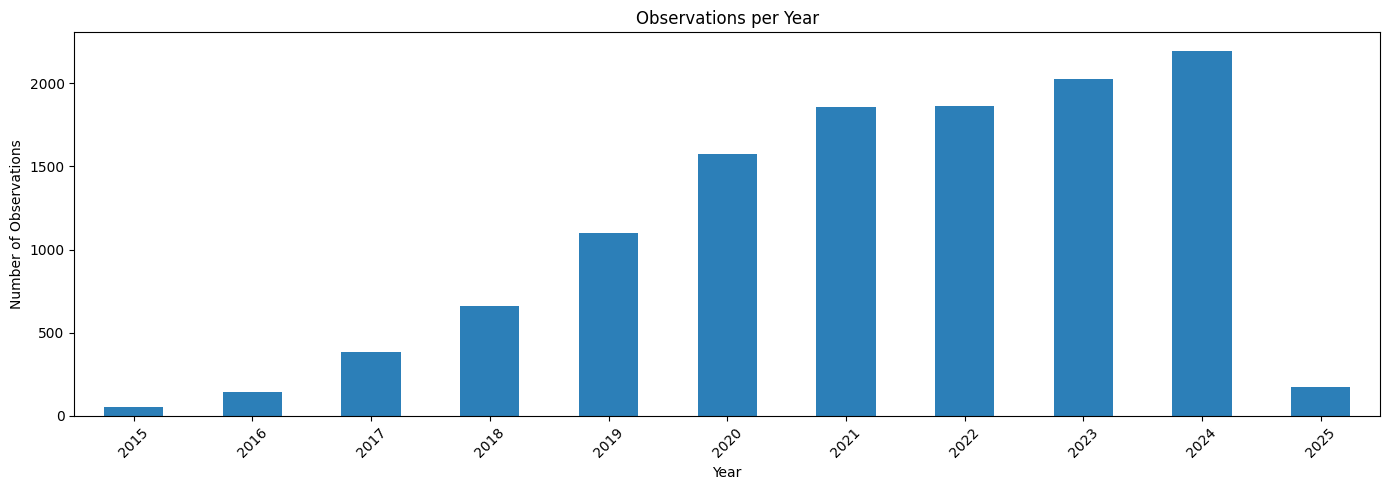

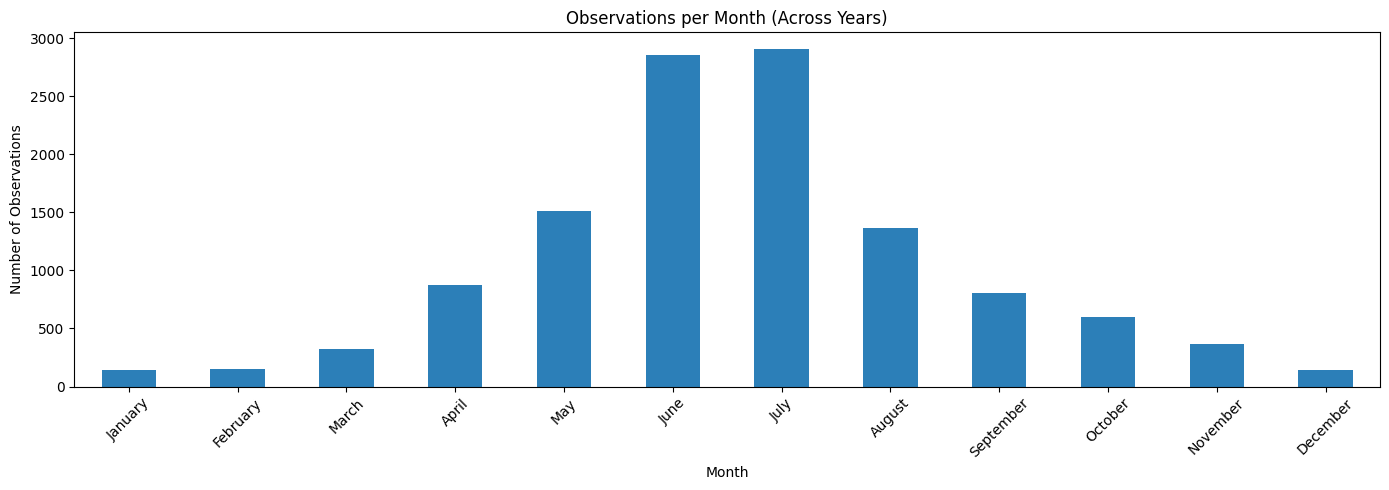

Spatial coverage


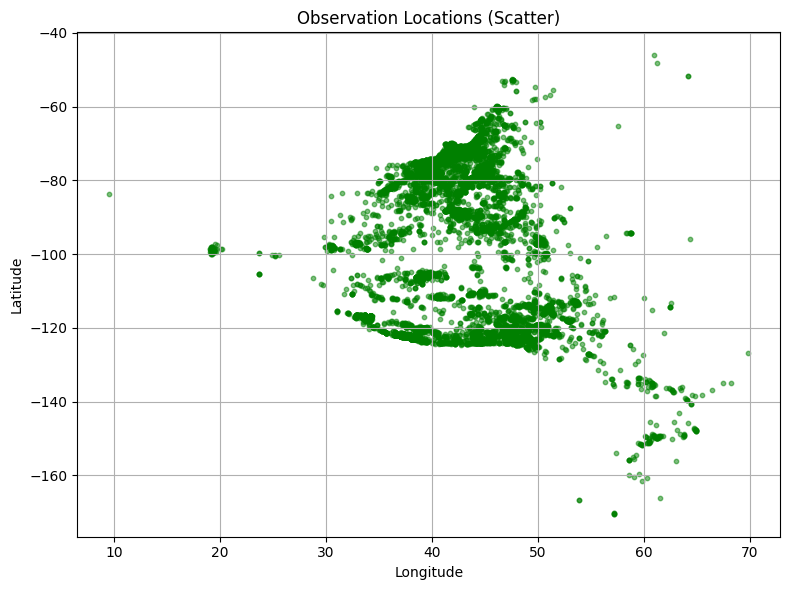

🌍 Saved interactive map to achillea_millefoglie_n_a/observations_map_achillea_millefoglie_n_a.html
Phenology over time


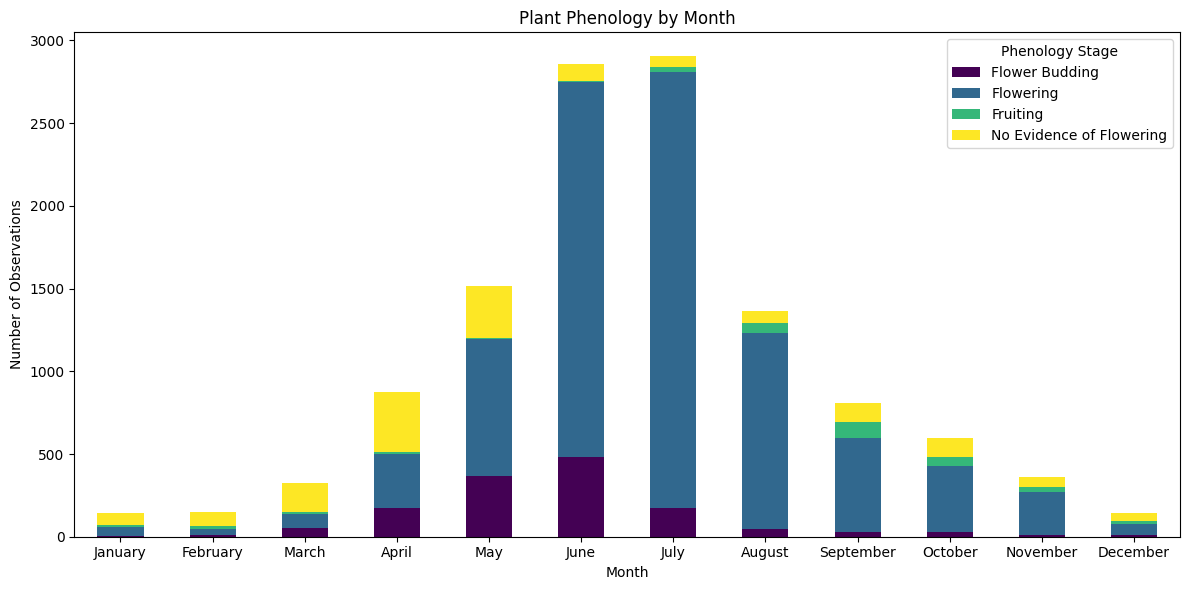

Top species


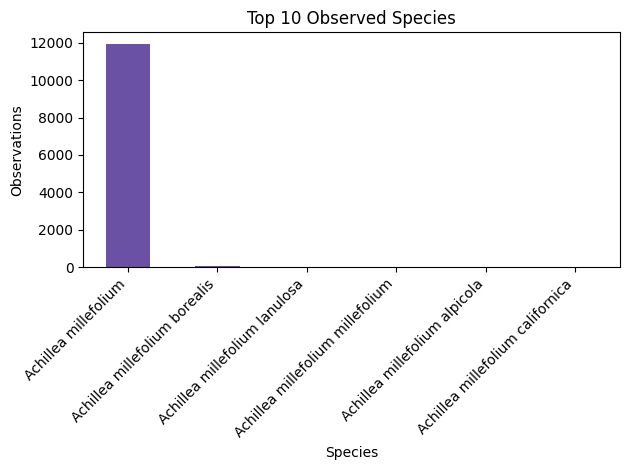

In [ ]:
place_id=9853 #North America (incl. ocean)
term_id=12 #Plant phenology

#Dowload observations with annotations of Achillea Millefoglie
taxon_id_am = 52821
repository_name_am = "achillea_millefoglie_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_am,repository_name=repository_name_am,term_id=term_id,place_id=place_id)

#later renamed as "annotations_achillea_millefoglie_n_a"

Loaded 0 existing observations
Created 41 date ranges for fetching

Fetching range 1/41: 2015-04-21 to 2015-07-19


Fetching 2015-04-21 to 2015-07-19: 1page [00:02,  3.00s/page, records=38, total=38, pages=1/1]


Found 38 observations in this date range
Total observations: 38 (38 new)

Fetching range 2/41: 2015-07-20 to 2015-10-17


Fetching 2015-07-20 to 2015-10-17: 1page [00:02,  2.75s/page, records=27, total=27, pages=1/1]


Found 27 observations in this date range
Total observations: 65 (65 new)

Fetching range 3/41: 2015-10-18 to 2016-01-15


Fetching 2015-10-18 to 2016-01-15: 1page [00:02,  2.23s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Total observations: 71 (71 new)

Fetching range 4/41: 2016-01-16 to 2016-04-14


Fetching 2016-01-16 to 2016-04-14: 0page [00:01, ?page/s]


Found 0 observations in this date range
Total observations: 71 (71 new)

Fetching range 5/41: 2016-04-15 to 2016-07-13


Fetching 2016-04-15 to 2016-07-13: 1page [00:03,  3.81s/page, records=71, total=71, pages=1/1]


Found 71 observations in this date range
Total observations: 142 (142 new)

Fetching range 6/41: 2016-07-14 to 2016-10-11


Fetching 2016-07-14 to 2016-10-11: 1page [00:03,  3.46s/page, records=50, total=50, pages=1/1]


Found 50 observations in this date range
Total observations: 192 (192 new)

Fetching range 7/41: 2016-10-12 to 2017-01-09


Fetching 2016-10-12 to 2017-01-09: 1page [00:02,  2.12s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Total observations: 206 (206 new)

Fetching range 8/41: 2017-01-10 to 2017-04-09


Fetching 2017-01-10 to 2017-04-09: 0page [00:01, ?page/s]


Found 0 observations in this date range
Total observations: 206 (206 new)

Fetching range 9/41: 2017-04-10 to 2017-07-08


Fetching 2017-04-10 to 2017-07-08: 1page [00:04,  4.76s/page, records=122, total=122, pages=1/1]


Found 122 observations in this date range
Total observations: 328 (328 new)

Fetching range 10/41: 2017-07-09 to 2017-10-06


Fetching 2017-07-09 to 2017-10-06: 1page [00:04,  4.99s/page, records=145, total=145, pages=1/1]


Found 145 observations in this date range
Total observations: 473 (473 new)

Fetching range 11/41: 2017-10-07 to 2018-01-04


Fetching 2017-10-07 to 2018-01-04: 1page [00:03,  3.34s/page, records=30, total=30, pages=1/1]


Found 30 observations in this date range
Total observations: 503 (503 new)

Fetching range 12/41: 2018-01-05 to 2018-04-04


Fetching 2018-01-05 to 2018-04-04: 1page [00:01,  1.69s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Total observations: 504 (504 new)

Fetching range 13/41: 2018-04-05 to 2018-07-03


Fetching 2018-04-05 to 2018-07-03: 2page [00:09,  4.54s/page, records=212, total=212, pages=2/2]


Found 212 observations in this date range
Total observations: 716 (716 new)

Fetching range 14/41: 2018-07-04 to 2018-10-01


Fetching 2018-07-04 to 2018-10-01: 2page [00:10,  5.28s/page, records=228, total=228, pages=2/2]


Found 228 observations in this date range
Total observations: 944 (944 new)

Fetching range 15/41: 2018-10-02 to 2018-12-30


Fetching 2018-10-02 to 2018-12-30: 1page [00:03,  3.39s/page, records=76, total=76, pages=1/1]


Found 76 observations in this date range
Total observations: 1020 (1020 new)

Fetching range 16/41: 2018-12-31 to 2019-03-30


Fetching 2018-12-31 to 2019-03-30: 1page [00:02,  2.49s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Total observations: 1024 (1024 new)

Fetching range 17/41: 2019-03-31 to 2019-06-28


Fetching 2019-03-31 to 2019-06-28: 2page [00:12,  6.00s/page, records=359, total=359, pages=2/2]


Found 359 observations in this date range
Total observations: 1383 (1383 new)

Fetching range 18/41: 2019-06-29 to 2019-09-26


Fetching 2019-06-29 to 2019-09-26: 4page [00:24,  6.08s/page, records=735, total=735, pages=4/4]


Found 735 observations in this date range
Total observations: 2118 (2118 new)

Fetching range 19/41: 2019-09-27 to 2019-12-25


Fetching 2019-09-27 to 2019-12-25: 1page [00:05,  5.05s/page, records=165, total=165, pages=1/1]


Found 165 observations in this date range
Total observations: 2283 (2283 new)

Fetching range 20/41: 2019-12-26 to 2020-03-24


Fetching 2019-12-26 to 2020-03-24: 1page [00:03,  3.07s/page, records=47, total=47, pages=1/1]


Found 47 observations in this date range
Total observations: 2330 (2330 new)

Fetching range 21/41: 2020-03-25 to 2020-06-22


Fetching 2020-03-25 to 2020-06-22: 4page [00:25,  6.36s/page, records=714, total=714, pages=4/4]


Found 714 observations in this date range
Total observations: 3044 (3044 new)

Fetching range 22/41: 2020-06-23 to 2020-09-20


Fetching 2020-06-23 to 2020-09-20: 3page [00:18,  6.07s/page, records=507, total=507, pages=3/3]


Found 507 observations in this date range
Total observations: 3551 (3551 new)

Fetching range 23/41: 2020-09-21 to 2020-12-19


Fetching 2020-09-21 to 2020-12-19: 2page [00:12,  6.50s/page, records=246, total=246, pages=2/2]


Found 246 observations in this date range
Total observations: 3797 (3797 new)

Fetching range 24/41: 2020-12-20 to 2021-03-19


Fetching 2020-12-20 to 2021-03-19: 1page [00:01,  1.94s/page, records=10, total=10, pages=1/1]


Found 10 observations in this date range
Total observations: 3807 (3807 new)

Fetching range 25/41: 2021-03-20 to 2021-06-17


Fetching 2021-03-20 to 2021-06-17: 2page [00:16,  8.06s/page, records=388, total=388, pages=2/2]


Found 388 observations in this date range
Total observations: 4195 (4195 new)

Fetching range 26/41: 2021-06-18 to 2021-09-15


Fetching 2021-06-18 to 2021-09-15: 3page [00:18,  6.31s/page, records=511, total=511, pages=3/3]


Found 511 observations in this date range
Total observations: 4706 (4706 new)

Fetching range 27/41: 2021-09-16 to 2021-12-14


Fetching 2021-09-16 to 2021-12-14: 2page [00:10,  5.00s/page, records=266, total=266, pages=2/2]


Found 266 observations in this date range
Total observations: 4972 (4972 new)

Fetching range 28/41: 2021-12-15 to 2022-03-14


Fetching 2021-12-15 to 2022-03-14: 1page [00:03,  3.05s/page, records=7, total=7, pages=1/1]


Found 7 observations in this date range
Total observations: 4979 (4979 new)

Fetching range 29/41: 2022-03-15 to 2022-06-12


Fetching 2022-03-15 to 2022-06-12: 2page [00:19,  9.97s/page, records=376, total=376, pages=2/2]


Found 376 observations in this date range
Total observations: 5355 (5355 new)

Fetching range 30/41: 2022-06-13 to 2022-09-10


Fetching 2022-06-13 to 2022-09-10: 3page [00:18,  6.27s/page, records=552, total=552, pages=3/3]


Found 552 observations in this date range
Total observations: 5907 (5907 new)

Fetching range 31/41: 2022-09-11 to 2022-12-09


Fetching 2022-09-11 to 2022-12-09: 2page [00:13,  6.73s/page, records=387, total=387, pages=2/2]


Found 387 observations in this date range
Total observations: 6294 (6294 new)

Fetching range 32/41: 2022-12-10 to 2023-03-09


Fetching 2022-12-10 to 2023-03-09: 1page [00:02,  2.03s/page, records=8, total=8, pages=1/1]


Found 8 observations in this date range
Total observations: 6302 (6302 new)

Fetching range 33/41: 2023-03-10 to 2023-06-07


Fetching 2023-03-10 to 2023-06-07: 2page [00:11,  5.53s/page, records=292, total=292, pages=2/2]


Found 292 observations in this date range
Total observations: 6594 (6594 new)

Fetching range 34/41: 2023-06-08 to 2023-09-05


Fetching 2023-06-08 to 2023-09-05: 4page [00:25,  6.30s/page, records=629, total=629, pages=4/4]


Found 629 observations in this date range
Total observations: 7223 (7223 new)

Fetching range 35/41: 2023-09-06 to 2023-12-04


Fetching 2023-09-06 to 2023-12-04: 2page [00:13,  6.83s/page, records=283, total=283, pages=2/2]


Found 283 observations in this date range
Total observations: 7506 (7506 new)

Fetching range 36/41: 2023-12-05 to 2024-03-03


Fetching 2023-12-05 to 2024-03-03: 1page [00:03,  3.58s/page, records=17, total=17, pages=1/1]


Found 17 observations in this date range
Total observations: 7523 (7523 new)

Fetching range 37/41: 2024-03-04 to 2024-06-01


Fetching 2024-03-04 to 2024-06-01: 2page [00:12,  6.25s/page, records=390, total=390, pages=2/2]


Found 390 observations in this date range
Total observations: 7913 (7913 new)

Fetching range 38/41: 2024-06-02 to 2024-08-30


Fetching 2024-06-02 to 2024-08-30: 5page [00:37,  7.40s/page, records=819, total=819, pages=5/5]


Found 819 observations in this date range
Total observations: 8732 (8732 new)

Fetching range 39/41: 2024-08-31 to 2024-11-28


Fetching 2024-08-31 to 2024-11-28: 3page [00:16,  5.39s/page, records=416, total=416, pages=3/3]


Found 416 observations in this date range
Total observations: 9148 (9148 new)

Fetching range 40/41: 2024-11-29 to 2025-02-26


Fetching 2024-11-29 to 2025-02-26: 1page [00:03,  3.56s/page, records=15, total=15, pages=1/1]


Found 15 observations in this date range
Total observations: 9163 (9163 new)

Fetching range 41/41: 2025-02-27 to 2025-04-18


Fetching 2025-02-27 to 2025-04-18: 1page [00:02,  2.05s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Total observations: 9167 (9167 new)

Completed fetching all observations. Total: 9167
Saved 9167 observations to trifolium_pratense_n_a/inaturalist_observation_taxon_51875_term_id_12.csv

Most Common Annotations (overall):
  - Plant Phenology: Flowering → 8007 times
  - Plant Phenology: No Evidence of Flowering → 572 times
  - Plant Phenology: Flower Budding → 350 times
  - Plant Phenology: Fruiting → 238 times

Top Species with Most Annotated Observations:
  - Trifolium pratense: 9160 annotations
  - Trifolium pratense pratense: 5 annotations
  - Trifolium pratense sativum: 2 annotations
Observations across years and per month


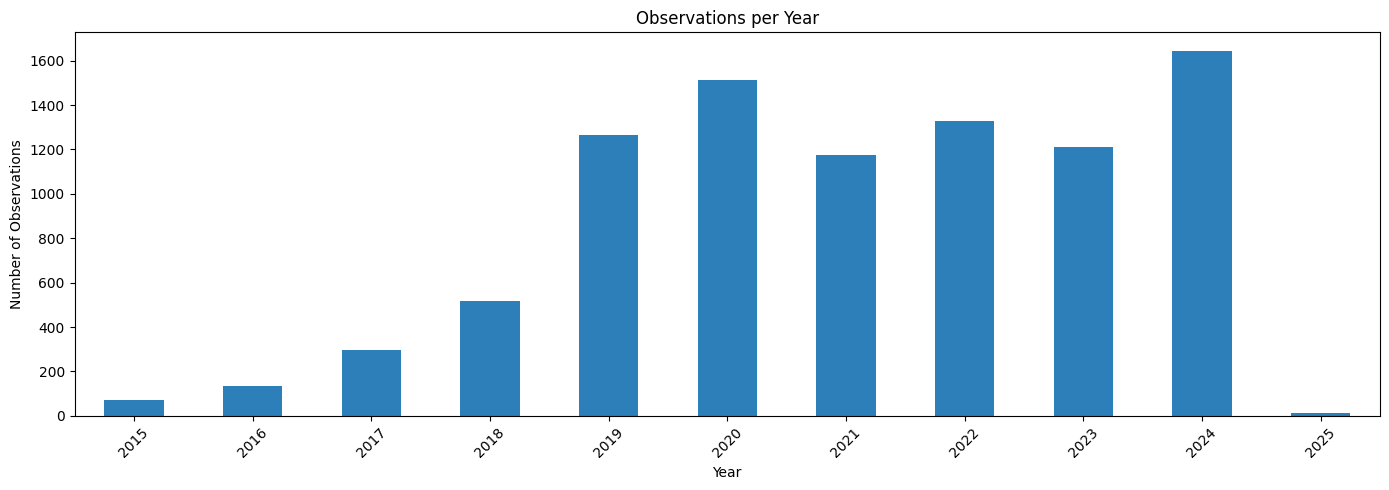

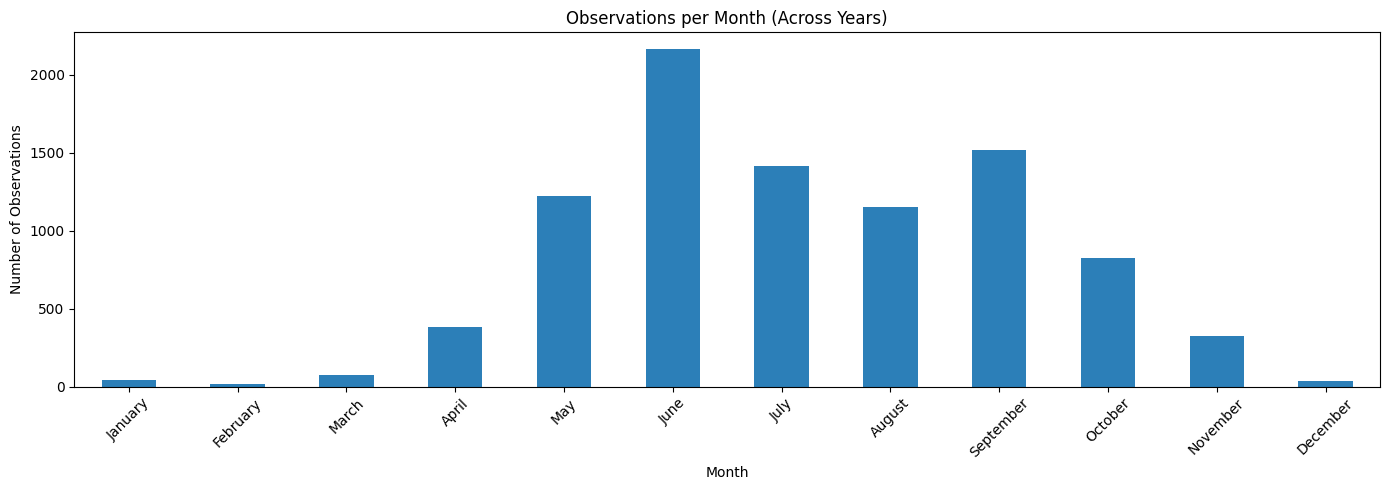

Spatial coverage


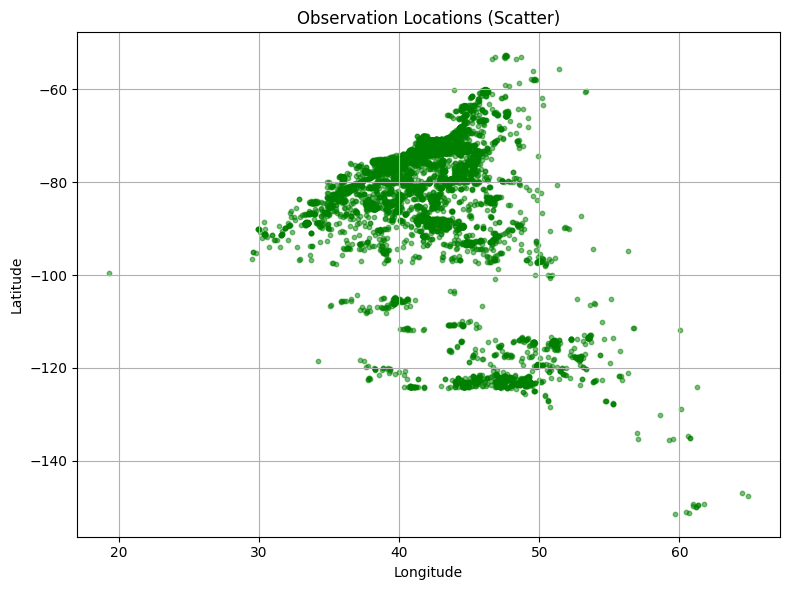

🌍 Saved interactive map to trifolium_pratense_n_a/observations_map_trifolium_pratense_n_a.html
Phenology over time


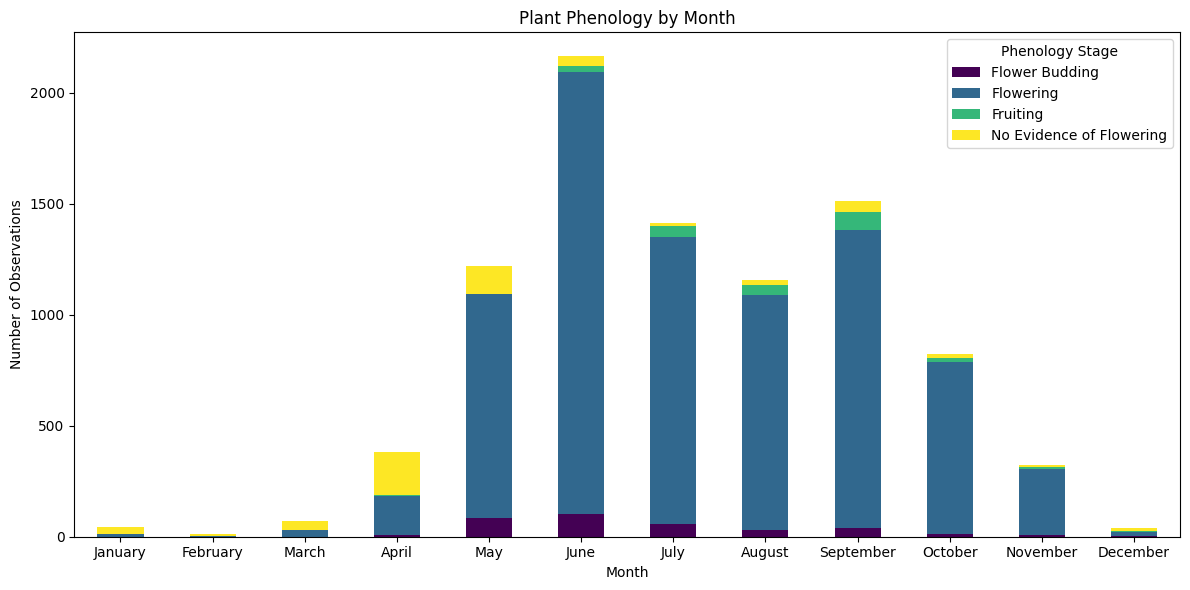

Top species


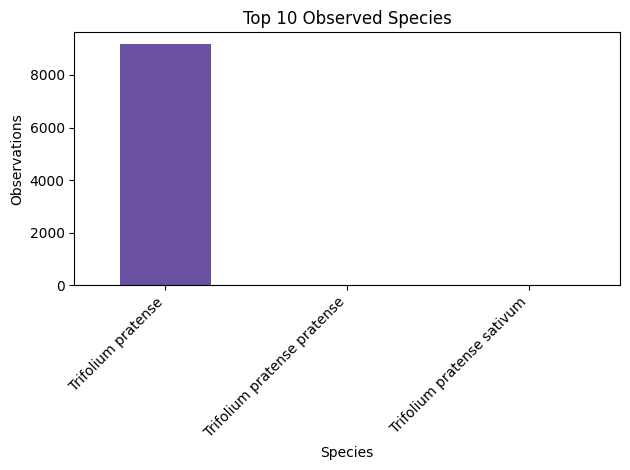

In [ ]:
#Dowload observations with annotations of Trifolium Pratense
taxon_id_tp = 51875
repository_name_tp = "trifolium_pratense_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_tp,repository_name=repository_name_tp,term_id=term_id,place_id=place_id)

#later renamed as "annotations_trifolium_pratense_n_a"

Loaded 0 existing observations
Created 41 date ranges for fetching

Fetching range 1/41: 2015-04-21 to 2015-07-19


Fetching 2015-04-21 to 2015-07-19: 1page [00:02,  2.39s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Total observations: 6 (6 new)

Fetching range 2/41: 2015-07-20 to 2015-10-17


Fetching 2015-07-20 to 2015-10-17: 0page [00:02, ?page/s]


Found 0 observations in this date range
Total observations: 6 (6 new)

Fetching range 3/41: 2015-10-18 to 2016-01-15


Fetching 2015-10-18 to 2016-01-15: 1page [00:02,  2.39s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Total observations: 11 (11 new)

Fetching range 4/41: 2016-01-16 to 2016-04-14


Fetching 2016-01-16 to 2016-04-14: 1page [00:02,  2.61s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Total observations: 16 (16 new)

Fetching range 5/41: 2016-04-15 to 2016-07-13


Fetching 2016-04-15 to 2016-07-13: 1page [00:03,  3.46s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Total observations: 30 (30 new)

Fetching range 6/41: 2016-07-14 to 2016-10-11


Fetching 2016-07-14 to 2016-10-11: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2016-07-14&d2=2016-10-11&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2016-07-14 to 2016-10-11: 1page [00:09,  9.19s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Total observations: 35 (35 new)

Fetching range 7/41: 2016-10-12 to 2017-01-09


Fetching 2016-10-12 to 2017-01-09: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2016-10-12&d2=2017-01-09&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2016-10-12 to 2017-01-09: 1page [00:09,  9.40s/page, records=8, total=8, pages=1/1]


Found 8 observations in this date range
Total observations: 43 (43 new)

Fetching range 8/41: 2017-01-10 to 2017-04-09


Fetching 2017-01-10 to 2017-04-09: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2017-01-10&d2=2017-04-09&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2017-01-10 to 2017-04-09: 1page [00:07,  7.89s/page, records=18, total=18, pages=1/1]


Found 18 observations in this date range
Total observations: 61 (61 new)

Fetching range 9/41: 2017-04-10 to 2017-07-08


Fetching 2017-04-10 to 2017-07-08: 1page [00:06,  6.30s/page, records=43, total=43, pages=1/1]


Found 43 observations in this date range
Total observations: 104 (104 new)

Fetching range 10/41: 2017-07-09 to 2017-10-06


Fetching 2017-07-09 to 2017-10-06: 1page [00:02,  2.86s/page, records=11, total=11, pages=1/1]


Found 11 observations in this date range
Total observations: 115 (115 new)

Fetching range 11/41: 2017-10-07 to 2018-01-04


Fetching 2017-10-07 to 2018-01-04: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2017-10-07&d2=2018-01-04&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2017-10-07 to 2018-01-04: 1page [00:09,  9.84s/page, records=12, total=12, pages=1/1]


Found 12 observations in this date range
Total observations: 127 (127 new)

Fetching range 12/41: 2018-01-05 to 2018-04-04


Fetching 2018-01-05 to 2018-04-04: 1page [00:03,  3.83s/page, records=29, total=29, pages=1/1]


Found 29 observations in this date range
Total observations: 156 (156 new)

Fetching range 13/41: 2018-04-05 to 2018-07-03


Fetching 2018-04-05 to 2018-07-03: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2018-04-05&d2=2018-07-03&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2018-04-05 to 2018-07-03: 1page [00:09,  9.42s/page, records=57, total=57, pages=1/1]


Found 57 observations in this date range
Total observations: 213 (213 new)

Fetching range 14/41: 2018-07-04 to 2018-10-01


Fetching 2018-07-04 to 2018-10-01: 1page [00:03,  3.60s/page, records=17, total=17, pages=1/1]


Found 17 observations in this date range
Total observations: 230 (230 new)

Fetching range 15/41: 2018-10-02 to 2018-12-30


Fetching 2018-10-02 to 2018-12-30: 1page [00:02,  2.37s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Total observations: 235 (235 new)

Fetching range 16/41: 2018-12-31 to 2019-03-30


Fetching 2018-12-31 to 2019-03-30: 1page [00:04,  4.05s/page, records=45, total=45, pages=1/1]


Found 45 observations in this date range
Total observations: 280 (280 new)

Fetching range 17/41: 2019-03-31 to 2019-06-28


Fetching 2019-03-31 to 2019-06-28: 1page [00:03,  3.84s/page, records=90, total=90, pages=1/1]


Found 90 observations in this date range
Total observations: 370 (370 new)

Fetching range 18/41: 2019-06-29 to 2019-09-26


Fetching 2019-06-29 to 2019-09-26: 1page [00:04,  4.09s/page, records=49, total=49, pages=1/1]


Found 49 observations in this date range
Total observations: 419 (419 new)

Fetching range 19/41: 2019-09-27 to 2019-12-25


Fetching 2019-09-27 to 2019-12-25: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2019-09-27&d2=2019-12-25&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2019-09-27 to 2019-12-25: 1page [00:08,  8.94s/page, records=35, total=35, pages=1/1]


Found 35 observations in this date range
Total observations: 454 (454 new)

Fetching range 20/41: 2019-12-26 to 2020-03-24


Fetching 2019-12-26 to 2020-03-24: 1page [00:04,  4.76s/page, records=93, total=93, pages=1/1]


Found 93 observations in this date range
Total observations: 547 (547 new)

Fetching range 21/41: 2020-03-25 to 2020-06-22


Fetching 2020-03-25 to 2020-06-22: 1page [00:06,  6.79s/page, records=185, total=185, pages=1/1]


Found 185 observations in this date range
Total observations: 732 (732 new)

Fetching range 22/41: 2020-06-23 to 2020-09-20


Fetching 2020-06-23 to 2020-09-20: 1page [00:04,  4.45s/page, records=80, total=80, pages=1/1]


Found 80 observations in this date range
Total observations: 812 (812 new)

Fetching range 23/41: 2020-09-21 to 2020-12-19


Fetching 2020-09-21 to 2020-12-19: 1page [00:03,  3.68s/page, records=64, total=64, pages=1/1]


Found 64 observations in this date range
Total observations: 876 (876 new)

Fetching range 24/41: 2020-12-20 to 2021-03-19


Fetching 2020-12-20 to 2021-03-19: 1page [00:05,  5.44s/page, records=91, total=91, pages=1/1]


Found 91 observations in this date range
Total observations: 967 (967 new)

Fetching range 25/41: 2021-03-20 to 2021-06-17


Fetching 2021-03-20 to 2021-06-17: 2page [00:12,  6.45s/page, records=343, total=343, pages=2/2]


Found 343 observations in this date range
Total observations: 1310 (1310 new)

Fetching range 26/41: 2021-06-18 to 2021-09-15


Fetching 2021-06-18 to 2021-09-15: 1page [00:03,  3.62s/page, records=78, total=78, pages=1/1]


Found 78 observations in this date range
Total observations: 1388 (1388 new)

Fetching range 27/41: 2021-09-16 to 2021-12-14


Fetching 2021-09-16 to 2021-12-14: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2021-09-16&d2=2021-12-14&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-09-16 to 2021-12-14: 1page [00:13, 13.05s/page, records=39, total=39, pages=1/1]


Found 39 observations in this date range
Total observations: 1427 (1427 new)

Fetching range 28/41: 2021-12-15 to 2022-03-14


Fetching 2021-12-15 to 2022-03-14: 1page [00:04,  4.93s/page, records=85, total=85, pages=1/1]


Found 85 observations in this date range
Total observations: 1512 (1512 new)

Fetching range 29/41: 2022-03-15 to 2022-06-12


Fetching 2022-03-15 to 2022-06-12: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=1&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2022-03-15 to 2022-06-12: 1page [00:21, 21.57s/page, records=200, total=733, pages=1/4]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=2&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=2&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2022-03-15 to 2022-06-12: 2page [00:41, 20.85s/page, records=400, total=733, pages=2/4]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=3&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2022-03-15 to 2022-06-12: 3page [00:54, 16.99s/page, records=600, total=733, pages=3/4]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=4&d1=2022-03-15&d2=2022-06-12&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2022-03-15 to 2022-06-12: 4page [01:06, 16.60s/page, records=733, total=733, pages=4/4]


Found 733 observations in this date range
Total observations: 2245 (2245 new)

Fetching range 30/41: 2022-06-13 to 2022-09-10


Fetching 2022-06-13 to 2022-09-10: 2page [00:14,  7.32s/page, records=400, total=434, pages=2/3]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52720&per_page=200&page=3&d1=2022-06-13&d2=2022-09-10&order=asc&order_by=created_at&term_id=12&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2022-06-13 to 2022-09-10: 3page [00:26,  8.73s/page, records=434, total=434, pages=3/3]


Found 434 observations in this date range
Total observations: 2679 (2679 new)

Fetching range 31/41: 2022-09-11 to 2022-12-09


Fetching 2022-09-11 to 2022-12-09: 1page [00:06,  6.50s/page, records=85, total=85, pages=1/1]


Found 85 observations in this date range
Total observations: 2764 (2764 new)

Fetching range 32/41: 2022-12-10 to 2023-03-09


Fetching 2022-12-10 to 2023-03-09: 1page [00:05,  5.56s/page, records=145, total=145, pages=1/1]


Found 145 observations in this date range
Total observations: 2909 (2909 new)

Fetching range 33/41: 2023-03-10 to 2023-06-07


Fetching 2023-03-10 to 2023-06-07: 7page [00:43,  6.19s/page, records=1290, total=1290, pages=7/7]


Found 1290 observations in this date range
Total observations: 4199 (4199 new)

Fetching range 34/41: 2023-06-08 to 2023-09-05


Fetching 2023-06-08 to 2023-09-05: 4page [00:26,  6.53s/page, records=767, total=767, pages=4/4]


Found 767 observations in this date range
Total observations: 4966 (4966 new)

Fetching range 35/41: 2023-09-06 to 2023-12-04


Fetching 2023-09-06 to 2023-12-04: 1page [00:06,  6.48s/page, records=178, total=178, pages=1/1]


Found 178 observations in this date range
Total observations: 5144 (5144 new)

Fetching range 36/41: 2023-12-05 to 2024-03-03


Fetching 2023-12-05 to 2024-03-03: 1page [00:04,  4.27s/page, records=135, total=135, pages=1/1]


Found 135 observations in this date range
Total observations: 5279 (5279 new)

Fetching range 37/41: 2024-03-04 to 2024-06-01


Fetching 2024-03-04 to 2024-06-01: 8page [00:52,  6.54s/page, records=1452, total=1452, pages=8/8]


Found 1452 observations in this date range
Total observations: 6731 (6731 new)

Fetching range 38/41: 2024-06-02 to 2024-08-30


Fetching 2024-06-02 to 2024-08-30: 7page [00:52,  7.44s/page, records=1292, total=1292, pages=7/7]


Found 1292 observations in this date range
Total observations: 8023 (8023 new)

Fetching range 39/41: 2024-08-31 to 2024-11-28


Fetching 2024-08-31 to 2024-11-28: 1page [00:04,  4.58s/page, records=114, total=114, pages=1/1]


Found 114 observations in this date range
Total observations: 8137 (8137 new)

Fetching range 40/41: 2024-11-29 to 2025-02-26


Fetching 2024-11-29 to 2025-02-26: 1page [00:03,  3.58s/page, records=94, total=94, pages=1/1]


Found 94 observations in this date range
Total observations: 8231 (8231 new)

Fetching range 41/41: 2025-02-27 to 2025-04-18


Fetching 2025-02-27 to 2025-04-18: 1page [00:04,  4.34s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Total observations: 8235 (8235 new)

Completed fetching all observations. Total: 8235
Saved 8235 observations to dactylis_glomerata_n_a/inaturalist_observation_taxon_52720_term_id_12.csv

Most Common Annotations (overall):
  - Plant Phenology: Flowering → 3398 times
  - Plant Phenology: Fruiting → 2977 times
  - Plant Phenology: Flower Budding → 1742 times
  - Plant Phenology: No Evidence of Flowering → 118 times

Top Species with Most Annotated Observations:
  - Dactylis glomerata: 8229 annotations
  - Dactylis glomerata glomerata: 4 annotations
  - Dactylis glomerata hispanica: 1 annotations
  - Dactylis glomerata lobata: 1 annotations
Observations across years and per month


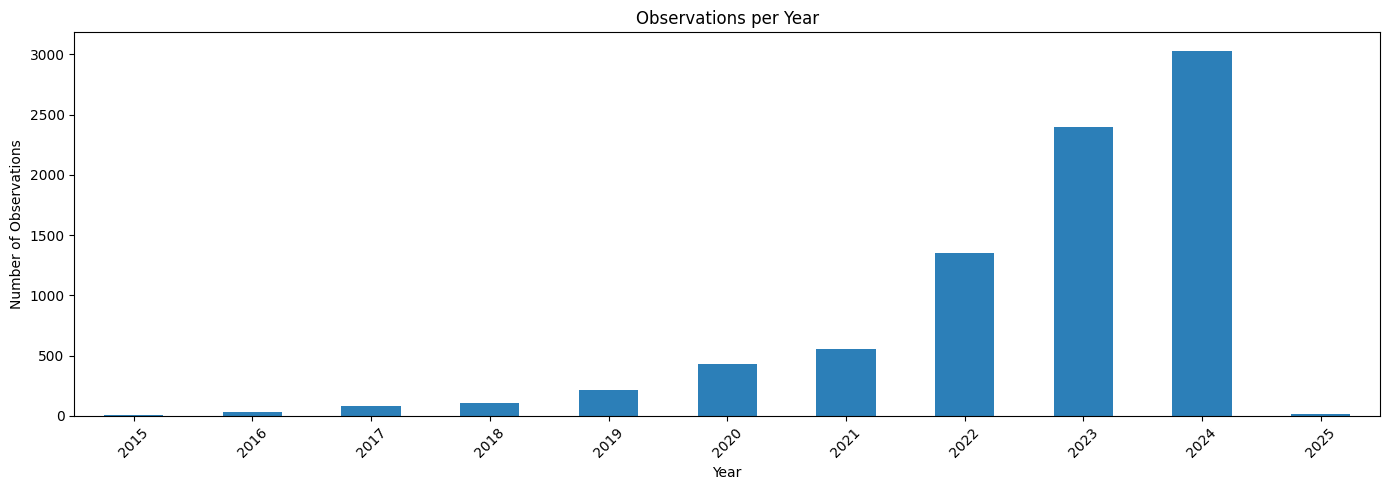

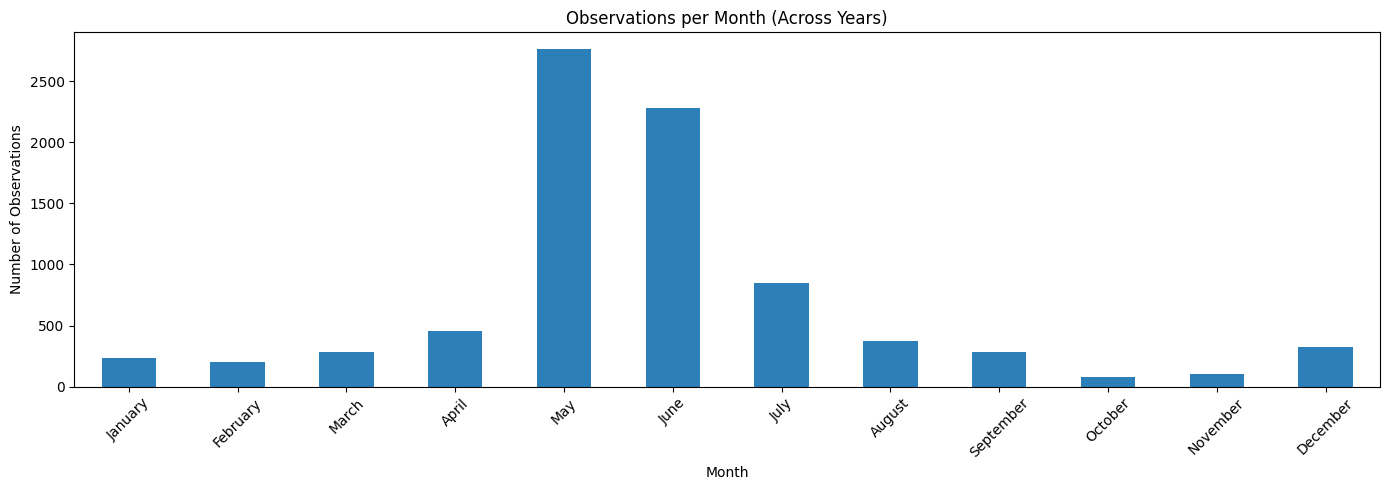

Spatial coverage


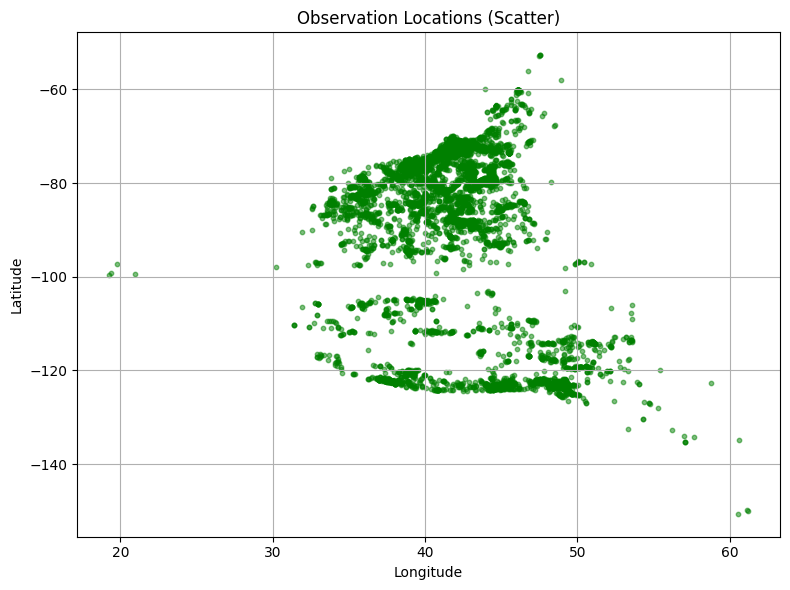

🌍 Saved interactive map to dactylis_glomerata_n_a/observations_map_dactylis_glomerata_n_a.html
Phenology over time


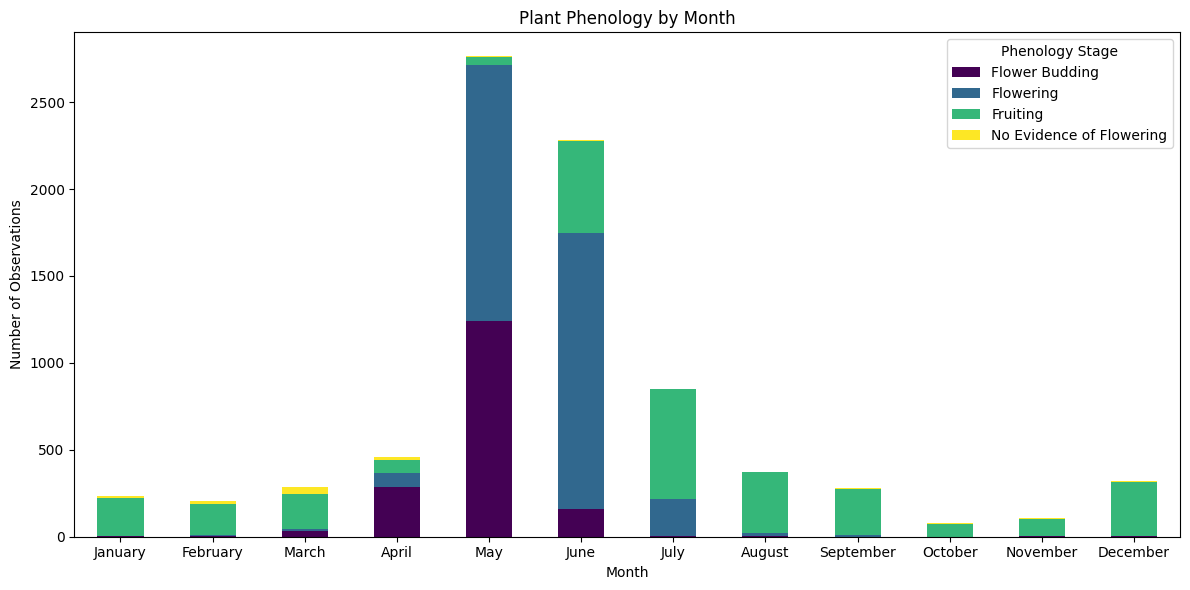

Top species


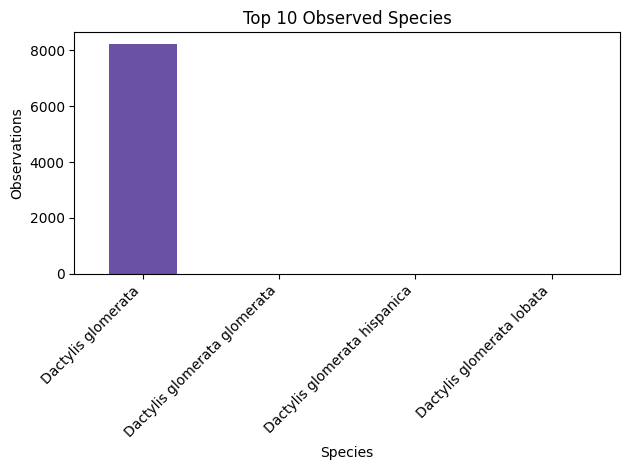

In [ ]:
#Dowload observations with annotations of Dactylis Glomerata
taxon_id_dg = 52720
repository_name_dg = "dactylis_glomerata_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_dg,repository_name=repository_name_dg,term_id=term_id,place_id=place_id)

#later renamed as "annotations_dactylis_glomerata_n_a"

Now download data of observations (with and without annotations), also download photos

In [11]:
place_id=9853 #North America (incl. ocean)
term_id=12 #Plant phenology

#Dowload observations without annotations of Achillea Millefoglie
taxon_id_am = 52821
repository_name_am = "no_annotations_achillea_millefoglie_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_am,repository_name=repository_name_am,term_id=term_id,place_id=place_id, with_annotations=False)

Loaded 0 existing observations
Created 122 date ranges for fetching

Fetching range 1/122: 2015-04-26 to 2015-05-25


Fetching 2015-04-26 to 2015-05-25: 1page [00:04,  4.23s/page, records=87, total=87, pages=1/1]


Found 87 observations in this date range
Total observations: 87 (87 new)

Fetching range 2/122: 2015-05-26 to 2015-06-24


Fetching 2015-05-26 to 2015-06-24: 1page [00:05,  5.11s/page, records=121, total=121, pages=1/1]


Found 121 observations in this date range
Total observations: 208 (208 new)

Fetching range 3/122: 2015-06-25 to 2015-07-24


Fetching 2015-06-25 to 2015-07-24: 1page [00:04,  4.88s/page, records=176, total=176, pages=1/1]


Found 176 observations in this date range
Total observations: 384 (384 new)

Fetching range 4/122: 2015-07-25 to 2015-08-23


Fetching 2015-07-25 to 2015-08-23: 1page [00:04,  4.53s/page, records=67, total=67, pages=1/1]


Found 67 observations in this date range
Total observations: 451 (451 new)

Fetching range 5/122: 2015-08-24 to 2015-09-22


Fetching 2015-08-24 to 2015-09-22: 1page [00:03,  3.45s/page, records=39, total=39, pages=1/1]


Found 39 observations in this date range
Total observations: 490 (490 new)

Fetching range 6/122: 2015-09-23 to 2015-10-22


Fetching 2015-09-23 to 2015-10-22: 1page [00:03,  3.30s/page, records=42, total=42, pages=1/1]


Found 42 observations in this date range
Total observations: 532 (532 new)

Fetching range 7/122: 2015-10-23 to 2015-11-21


Fetching 2015-10-23 to 2015-11-21: 1page [00:02,  2.60s/page, records=32, total=32, pages=1/1]


Found 32 observations in this date range
Total observations: 564 (564 new)

Fetching range 8/122: 2015-11-22 to 2015-12-21


Fetching 2015-11-22 to 2015-12-21: 1page [00:02,  2.33s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Total observations: 578 (578 new)

Fetching range 9/122: 2015-12-22 to 2016-01-20


Fetching 2015-12-22 to 2016-01-20: 1page [00:03,  3.50s/page, records=10, total=10, pages=1/1]


Found 10 observations in this date range
Total observations: 588 (588 new)

Fetching range 10/122: 2016-01-21 to 2016-02-19


Fetching 2016-01-21 to 2016-02-19: 1page [00:02,  2.11s/page, records=13, total=13, pages=1/1]


Found 13 observations in this date range
Total observations: 601 (601 new)

Fetching range 11/122: 2016-02-20 to 2016-03-20


Fetching 2016-02-20 to 2016-03-20: 1page [00:02,  2.95s/page, records=33, total=33, pages=1/1]


Found 33 observations in this date range
Total observations: 634 (634 new)

Fetching range 12/122: 2016-03-21 to 2016-04-19


Fetching 2016-03-21 to 2016-04-19: 1page [00:06,  6.03s/page, records=171, total=171, pages=1/1]


Found 171 observations in this date range
Total observations: 805 (805 new)

Fetching range 13/122: 2016-04-20 to 2016-05-19


Fetching 2016-04-20 to 2016-05-19: 2page [00:10,  5.46s/page, records=277, total=277, pages=2/2]


Found 277 observations in this date range
Total observations: 1082 (1082 new)

Fetching range 14/122: 2016-05-20 to 2016-06-18


Fetching 2016-05-20 to 2016-06-18: 2page [00:22, 11.44s/page, records=383, total=383, pages=2/2]


Found 383 observations in this date range
Total observations: 1465 (1465 new)

Fetching range 15/122: 2016-06-19 to 2016-07-18


Fetching 2016-06-19 to 2016-07-18: 2page [00:17,  8.56s/page, records=276, total=276, pages=2/2]


Found 276 observations in this date range
Total observations: 1741 (1741 new)

Fetching range 16/122: 2016-07-19 to 2016-08-17


Fetching 2016-07-19 to 2016-08-17: 2page [00:11,  5.71s/page, records=230, total=230, pages=2/2]


Found 230 observations in this date range
Total observations: 1971 (1971 new)

Fetching range 17/122: 2016-08-18 to 2016-09-16


Fetching 2016-08-18 to 2016-09-16: 1page [00:05,  5.11s/page, records=133, total=133, pages=1/1]


Found 133 observations in this date range
Total observations: 2104 (2104 new)

Fetching range 18/122: 2016-09-17 to 2016-10-16


Fetching 2016-09-17 to 2016-10-16: 1page [00:04,  4.08s/page, records=82, total=82, pages=1/1]


Found 82 observations in this date range
Total observations: 2186 (2186 new)

Fetching range 19/122: 2016-10-17 to 2016-11-15


Fetching 2016-10-17 to 2016-11-15: 1page [00:04,  4.59s/page, records=54, total=54, pages=1/1]


Found 54 observations in this date range
Total observations: 2240 (2240 new)

Fetching range 20/122: 2016-11-16 to 2016-12-15


Fetching 2016-11-16 to 2016-12-15: 1page [00:02,  2.91s/page, records=35, total=35, pages=1/1]


Found 35 observations in this date range
Total observations: 2275 (2275 new)

Fetching range 21/122: 2016-12-16 to 2017-01-14


Fetching 2016-12-16 to 2017-01-14: 1page [00:02,  2.70s/page, records=17, total=17, pages=1/1]


Found 17 observations in this date range
Total observations: 2292 (2292 new)

Fetching range 22/122: 2017-01-15 to 2017-02-13


Fetching 2017-01-15 to 2017-02-13: 1page [00:02,  2.50s/page, records=20, total=20, pages=1/1]


Found 20 observations in this date range
Total observations: 2312 (2312 new)

Fetching range 23/122: 2017-02-14 to 2017-03-15


Fetching 2017-02-14 to 2017-03-15: 1page [00:03,  3.79s/page, records=50, total=50, pages=1/1]


Found 50 observations in this date range
Total observations: 2362 (2362 new)

Fetching range 24/122: 2017-03-16 to 2017-04-14


Fetching 2017-03-16 to 2017-04-14: 2page [00:15,  7.57s/page, records=210, total=210, pages=2/2]


Found 210 observations in this date range
Total observations: 2572 (2572 new)

Fetching range 25/122: 2017-04-15 to 2017-05-14


Fetching 2017-04-15 to 2017-05-14: 3page [00:21,  7.19s/page, records=495, total=495, pages=3/3]


Found 495 observations in this date range
Total observations: 3067 (3067 new)

Fetching range 26/122: 2017-05-15 to 2017-06-13


Fetching 2017-05-15 to 2017-06-13: 3page [00:18,  6.15s/page, records=517, total=517, pages=3/3]


Found 517 observations in this date range
Total observations: 3584 (3584 new)

Fetching range 27/122: 2017-06-14 to 2017-07-13


Fetching 2017-06-14 to 2017-07-13: 4page [00:27,  6.91s/page, records=758, total=758, pages=4/4]


Found 758 observations in this date range
Total observations: 4342 (4342 new)

Fetching range 28/122: 2017-07-14 to 2017-08-12


Fetching 2017-07-14 to 2017-08-12: 3page [00:21,  7.00s/page, records=573, total=573, pages=3/3]


Found 573 observations in this date range
Total observations: 4915 (4915 new)

Fetching range 29/122: 2017-08-13 to 2017-09-11


Fetching 2017-08-13 to 2017-09-11: 3page [00:17,  5.77s/page, records=417, total=417, pages=3/3]


Found 417 observations in this date range
Total observations: 5332 (5332 new)

Fetching range 30/122: 2017-09-12 to 2017-10-11


Fetching 2017-09-12 to 2017-10-11: 2page [00:11,  5.95s/page, records=282, total=282, pages=2/2]


Found 282 observations in this date range
Total observations: 5614 (5614 new)

Fetching range 31/122: 2017-10-12 to 2017-11-10


Fetching 2017-10-12 to 2017-11-10: 1page [00:04,  4.31s/page, records=114, total=114, pages=1/1]


Found 114 observations in this date range
Total observations: 5728 (5728 new)

Fetching range 32/122: 2017-11-11 to 2017-12-10


Fetching 2017-11-11 to 2017-12-10: 1page [00:03,  3.61s/page, records=46, total=46, pages=1/1]


Found 46 observations in this date range
Total observations: 5774 (5774 new)

Fetching range 33/122: 2017-12-11 to 2018-01-09


Fetching 2017-12-11 to 2018-01-09: 1page [00:04,  4.01s/page, records=41, total=41, pages=1/1]


Found 41 observations in this date range
Total observations: 5815 (5815 new)

Fetching range 34/122: 2018-01-10 to 2018-02-08


Fetching 2018-01-10 to 2018-02-08: 1page [00:04,  4.34s/page, records=70, total=70, pages=1/1]


Found 70 observations in this date range
Total observations: 5885 (5885 new)

Fetching range 35/122: 2018-02-09 to 2018-03-10


Fetching 2018-02-09 to 2018-03-10: 1page [00:04,  4.86s/page, records=121, total=121, pages=1/1]


Found 121 observations in this date range
Total observations: 6006 (6006 new)

Fetching range 36/122: 2018-03-11 to 2018-04-09


Fetching 2018-03-11 to 2018-04-09: 1page [00:06,  6.24s/page, records=200, total=262, pages=1/2]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2018-03-11&d2=2018-04-09&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2018-03-11 to 2018-04-09: 2page [00:16,  8.45s/page, records=262, total=262, pages=2/2]


Found 262 observations in this date range
Total observations: 6268 (6268 new)

Fetching range 37/122: 2018-04-10 to 2018-05-09


Fetching 2018-04-10 to 2018-05-09: 3page [00:24,  8.44s/page, records=600, total=1072, pages=3/6]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=4&d1=2018-04-10&d2=2018-05-09&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2018-04-10 to 2018-05-09: 6page [00:53,  8.86s/page, records=1072, total=1072, pages=6/6]


Found 1072 observations in this date range
Total observations: 7340 (7340 new)

Fetching range 38/122: 2018-05-10 to 2018-06-08


Fetching 2018-05-10 to 2018-06-08: 6page [00:41,  6.97s/page, records=1002, total=1002, pages=6/6]


Found 1002 observations in this date range
Total observations: 8342 (8342 new)

Fetching range 39/122: 2018-06-09 to 2018-07-08


Fetching 2018-06-09 to 2018-07-08: 8page [00:58,  7.29s/page, records=1544, total=1544, pages=8/8]


Found 1544 observations in this date range
Total observations: 9886 (9886 new)

Fetching range 40/122: 2018-07-09 to 2018-08-07


Fetching 2018-07-09 to 2018-08-07: 2page [00:13,  6.83s/page, records=400, total=1176, pages=2/6]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2018-07-09&d2=2018-08-07&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2018-07-09&d2=2018-08-07&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...
Request failed after 3 attempts: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded

Fetching 2018-07-09 to 2018-08-07: 6page [01:05, 10.84s/page, records=1176, total=1176, pages=6/6]


Found 1176 observations in this date range
Total observations: 11062 (11062 new)

Fetching range 41/122: 2018-08-08 to 2018-09-06


Fetching 2018-08-08 to 2018-09-06: 4page [00:28,  7.19s/page, records=662, total=662, pages=4/4]


Found 662 observations in this date range
Total observations: 11724 (11724 new)

Fetching range 42/122: 2018-09-07 to 2018-10-06


Fetching 2018-09-07 to 2018-10-06: 3page [00:18,  6.08s/page, records=508, total=508, pages=3/3]


Found 508 observations in this date range
Total observations: 12232 (12232 new)

Fetching range 43/122: 2018-10-07 to 2018-11-05


Fetching 2018-10-07 to 2018-11-05: 2page [00:11,  5.83s/page, records=289, total=289, pages=2/2]


Found 289 observations in this date range
Total observations: 12521 (12521 new)

Fetching range 44/122: 2018-11-06 to 2018-12-05


Fetching 2018-11-06 to 2018-12-05: 1page [00:04,  4.05s/page, records=115, total=115, pages=1/1]


Found 115 observations in this date range
Total observations: 12636 (12636 new)

Fetching range 45/122: 2018-12-06 to 2019-01-04


Fetching 2018-12-06 to 2019-01-04: 1page [00:04,  4.10s/page, records=66, total=66, pages=1/1]


Found 66 observations in this date range
Total observations: 12702 (12702 new)

Fetching range 46/122: 2019-01-05 to 2019-02-03


Fetching 2019-01-05 to 2019-02-03: 1page [00:03,  3.91s/page, records=67, total=67, pages=1/1]


Found 67 observations in this date range
Total observations: 12769 (12769 new)

Fetching range 47/122: 2019-02-04 to 2019-03-05


Fetching 2019-02-04 to 2019-03-05: 1page [00:07,  7.03s/page, records=146, total=146, pages=1/1]


Found 146 observations in this date range
Total observations: 12915 (12915 new)

Fetching range 48/122: 2019-03-06 to 2019-04-04


Fetching 2019-03-06 to 2019-04-04: 2page [00:13,  6.62s/page, records=314, total=314, pages=2/2]


Found 314 observations in this date range
Total observations: 13229 (13229 new)

Fetching range 49/122: 2019-04-05 to 2019-05-04


Fetching 2019-04-05 to 2019-05-04: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2019-04-05&d2=2019-05-04&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2019-04-05&d2=2019-05-04&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2019-04-05 to 2019-05-04: 8page [01:19,  9.96s/page, records=1559, total=1559, pages=8/8]


Found 1559 observations in this date range
Total observations: 14788 (14788 new)

Fetching range 50/122: 2019-05-05 to 2019-06-03


Fetching 2019-05-05 to 2019-06-03: 9page [00:59,  6.64s/page, records=1665, total=1665, pages=9/9]


Found 1665 observations in this date range
Total observations: 16453 (16453 new)

Fetching range 51/122: 2019-06-04 to 2019-07-03


Fetching 2019-06-04 to 2019-07-03: 9page [01:05,  7.74s/page, records=1800, total=2574, pages=9/13]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=10&d1=2019-06-04&d2=2019-07-03&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2019-06-04 to 2019-07-03: 10page [01:19,  9.58s/page, records=2000, total=2574, pages=10/13]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=11&d1=2019-06-04&d2=2019-07-03&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=11&d1=2019-06-04&d2=2019-07-03&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...
Request failed after 3 attempts: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceed

Fetching 2019-06-04 to 2019-07-03: 13page [01:59,  9.19s/page, records=2574, total=2574, pages=13/13]


Found 2574 observations in this date range
Total observations: 19027 (19027 new)

Fetching range 52/122: 2019-07-04 to 2019-08-02


Fetching 2019-07-04 to 2019-08-02: 8page [00:48,  6.10s/page, records=1600, total=2759, pages=8/14]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=9&d1=2019-07-04&d2=2019-08-02&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=9&d1=2019-07-04&d2=2019-08-02&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2019-07-04 to 2019-08-02: 14page [01:43,  7.41s/page, records=2759, total=2759, pages=14/14]


Found 2759 observations in this date range
Total observations: 21786 (21786 new)

Fetching range 53/122: 2019-08-03 to 2019-09-01


Fetching 2019-08-03 to 2019-09-01: 9page [01:08,  7.58s/page, records=1623, total=1623, pages=9/9]


Found 1623 observations in this date range
Total observations: 23409 (23409 new)

Fetching range 54/122: 2019-09-02 to 2019-10-01


Fetching 2019-09-02 to 2019-10-01: 5page [00:34,  6.98s/page, records=913, total=913, pages=5/5]


Found 913 observations in this date range
Total observations: 24322 (24322 new)

Fetching range 55/122: 2019-10-02 to 2019-10-31


Fetching 2019-10-02 to 2019-10-31: 3page [00:22,  7.40s/page, records=478, total=478, pages=3/3]


Found 478 observations in this date range
Total observations: 24800 (24800 new)

Fetching range 56/122: 2019-11-01 to 2019-11-30


Fetching 2019-11-01 to 2019-11-30: 2page [00:13,  6.92s/page, records=214, total=214, pages=2/2]


Found 214 observations in this date range
Total observations: 25014 (25014 new)

Fetching range 57/122: 2019-12-01 to 2019-12-30


Fetching 2019-12-01 to 2019-12-30: 1page [00:03,  3.78s/page, records=107, total=107, pages=1/1]


Found 107 observations in this date range
Total observations: 25121 (25121 new)

Fetching range 58/122: 2019-12-31 to 2020-01-29


Fetching 2019-12-31 to 2020-01-29: 1page [00:03,  3.84s/page, records=116, total=116, pages=1/1]


Found 116 observations in this date range
Total observations: 25237 (25237 new)

Fetching range 59/122: 2020-01-30 to 2020-02-28


Fetching 2020-01-30 to 2020-02-28: 2page [00:12,  6.16s/page, records=282, total=282, pages=2/2]


Found 282 observations in this date range
Total observations: 25519 (25519 new)

Fetching range 60/122: 2020-02-29 to 2020-03-29


Fetching 2020-02-29 to 2020-03-29: 3page [00:16,  5.53s/page, records=471, total=471, pages=3/3]


Found 471 observations in this date range
Total observations: 25990 (25990 new)

Fetching range 61/122: 2020-03-30 to 2020-04-28


Fetching 2020-03-30 to 2020-04-28: 8page [00:55,  6.88s/page, records=1437, total=1437, pages=8/8]


Found 1437 observations in this date range
Total observations: 27427 (27427 new)

Fetching range 62/122: 2020-04-29 to 2020-05-28


Fetching 2020-04-29 to 2020-05-28: 11page [01:07,  6.12s/page, records=2055, total=2055, pages=11/11]


Found 2055 observations in this date range
Total observations: 29482 (29482 new)

Fetching range 63/122: 2020-05-29 to 2020-06-27


Fetching 2020-05-29 to 2020-06-27: 15page [01:39,  6.40s/page, records=3000, total=3906, pages=15/20]

Request failed: ('Connection aborted.', ConnectionResetError(10054, "Connessione in corso interrotta forzatamente dall'host remoto", None, 10054, None)). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=16&d1=2020-05-29&d2=2020-06-27&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2020-05-29 to 2020-06-27: 20page [02:24,  7.21s/page, records=3906, total=3906, pages=20/20]


Found 3906 observations in this date range
Total observations: 33388 (33388 new)

Fetching range 64/122: 2020-06-28 to 2020-07-27


Fetching 2020-06-28 to 2020-07-27: 10page [00:59,  6.29s/page, records=2000, total=3903, pages=10/20]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=11&d1=2020-06-28&d2=2020-07-27&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2020-06-28 to 2020-07-27: 20page [02:11,  6.57s/page, records=3903, total=3903, pages=20/20]


Found 3903 observations in this date range
Total observations: 37291 (37291 new)

Fetching range 65/122: 2020-07-28 to 2020-08-26


Fetching 2020-07-28 to 2020-08-26: 2page [00:11,  5.89s/page, records=400, total=1997, pages=2/10]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2020-07-28&d2=2020-08-26&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2020-07-28&d2=2020-08-26&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...
Request failed after 3 attempts: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded

Fetching 2020-07-28 to 2020-08-26: 5page [01:07, 14.30s/page, records=1000, total=1997, pages=5/10]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=6&d1=2020-07-28&d2=2020-08-26&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=6&d1=2020-07-28&d2=2020-08-26&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2020-07-28 to 2020-08-26: 10page [01:57, 11.73s/page, records=1997, total=1997, pages=10/10]


Found 1997 observations in this date range
Total observations: 39288 (39288 new)

Fetching range 66/122: 2020-08-27 to 2020-09-25


Fetching 2020-08-27 to 2020-09-25: 7page [00:47,  6.72s/page, records=1350, total=1350, pages=7/7]


Found 1350 observations in this date range
Total observations: 40638 (40638 new)

Fetching range 67/122: 2020-09-26 to 2020-10-25


Fetching 2020-09-26 to 2020-10-25: 5page [00:32,  6.50s/page, records=907, total=907, pages=5/5]


Found 907 observations in this date range
Total observations: 41545 (41545 new)

Fetching range 68/122: 2020-10-26 to 2020-11-24


Fetching 2020-10-26 to 2020-11-24: 1page [00:05,  5.79s/page, records=200, total=364, pages=1/2]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2020-10-26&d2=2020-11-24&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2020-10-26 to 2020-11-24: 2page [00:21, 10.54s/page, records=364, total=364, pages=2/2]


Found 364 observations in this date range
Total observations: 41909 (41909 new)

Fetching range 69/122: 2020-11-25 to 2020-12-24


Fetching 2020-11-25 to 2020-12-24: 1page [00:06,  6.09s/page, records=173, total=173, pages=1/1]


Found 173 observations in this date range
Total observations: 42082 (42082 new)

Fetching range 70/122: 2020-12-25 to 2021-01-23


Fetching 2020-12-25 to 2021-01-23: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2020-12-25&d2=2021-01-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2020-12-25 to 2021-01-23: 1page [00:10, 10.65s/page, records=191, total=191, pages=1/1]


Found 191 observations in this date range
Total observations: 42273 (42273 new)

Fetching range 71/122: 2021-01-24 to 2021-02-22


Fetching 2021-01-24 to 2021-02-22: 1page [00:06,  6.03s/page, records=200, total=205, pages=1/2]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2021-01-24&d2=2021-02-22&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-01-24 to 2021-02-22: 2page [00:14,  7.41s/page, records=205, total=205, pages=2/2]


Found 205 observations in this date range
Total observations: 42478 (42478 new)

Fetching range 72/122: 2021-02-23 to 2021-03-24


Fetching 2021-02-23 to 2021-03-24: 1page [00:07,  7.05s/page, records=200, total=474, pages=1/3]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2021-02-23&d2=2021-03-24&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-02-23 to 2021-03-24: 3page [00:24,  8.21s/page, records=474, total=474, pages=3/3]


Found 474 observations in this date range
Total observations: 42952 (42952 new)

Fetching range 73/122: 2021-03-25 to 2021-04-23


Fetching 2021-03-25 to 2021-04-23: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2021-03-25&d2=2021-04-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-03-25 to 2021-04-23: 1page [00:11, 11.92s/page, records=200, total=1296, pages=1/7]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2021-03-25&d2=2021-04-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-03-25 to 2021-04-23: 2page [00:24, 12.56s/page, records=400, total=1296, pages=2/7]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2021-03-25&d2=2021-04-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2021-03-25&d2=2021-04-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2021-03-25 to 2021-04-23: 6page [01:10,  9.78s/page, records=1200, total=1296, pages=6/7]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=7&d1=2021-03-25&d2=2021-04-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-03-25 to 2021-04-23: 7page [01:24, 12.07s/page, records=1296, total=1296, pages=7/7]


Found 1296 observations in this date range
Total observations: 44248 (44248 new)

Fetching range 74/122: 2021-04-24 to 2021-05-23


Fetching 2021-04-24 to 2021-05-23: 2page [00:17,  8.50s/page, records=400, total=2927, pages=2/15]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2021-04-24&d2=2021-05-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-04-24 to 2021-05-23: 12page [01:42,  8.12s/page, records=2400, total=2927, pages=12/15]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=13&d1=2021-04-24&d2=2021-05-23&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-04-24 to 2021-05-23: 15page [02:12,  8.84s/page, records=2927, total=2927, pages=15/15]


Found 2927 observations in this date range
Total observations: 47175 (47175 new)

Fetching range 75/122: 2021-05-24 to 2021-06-22


Fetching 2021-05-24 to 2021-06-22: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2021-05-24&d2=2021-06-22&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-05-24 to 2021-06-22: 9page [01:18,  8.83s/page, records=1800, total=4005, pages=9/21]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=10&d1=2021-05-24&d2=2021-06-22&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=10&d1=2021-05-24&d2=2021-06-22&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2021-05-24 to 2021-06-22: 18page [02:43,  7.93s/page, records=3600, total=4005, pages=18/21]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=19&d1=2021-05-24&d2=2021-06-22&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-05-24 to 2021-06-22: 21page [03:04,  8.80s/page, records=4005, total=4005, pages=21/21]


Found 4005 observations in this date range
Total observations: 51180 (51180 new)

Fetching range 76/122: 2021-06-23 to 2021-07-22


Fetching 2021-06-23 to 2021-07-22: 22page [02:26,  6.64s/page, records=4288, total=4288, pages=22/22]


Found 4288 observations in this date range
Total observations: 55468 (55468 new)

Fetching range 77/122: 2021-07-23 to 2021-08-21


Fetching 2021-07-23 to 2021-08-21: 14page [01:28,  6.31s/page, records=2724, total=2724, pages=14/14]


Found 2724 observations in this date range
Total observations: 58192 (58192 new)

Fetching range 78/122: 2021-08-22 to 2021-09-20


Fetching 2021-08-22 to 2021-09-20: 7page [00:48,  6.86s/page, records=1324, total=1324, pages=7/7]


Found 1324 observations in this date range
Total observations: 59516 (59516 new)

Fetching range 79/122: 2021-09-21 to 2021-10-20


Fetching 2021-09-21 to 2021-10-20: 5page [00:34,  6.89s/page, records=960, total=960, pages=5/5]


Found 960 observations in this date range
Total observations: 60476 (60476 new)

Fetching range 80/122: 2021-10-21 to 2021-11-19


Fetching 2021-10-21 to 2021-11-19: 2page [00:15,  7.49s/page, records=400, total=584, pages=2/3]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2021-10-21&d2=2021-11-19&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=3&d1=2021-10-21&d2=2021-11-19&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2021-10-21 to 2021-11-19: 3page [00:35, 11.98s/page, records=584, total=584, pages=3/3]


Found 584 observations in this date range
Total observations: 61060 (61060 new)

Fetching range 81/122: 2021-11-20 to 2021-12-19


Fetching 2021-11-20 to 2021-12-19: 1page [00:10, 10.09s/page, records=200, total=272, pages=1/2]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=2&d1=2021-11-20&d2=2021-12-19&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-11-20 to 2021-12-19: 2page [00:19,  9.86s/page, records=272, total=272, pages=2/2]


Found 272 observations in this date range
Total observations: 61332 (61332 new)

Fetching range 82/122: 2021-12-20 to 2022-01-18


Fetching 2021-12-20 to 2022-01-18: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2021-12-20&d2=2022-01-18&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2021-12-20 to 2022-01-18: 2page [00:14,  7.15s/page, records=201, total=201, pages=2/2]


Found 201 observations in this date range
Total observations: 61533 (61533 new)

Fetching range 83/122: 2022-01-19 to 2022-02-17


Fetching 2022-01-19 to 2022-02-17: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2022-01-19&d2=2022-02-17&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2022-01-19 to 2022-02-17: 2page [00:17,  8.52s/page, records=289, total=289, pages=2/2]


Found 289 observations in this date range
Total observations: 61822 (61822 new)

Fetching range 84/122: 2022-02-18 to 2022-03-19


Fetching 2022-02-18 to 2022-03-19: 3page [00:18,  6.10s/page, records=459, total=459, pages=3/3]


Found 459 observations in this date range
Total observations: 62281 (62281 new)

Fetching range 85/122: 2022-03-20 to 2022-04-18


Fetching 2022-03-20 to 2022-04-18: 3page [01:50, 48.17s/page, records=600, total=948, pages=3/5]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=4&d1=2022-03-20&d2=2022-04-18&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2022-03-20 to 2022-04-18: 5page [02:09, 25.96s/page, records=948, total=948, pages=5/5]


Found 948 observations in this date range
Total observations: 63229 (63229 new)

Fetching range 86/122: 2022-04-19 to 2022-05-18


Fetching 2022-04-19 to 2022-05-18: 11page [01:18,  7.11s/page, records=2194, total=2194, pages=11/11]


Found 2194 observations in this date range
Total observations: 65423 (65423 new)

Fetching range 87/122: 2022-05-19 to 2022-06-17


Fetching 2022-05-19 to 2022-06-17: 18page [02:01,  6.72s/page, records=3421, total=3421, pages=18/18]


Found 3421 observations in this date range
Total observations: 68844 (68844 new)

Fetching range 88/122: 2022-06-18 to 2022-07-17


Fetching 2022-06-18 to 2022-07-17: 25page [02:45,  6.62s/page, records=4953, total=4953, pages=25/25]


Found 4953 observations in this date range
Total observations: 73797 (73797 new)

Fetching range 89/122: 2022-07-18 to 2022-08-16


Fetching 2022-07-18 to 2022-08-16: 16page [01:41,  6.32s/page, records=3130, total=3130, pages=16/16]


Found 3130 observations in this date range
Total observations: 76927 (76927 new)

Fetching range 90/122: 2022-08-17 to 2022-09-15


Fetching 2022-08-17 to 2022-09-15: 8page [00:48,  6.07s/page, records=1434, total=1434, pages=8/8]


Found 1434 observations in this date range
Total observations: 78361 (78361 new)

Fetching range 91/122: 2022-09-16 to 2022-10-15


Fetching 2022-09-16 to 2022-10-15: 6page [00:40,  6.70s/page, records=1156, total=1156, pages=6/6]


Found 1156 observations in this date range
Total observations: 79517 (79517 new)

Fetching range 92/122: 2022-10-16 to 2022-11-14


Fetching 2022-10-16 to 2022-11-14: 4page [00:21,  5.33s/page, records=613, total=613, pages=4/4]


Found 613 observations in this date range
Total observations: 80130 (80130 new)

Fetching range 93/122: 2022-11-15 to 2022-12-14


Fetching 2022-11-15 to 2022-12-14: 2page [00:11,  5.93s/page, records=211, total=211, pages=2/2]


Found 211 observations in this date range
Total observations: 80341 (80341 new)

Fetching range 94/122: 2022-12-15 to 2023-01-13


Fetching 2022-12-15 to 2023-01-13: 1page [00:05,  5.37s/page, records=146, total=146, pages=1/1]


Found 146 observations in this date range
Total observations: 80487 (80487 new)

Fetching range 95/122: 2023-01-14 to 2023-02-12


Fetching 2023-01-14 to 2023-02-12: 1page [00:09,  9.78s/page, records=197, total=197, pages=1/1]


Found 197 observations in this date range
Total observations: 80684 (80684 new)

Fetching range 96/122: 2023-02-13 to 2023-03-14


Fetching 2023-02-13 to 2023-03-14: 2page [00:10,  5.48s/page, records=302, total=302, pages=2/2]


Found 302 observations in this date range
Total observations: 80986 (80986 new)

Fetching range 97/122: 2023-03-15 to 2023-04-13


Fetching 2023-03-15 to 2023-04-13: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2023-03-15&d2=2023-04-13&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2023-03-15 to 2023-04-13: 4page [00:42, 10.70s/page, records=731, total=731, pages=4/4]


Found 731 observations in this date range
Total observations: 81717 (81717 new)

Fetching range 98/122: 2023-04-14 to 2023-05-13


Fetching 2023-04-14 to 2023-05-13: 12page [01:17,  6.47s/page, records=2301, total=2301, pages=12/12]


Found 2301 observations in this date range
Total observations: 84018 (84018 new)

Fetching range 99/122: 2023-05-14 to 2023-06-12


Fetching 2023-05-14 to 2023-06-12: 18page [01:54,  6.34s/page, records=3437, total=3437, pages=18/18]


Found 3437 observations in this date range
Total observations: 87455 (87455 new)

Fetching range 100/122: 2023-06-13 to 2023-07-12


Fetching 2023-06-13 to 2023-07-12: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2023-06-13&d2=2023-07-12&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=1&d1=2023-06-13&d2=2023-07-12&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...
Request failed after 3 attempts: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded

Fetching 2023-06-13 to 2023-07-12: 23page [08:42,  7.53s/page, records=4600, total=5178, pages=23/26]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=24&d1=2023-06-13&d2=2023-07-12&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=24&d1=2023-06-13&d2=2023-07-12&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...
Request failed after 3 attempts: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceed

Fetching 2023-06-13 to 2023-07-12: 26page [09:24, 21.70s/page, records=5178, total=5178, pages=26/26]


Found 5178 observations in this date range
Total observations: 92633 (92633 new)

Fetching range 101/122: 2023-07-13 to 2023-08-11


Fetching 2023-07-13 to 2023-08-11: 19page [02:11,  6.91s/page, records=3692, total=3692, pages=19/19]


Found 3692 observations in this date range
Total observations: 96325 (96325 new)

Fetching range 102/122: 2023-08-12 to 2023-09-10


Fetching 2023-08-12 to 2023-09-10: 4page [00:26,  6.90s/page, records=800, total=1928, pages=4/10]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=5&d1=2023-08-12&d2=2023-09-10&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...
Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=52821&per_page=200&page=5&d1=2023-08-12&d2=2023-09-10&order=asc&order_by=created_at&without_term_id=1%2C9%2C12%2C17%2C22&place_id=9853 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 8 seconds...


Fetching 2023-08-12 to 2023-09-10: 10page [01:22,  8.24s/page, records=1928, total=1928, pages=10/10]


Found 1928 observations in this date range
Total observations: 98253 (98253 new)

Fetching range 103/122: 2023-09-11 to 2023-10-10


Fetching 2023-09-11 to 2023-10-10: 6page [00:38,  6.46s/page, records=1189, total=1189, pages=6/6]


Found 1189 observations in this date range
Total observations: 99442 (99442 new)

Fetching range 104/122: 2023-10-11 to 2023-11-09


Fetching 2023-10-11 to 2023-11-09: 4page [00:26,  6.65s/page, records=683, total=683, pages=4/4]


Found 683 observations in this date range
Total observations: 100125 (100125 new)

Fetching range 105/122: 2023-11-10 to 2023-12-09


Fetching 2023-11-10 to 2023-12-09: 3page [00:15,  5.10s/page, records=407, total=407, pages=3/3]


Found 407 observations in this date range
Total observations: 100532 (100532 new)

Fetching range 106/122: 2023-12-10 to 2024-01-08


Fetching 2023-12-10 to 2024-01-08: 2page [00:12,  6.23s/page, records=247, total=247, pages=2/2]


Found 247 observations in this date range
Total observations: 100779 (100779 new)

Fetching range 107/122: 2024-01-09 to 2024-02-07


Fetching 2024-01-09 to 2024-02-07: 1page [00:04,  4.66s/page, records=174, total=174, pages=1/1]


Found 174 observations in this date range
Total observations: 100953 (100953 new)

Fetching range 108/122: 2024-02-08 to 2024-03-08


Fetching 2024-02-08 to 2024-03-08: 2page [00:11,  5.89s/page, records=339, total=339, pages=2/2]


Found 339 observations in this date range
Total observations: 101292 (101292 new)

Fetching range 109/122: 2024-03-09 to 2024-04-07


Fetching 2024-03-09 to 2024-04-07: 4page [00:24,  6.17s/page, records=743, total=743, pages=4/4]


Found 743 observations in this date range
Total observations: 102035 (102035 new)

Fetching range 110/122: 2024-04-08 to 2024-05-07


Fetching 2024-04-08 to 2024-05-07: 13page [01:20,  6.22s/page, records=2435, total=2435, pages=13/13]


Found 2435 observations in this date range
Total observations: 104470 (104470 new)

Fetching range 111/122: 2024-05-08 to 2024-06-06


Fetching 2024-05-08 to 2024-06-06: 17page [01:41,  5.97s/page, records=3257, total=3257, pages=17/17]


Found 3257 observations in this date range
Total observations: 107727 (107727 new)

Fetching range 112/122: 2024-06-07 to 2024-07-06


Fetching 2024-06-07 to 2024-07-06: 27page [02:36,  5.79s/page, records=5276, total=5276, pages=27/27]


Found 5276 observations in this date range
Total observations: 113003 (113003 new)

Fetching range 113/122: 2024-07-07 to 2024-08-05


Fetching 2024-07-07 to 2024-08-05: 21page [11:52, 33.95s/page, records=4126, total=4126, pages=21/21]


Found 4126 observations in this date range
Total observations: 117129 (117129 new)

Fetching range 114/122: 2024-08-06 to 2024-09-04


Fetching 2024-08-06 to 2024-09-04: 11page [01:03,  5.74s/page, records=2059, total=2059, pages=11/11]


Found 2059 observations in this date range
Total observations: 119188 (119188 new)

Fetching range 115/122: 2024-09-05 to 2024-10-04


Fetching 2024-09-05 to 2024-10-04: 9page [00:49,  5.46s/page, records=1631, total=1631, pages=9/9]


Found 1631 observations in this date range
Total observations: 120819 (120819 new)

Fetching range 116/122: 2024-10-05 to 2024-11-03


Fetching 2024-10-05 to 2024-11-03: 5page [00:26,  5.28s/page, records=929, total=929, pages=5/5]


Found 929 observations in this date range
Total observations: 121748 (121748 new)

Fetching range 117/122: 2024-11-04 to 2024-12-03


Fetching 2024-11-04 to 2024-12-03: 2page [00:11,  5.55s/page, records=400, total=400, pages=2/2]


Found 400 observations in this date range
Total observations: 122148 (122148 new)

Fetching range 118/122: 2024-12-04 to 2025-01-02


Fetching 2024-12-04 to 2025-01-02: 2page [00:11,  5.89s/page, records=264, total=264, pages=2/2]


Found 264 observations in this date range
Total observations: 122412 (122412 new)

Fetching range 119/122: 2025-01-03 to 2025-02-01


Fetching 2025-01-03 to 2025-02-01: 2page [00:07,  3.69s/page, records=233, total=233, pages=2/2]


Found 233 observations in this date range
Total observations: 122645 (122645 new)

Fetching range 120/122: 2025-02-02 to 2025-03-03


Fetching 2025-02-02 to 2025-03-03: 2page [00:28, 14.06s/page, records=278, total=278, pages=2/2]


Found 278 observations in this date range
Total observations: 122923 (122923 new)

Fetching range 121/122: 2025-03-04 to 2025-04-02


Fetching 2025-03-04 to 2025-04-02: 3page [00:17,  5.85s/page, records=519, total=519, pages=3/3]


Found 519 observations in this date range
Total observations: 123442 (123442 new)

Fetching range 122/122: 2025-04-03 to 2025-04-23


Fetching 2025-04-03 to 2025-04-23: 4page [00:19,  4.82s/page, records=711, total=711, pages=4/4]


Found 711 observations in this date range
Total observations: 124153 (124153 new)

Completed fetching all observations. Total: 124153
Saved 124153 observations to no_annotations_achillea_millefoglie_n_a/inaturalist_observation_taxon_52821_term_id_12.csv

Most Common Annotations (overall):
  - Plant Phenology: nan → 112047 times
  - Plant Phenology: Flowering → 8732 times
  - Plant Phenology: No Evidence of Flowering → 1597 times
  - Plant Phenology: Flower Budding → 1402 times
  - Plant Phenology: Fruiting → 375 times

Top Species with Most Annotated Observations:
  - Achillea millefolium: 123476 annotations
  - Achillea millefolium borealis: 513 annotations
  - Achillea millefolium lanulosa: 109 annotations
  - Achillea millefolium millefolium: 25 annotations
  - Achillea millefolium californica: 13 annotations
  - Achillea millefolium alpicola: 11 annotations
  - Achillea millefolium arenicola: 3 annotations
  - Achillea millefolium nigrescens: 2 annotations
  - Achillea millefolium 

FileNotFoundError: [Errno 2] No such file or directory: 'no_annotations_achillea_millefoglie_n_a/annotations_detailed_no_annotations_achillea_millefoglie_n_a.csv'

In [10]:
#place_id=9853 #North America (incl. ocean)
term_id=12 #Plant phenology

taxon_id_fv = 447812
repository_name_fv = "PROVA_fragola_verde"
fetch_and_analyze_results(taxon_id=taxon_id_fv,repository_name=repository_name_fv,term_id=term_id)

Found 0 existing observation IDs
Created 122 date ranges for fetching

Fetching range 1/122: 2015-04-30 to 2015-05-29


Fetching 2015-04-30 to 2015-05-29: 1page [00:01,  1.95s/page, records=8, total=8, pages=1/1]


Found 8 observations in this date range
Added 8 new observations
Total observations now: 8 (8 new)

Fetching range 2/122: 2015-05-30 to 2015-06-28


Fetching 2015-05-30 to 2015-06-28: 1page [00:02,  2.51s/page, records=18, total=18, pages=1/1]


Found 18 observations in this date range
Added 18 new observations
Total observations now: 26 (26 new)

Fetching range 3/122: 2015-06-29 to 2015-07-28


Fetching 2015-06-29 to 2015-07-28: 1page [00:02,  2.02s/page, records=11, total=11, pages=1/1]


Found 11 observations in this date range
Added 11 new observations
Total observations now: 37 (37 new)

Fetching range 4/122: 2015-07-29 to 2015-08-27


Fetching 2015-07-29 to 2015-08-27: 1page [00:01,  1.62s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Added 4 new observations
Total observations now: 41 (41 new)

Fetching range 5/122: 2015-08-28 to 2015-09-26


Fetching 2015-08-28 to 2015-09-26: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 41 (41 new)

Fetching range 6/122: 2015-09-27 to 2015-10-26


Fetching 2015-09-27 to 2015-10-26: 1page [00:01,  1.58s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 42 (42 new)

Fetching range 7/122: 2015-10-27 to 2015-11-25


Fetching 2015-10-27 to 2015-11-25: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 8/122: 2015-11-26 to 2015-12-25


Fetching 2015-11-26 to 2015-12-25: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 9/122: 2015-12-26 to 2016-01-24


Fetching 2015-12-26 to 2016-01-24: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 10/122: 2016-01-25 to 2016-02-23


Fetching 2016-01-25 to 2016-02-23: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 11/122: 2016-02-24 to 2016-03-24


Fetching 2016-02-24 to 2016-03-24: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 12/122: 2016-03-25 to 2016-04-23


Fetching 2016-03-25 to 2016-04-23: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 42 (42 new)

Fetching range 13/122: 2016-04-24 to 2016-05-23


Fetching 2016-04-24 to 2016-05-23: 1page [00:01,  1.88s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Added 14 new observations
Total observations now: 56 (56 new)

Fetching range 14/122: 2016-05-24 to 2016-06-22


Fetching 2016-05-24 to 2016-06-22: 1page [00:02,  2.29s/page, records=19, total=19, pages=1/1]


Found 19 observations in this date range
Added 19 new observations
Total observations now: 75 (75 new)

Fetching range 15/122: 2016-06-23 to 2016-07-22


Fetching 2016-06-23 to 2016-07-22: 1page [00:01,  1.95s/page, records=13, total=13, pages=1/1]


Found 13 observations in this date range
Added 13 new observations
Total observations now: 88 (88 new)

Fetching range 16/122: 2016-07-23 to 2016-08-21


Fetching 2016-07-23 to 2016-08-21: 1page [00:01,  1.46s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 90 (90 new)

Fetching range 17/122: 2016-08-22 to 2016-09-20


Fetching 2016-08-22 to 2016-09-20: 1page [00:01,  1.52s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 91 (91 new)

Fetching range 18/122: 2016-09-21 to 2016-10-20


Fetching 2016-09-21 to 2016-10-20: 1page [00:01,  1.79s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 92 (92 new)

Fetching range 19/122: 2016-10-21 to 2016-11-19


Fetching 2016-10-21 to 2016-11-19: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 92 (92 new)

Fetching range 20/122: 2016-11-20 to 2016-12-19


Fetching 2016-11-20 to 2016-12-19: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 92 (92 new)

Fetching range 21/122: 2016-12-20 to 2017-01-18


Fetching 2016-12-20 to 2017-01-18: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 92 (92 new)

Fetching range 22/122: 2017-01-19 to 2017-02-17


Fetching 2017-01-19 to 2017-02-17: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 92 (92 new)

Fetching range 23/122: 2017-02-18 to 2017-03-19


Fetching 2017-02-18 to 2017-03-19: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 92 (92 new)

Fetching range 24/122: 2017-03-20 to 2017-04-18


Fetching 2017-03-20 to 2017-04-18: 1page [00:01,  1.87s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 94 (94 new)

Fetching range 25/122: 2017-04-19 to 2017-05-18


Fetching 2017-04-19 to 2017-05-18: 1page [00:01,  1.68s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Added 6 new observations
Total observations now: 100 (100 new)

Fetching range 26/122: 2017-05-19 to 2017-06-17


Fetching 2017-05-19 to 2017-06-17: 1page [00:02,  2.39s/page, records=21, total=21, pages=1/1]


Found 21 observations in this date range
Added 21 new observations
Total observations now: 121 (121 new)

Fetching range 27/122: 2017-06-18 to 2017-07-17


Fetching 2017-06-18 to 2017-07-17: 1page [00:01,  1.81s/page, records=10, total=10, pages=1/1]


Found 10 observations in this date range
Added 10 new observations
Total observations now: 131 (131 new)

Fetching range 28/122: 2017-07-18 to 2017-08-16


Fetching 2017-07-18 to 2017-08-16: 1page [00:01,  1.73s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Added 6 new observations
Total observations now: 137 (137 new)

Fetching range 29/122: 2017-08-17 to 2017-09-15


Fetching 2017-08-17 to 2017-09-15: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 137 (137 new)

Fetching range 30/122: 2017-09-16 to 2017-10-15


Fetching 2017-09-16 to 2017-10-15: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 137 (137 new)

Fetching range 31/122: 2017-10-16 to 2017-11-14


Fetching 2017-10-16 to 2017-11-14: 1page [00:01,  1.43s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 138 (138 new)

Fetching range 32/122: 2017-11-15 to 2017-12-14


Fetching 2017-11-15 to 2017-12-14: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 138 (138 new)

Fetching range 33/122: 2017-12-15 to 2018-01-13


Fetching 2017-12-15 to 2018-01-13: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 138 (138 new)

Fetching range 34/122: 2018-01-14 to 2018-02-12


Fetching 2018-01-14 to 2018-02-12: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 138 (138 new)

Fetching range 35/122: 2018-02-13 to 2018-03-14


Fetching 2018-02-13 to 2018-03-14: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 138 (138 new)

Fetching range 36/122: 2018-03-15 to 2018-04-13


Fetching 2018-03-15 to 2018-04-13: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 138 (138 new)

Fetching range 37/122: 2018-04-14 to 2018-05-13


Fetching 2018-04-14 to 2018-05-13: 1page [00:02,  2.70s/page, records=7, total=7, pages=1/1]


Found 7 observations in this date range
Added 7 new observations
Total observations now: 145 (145 new)

Fetching range 38/122: 2018-05-14 to 2018-06-12


Fetching 2018-05-14 to 2018-06-12: 1page [00:03,  3.56s/page, records=28, total=28, pages=1/1]


Found 28 observations in this date range
Added 28 new observations
Total observations now: 173 (173 new)

Fetching range 39/122: 2018-06-13 to 2018-07-12


Fetching 2018-06-13 to 2018-07-12: 1page [00:02,  2.94s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Added 5 new observations
Total observations now: 178 (178 new)

Fetching range 40/122: 2018-07-13 to 2018-08-11


Fetching 2018-07-13 to 2018-08-11: 1page [00:03,  3.40s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Added 14 new observations
Total observations now: 192 (192 new)

Fetching range 41/122: 2018-08-12 to 2018-09-10


Fetching 2018-08-12 to 2018-09-10: 1page [00:02,  2.57s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 194 (194 new)

Fetching range 42/122: 2018-09-11 to 2018-10-10


Fetching 2018-09-11 to 2018-10-10: 0page [00:03, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 194 (194 new)

Fetching range 43/122: 2018-10-11 to 2018-11-09


Fetching 2018-10-11 to 2018-11-09: 0page [00:00, ?page/s]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=447812&per_page=200&page=1&d1=2018-10-11&d2=2018-11-09&order=asc&order_by=created_at (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2018-10-11 to 2018-11-09: 1page [00:09,  9.29s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 195 (195 new)

Fetching range 44/122: 2018-11-10 to 2018-12-09


Fetching 2018-11-10 to 2018-12-09: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 195 (195 new)

Fetching range 45/122: 2018-12-10 to 2019-01-08


Fetching 2018-12-10 to 2019-01-08: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 195 (195 new)

Fetching range 46/122: 2019-01-09 to 2019-02-07


Fetching 2019-01-09 to 2019-02-07: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 195 (195 new)

Fetching range 47/122: 2019-02-08 to 2019-03-09


Fetching 2019-02-08 to 2019-03-09: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 195 (195 new)

Fetching range 48/122: 2019-03-10 to 2019-04-08


Fetching 2019-03-10 to 2019-04-08: 1page [00:02,  2.47s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 196 (196 new)

Fetching range 49/122: 2019-04-09 to 2019-05-08


Fetching 2019-04-09 to 2019-05-08: 1page [00:03,  3.70s/page, records=40, total=40, pages=1/1]


Found 40 observations in this date range
Added 40 new observations
Total observations now: 236 (236 new)

Fetching range 50/122: 2019-05-09 to 2019-06-07


Fetching 2019-05-09 to 2019-06-07: 1page [00:04,  4.89s/page, records=159, total=159, pages=1/1]


Found 159 observations in this date range
Added 159 new observations
Total observations now: 395 (395 new)

Fetching range 51/122: 2019-06-08 to 2019-07-07


Fetching 2019-06-08 to 2019-07-07: 1page [00:03,  3.85s/page, records=104, total=104, pages=1/1]


Found 104 observations in this date range
Added 104 new observations
Total observations now: 499 (499 new)

Fetching range 52/122: 2019-07-08 to 2019-08-06


Fetching 2019-07-08 to 2019-08-06: 1page [00:03,  3.61s/page, records=49, total=49, pages=1/1]


Found 49 observations in this date range
Added 49 new observations
Total observations now: 548 (548 new)

Fetching range 53/122: 2019-08-07 to 2019-09-05


Fetching 2019-08-07 to 2019-09-05: 1page [00:03,  3.05s/page, records=33, total=33, pages=1/1]


Found 33 observations in this date range
Added 33 new observations
Total observations now: 581 (581 new)

Fetching range 54/122: 2019-09-06 to 2019-10-05


Fetching 2019-09-06 to 2019-10-05: 1page [00:02,  2.98s/page, records=31, total=31, pages=1/1]


Found 31 observations in this date range
Added 31 new observations
Total observations now: 612 (612 new)

Fetching range 55/122: 2019-10-06 to 2019-11-04


Fetching 2019-10-06 to 2019-11-04: 1page [00:02,  2.14s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Added 6 new observations
Total observations now: 618 (618 new)

Fetching range 56/122: 2019-11-05 to 2019-12-04


Fetching 2019-11-05 to 2019-12-04: 1page [00:02,  2.94s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Added 4 new observations
Total observations now: 622 (622 new)

Fetching range 57/122: 2019-12-05 to 2020-01-03


Fetching 2019-12-05 to 2020-01-03: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 622 (622 new)

Fetching range 58/122: 2020-01-04 to 2020-02-02


Fetching 2020-01-04 to 2020-02-02: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 622 (622 new)

Fetching range 59/122: 2020-02-03 to 2020-03-03


Fetching 2020-02-03 to 2020-03-03: 1page [00:01,  1.84s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 623 (623 new)

Fetching range 60/122: 2020-03-04 to 2020-04-02


Fetching 2020-03-04 to 2020-04-02: 1page [00:03,  3.01s/page, records=18, total=18, pages=1/1]


Found 18 observations in this date range
Added 18 new observations
Total observations now: 641 (641 new)

Fetching range 61/122: 2020-04-03 to 2020-05-02


Fetching 2020-04-03 to 2020-05-02: 1page [00:05,  5.04s/page, records=173, total=173, pages=1/1]


Found 173 observations in this date range
Added 173 new observations
Total observations now: 814 (814 new)

Fetching range 62/122: 2020-05-03 to 2020-06-01


Fetching 2020-05-03 to 2020-06-01: 2page [00:13,  7.05s/page, records=400, total=615, pages=2/4]

Request failed: HTTPSConnectionPool(host='api.inaturalist.org', port=443): Max retries exceeded with url: /v1/observations?quality_grade=research&taxon_id=447812&per_page=200&page=3&d1=2020-05-03&d2=2020-06-01&order=asc&order_by=created_at (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))). Retrying in 4 seconds...


Fetching 2020-05-03 to 2020-06-01: 4page [00:32,  8.19s/page, records=615, total=615, pages=4/4]


Found 615 observations in this date range
Added 615 new observations
Total observations now: 1429 (1429 new)

Fetching range 63/122: 2020-06-02 to 2020-07-01


Fetching 2020-06-02 to 2020-07-01: 3page [00:15,  5.13s/page, records=452, total=452, pages=3/3]


Found 452 observations in this date range
Added 452 new observations
Total observations now: 1881 (1881 new)

Fetching range 64/122: 2020-07-02 to 2020-07-31


Fetching 2020-07-02 to 2020-07-31: 2page [00:10,  5.24s/page, records=318, total=318, pages=2/2]


Found 318 observations in this date range
Added 318 new observations
Total observations now: 2199 (2199 new)

Fetching range 65/122: 2020-08-01 to 2020-08-30


Fetching 2020-08-01 to 2020-08-30: 1page [00:05,  5.49s/page, records=161, total=161, pages=1/1]


Found 161 observations in this date range
Added 161 new observations
Total observations now: 2360 (2360 new)

Fetching range 66/122: 2020-08-31 to 2020-09-29


Fetching 2020-08-31 to 2020-09-29: 1page [00:03,  3.80s/page, records=66, total=66, pages=1/1]


Found 66 observations in this date range
Added 66 new observations
Total observations now: 2426 (2426 new)

Fetching range 67/122: 2020-09-30 to 2020-10-29


Fetching 2020-09-30 to 2020-10-29: 1page [00:02,  2.74s/page, records=23, total=23, pages=1/1]


Found 23 observations in this date range
Added 23 new observations
Total observations now: 2449 (2449 new)

Fetching range 68/122: 2020-10-30 to 2020-11-28


Fetching 2020-10-30 to 2020-11-28: 1page [00:03,  3.75s/page, records=10, total=10, pages=1/1]


Found 10 observations in this date range
Added 10 new observations
Total observations now: 2459 (2459 new)

Fetching range 69/122: 2020-11-29 to 2020-12-28


Fetching 2020-11-29 to 2020-12-28: 0page [00:02, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 2459 (2459 new)

Fetching range 70/122: 2020-12-29 to 2021-01-27


Fetching 2020-12-29 to 2021-01-27: 1page [00:01,  1.84s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 2460 (2460 new)

Fetching range 71/122: 2021-01-28 to 2021-02-26


Fetching 2021-01-28 to 2021-02-26: 1page [00:01,  1.86s/page, records=3, total=3, pages=1/1]


Found 3 observations in this date range
Added 3 new observations
Total observations now: 2463 (2463 new)

Fetching range 72/122: 2021-02-27 to 2021-03-28


Fetching 2021-02-27 to 2021-03-28: 1page [00:02,  2.99s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Added 5 new observations
Total observations now: 2468 (2468 new)

Fetching range 73/122: 2021-03-29 to 2021-04-27


Fetching 2021-03-29 to 2021-04-27: 1page [00:03,  3.54s/page, records=59, total=59, pages=1/1]


Found 59 observations in this date range
Added 59 new observations
Total observations now: 2527 (2527 new)

Fetching range 74/122: 2021-04-28 to 2021-05-27


Fetching 2021-04-28 to 2021-05-27: 3page [00:15,  5.17s/page, records=546, total=546, pages=3/3]


Found 546 observations in this date range
Added 546 new observations
Total observations now: 3073 (3073 new)

Fetching range 75/122: 2021-05-28 to 2021-06-26


Fetching 2021-05-28 to 2021-06-26: 3page [00:14,  4.95s/page, records=437, total=437, pages=3/3]


Found 437 observations in this date range
Added 437 new observations
Total observations now: 3510 (3510 new)

Fetching range 76/122: 2021-06-27 to 2021-07-26


Fetching 2021-06-27 to 2021-07-26: 2page [00:08,  4.14s/page, records=297, total=297, pages=2/2]


Found 297 observations in this date range
Added 297 new observations
Total observations now: 3807 (3807 new)

Fetching range 77/122: 2021-07-27 to 2021-08-25


Fetching 2021-07-27 to 2021-08-25: 2page [00:08,  4.21s/page, records=219, total=219, pages=2/2]


Found 219 observations in this date range
Added 219 new observations
Total observations now: 4026 (4026 new)

Fetching range 78/122: 2021-08-26 to 2021-09-24


Fetching 2021-08-26 to 2021-09-24: 1page [00:05,  5.89s/page, records=128, total=128, pages=1/1]


Found 128 observations in this date range
Added 128 new observations
Total observations now: 4154 (4154 new)

Fetching range 79/122: 2021-09-25 to 2021-10-24


Fetching 2021-09-25 to 2021-10-24: 1page [00:02,  2.48s/page, records=33, total=33, pages=1/1]


Found 33 observations in this date range
Added 33 new observations
Total observations now: 4187 (4187 new)

Fetching range 80/122: 2021-10-25 to 2021-11-23


Fetching 2021-10-25 to 2021-11-23: 1page [00:02,  2.04s/page, records=14, total=14, pages=1/1]


Found 14 observations in this date range
Added 14 new observations
Total observations now: 4201 (4201 new)

Fetching range 81/122: 2021-11-24 to 2021-12-23


Fetching 2021-11-24 to 2021-12-23: 1page [00:01,  1.65s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 4203 (4203 new)

Fetching range 82/122: 2021-12-24 to 2022-01-22


Fetching 2021-12-24 to 2022-01-22: 1page [00:01,  1.67s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 4205 (4205 new)

Fetching range 83/122: 2022-01-23 to 2022-02-21


Fetching 2022-01-23 to 2022-02-21: 1page [00:01,  1.84s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 4206 (4206 new)

Fetching range 84/122: 2022-02-22 to 2022-03-23


Fetching 2022-02-22 to 2022-03-23: 1page [00:01,  1.82s/page, records=11, total=11, pages=1/1]


Found 11 observations in this date range
Added 11 new observations
Total observations now: 4217 (4217 new)

Fetching range 85/122: 2022-03-24 to 2022-04-22


Fetching 2022-03-24 to 2022-04-22: 1page [00:02,  2.79s/page, records=40, total=40, pages=1/1]


Found 40 observations in this date range
Added 40 new observations
Total observations now: 4257 (4257 new)

Fetching range 86/122: 2022-04-23 to 2022-05-22


Fetching 2022-04-23 to 2022-05-22: 3page [00:14,  4.76s/page, records=488, total=488, pages=3/3]


Found 488 observations in this date range
Added 488 new observations
Total observations now: 4745 (4745 new)

Fetching range 87/122: 2022-05-23 to 2022-06-21


Fetching 2022-05-23 to 2022-06-21: 4page [00:18,  4.58s/page, records=628, total=628, pages=4/4]


Found 628 observations in this date range
Added 628 new observations
Total observations now: 5373 (5373 new)

Fetching range 88/122: 2022-06-22 to 2022-07-21


Fetching 2022-06-22 to 2022-07-21: 3page [00:13,  4.47s/page, records=402, total=402, pages=3/3]


Found 402 observations in this date range
Added 402 new observations
Total observations now: 5775 (5775 new)

Fetching range 89/122: 2022-07-22 to 2022-08-20


Fetching 2022-07-22 to 2022-08-20: 1page [00:04,  4.51s/page, records=197, total=197, pages=1/1]


Found 197 observations in this date range
Added 197 new observations
Total observations now: 5972 (5972 new)

Fetching range 90/122: 2022-08-21 to 2022-09-19


Fetching 2022-08-21 to 2022-09-19: 1page [00:02,  2.92s/page, records=97, total=97, pages=1/1]


Found 97 observations in this date range
Added 97 new observations
Total observations now: 6069 (6069 new)

Fetching range 91/122: 2022-09-20 to 2022-10-19


Fetching 2022-09-20 to 2022-10-19: 1page [00:02,  2.61s/page, records=49, total=49, pages=1/1]


Found 49 observations in this date range
Added 49 new observations
Total observations now: 6118 (6118 new)

Fetching range 92/122: 2022-10-20 to 2022-11-18


Fetching 2022-10-20 to 2022-11-18: 1page [00:02,  2.33s/page, records=19, total=19, pages=1/1]


Found 19 observations in this date range
Added 19 new observations
Total observations now: 6137 (6137 new)

Fetching range 93/122: 2022-11-19 to 2022-12-18


Fetching 2022-11-19 to 2022-12-18: 1page [00:01,  1.33s/page, records=1, total=1, pages=1/1]


Found 1 observations in this date range
Added 1 new observations
Total observations now: 6138 (6138 new)

Fetching range 94/122: 2022-12-19 to 2023-01-17


Fetching 2022-12-19 to 2023-01-17: 1page [00:02,  2.12s/page, records=3, total=3, pages=1/1]


Found 3 observations in this date range
Added 3 new observations
Total observations now: 6141 (6141 new)

Fetching range 95/122: 2023-01-18 to 2023-02-16


Fetching 2023-01-18 to 2023-02-16: 1page [00:01,  1.82s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 6143 (6143 new)

Fetching range 96/122: 2023-02-17 to 2023-03-18


Fetching 2023-02-17 to 2023-03-18: 1page [00:02,  2.76s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 6145 (6145 new)

Fetching range 97/122: 2023-03-19 to 2023-04-17


Fetching 2023-03-19 to 2023-04-17: 1page [00:02,  2.87s/page, records=52, total=52, pages=1/1]


Found 52 observations in this date range
Added 52 new observations
Total observations now: 6197 (6197 new)

Fetching range 98/122: 2023-04-18 to 2023-05-17


Fetching 2023-04-18 to 2023-05-17: 3page [00:16,  5.42s/page, records=496, total=496, pages=3/3]


Found 496 observations in this date range
Added 496 new observations
Total observations now: 6693 (6693 new)

Fetching range 99/122: 2023-05-18 to 2023-06-16


Fetching 2023-05-18 to 2023-06-16: 3page [00:15,  5.11s/page, records=542, total=542, pages=3/3]


Found 542 observations in this date range
Added 542 new observations
Total observations now: 7235 (7235 new)

Fetching range 100/122: 2023-06-17 to 2023-07-16


Fetching 2023-06-17 to 2023-07-16: 3page [00:14,  4.73s/page, records=511, total=511, pages=3/3]


Found 511 observations in this date range
Added 511 new observations
Total observations now: 7746 (7746 new)

Fetching range 101/122: 2023-07-17 to 2023-08-15


Fetching 2023-07-17 to 2023-08-15: 1page [00:04,  4.34s/page, records=192, total=192, pages=1/1]


Found 192 observations in this date range
Added 192 new observations
Total observations now: 7938 (7938 new)

Fetching range 102/122: 2023-08-16 to 2023-09-14


Fetching 2023-08-16 to 2023-09-14: 1page [00:03,  3.46s/page, records=124, total=124, pages=1/1]


Found 124 observations in this date range
Added 124 new observations
Total observations now: 8062 (8062 new)

Fetching range 103/122: 2023-09-15 to 2023-10-14


Fetching 2023-09-15 to 2023-10-14: 1page [00:03,  3.90s/page, records=59, total=59, pages=1/1]


Found 59 observations in this date range
Added 59 new observations
Total observations now: 8121 (8121 new)

Fetching range 104/122: 2023-10-15 to 2023-11-13


Fetching 2023-10-15 to 2023-11-13: 1page [00:01,  1.85s/page, records=17, total=17, pages=1/1]


Found 17 observations in this date range
Added 17 new observations
Total observations now: 8138 (8138 new)

Fetching range 105/122: 2023-11-14 to 2023-12-13


Fetching 2023-11-14 to 2023-12-13: 1page [00:01,  1.86s/page, records=10, total=10, pages=1/1]


Found 10 observations in this date range
Added 10 new observations
Total observations now: 8148 (8148 new)

Fetching range 106/122: 2023-12-14 to 2024-01-12


Fetching 2023-12-14 to 2024-01-12: 1page [00:01,  1.90s/page, records=2, total=2, pages=1/1]


Found 2 observations in this date range
Added 2 new observations
Total observations now: 8150 (8150 new)

Fetching range 107/122: 2024-01-13 to 2024-02-11


Fetching 2024-01-13 to 2024-02-11: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 8150 (8150 new)

Fetching range 108/122: 2024-02-12 to 2024-03-12


Fetching 2024-02-12 to 2024-03-12: 1page [00:01,  1.72s/page, records=4, total=4, pages=1/1]


Found 4 observations in this date range
Added 4 new observations
Total observations now: 8154 (8154 new)

Fetching range 109/122: 2024-03-13 to 2024-04-11


Fetching 2024-03-13 to 2024-04-11: 1page [00:02,  2.59s/page, records=46, total=46, pages=1/1]


Found 46 observations in this date range
Added 46 new observations
Total observations now: 8200 (8200 new)

Fetching range 110/122: 2024-04-12 to 2024-05-11


Fetching 2024-04-12 to 2024-05-11: 3page [00:16,  5.36s/page, records=438, total=438, pages=3/3]


Found 438 observations in this date range
Added 438 new observations
Total observations now: 8638 (8638 new)

Fetching range 111/122: 2024-05-12 to 2024-06-10


Fetching 2024-05-12 to 2024-06-10: 4page [00:19,  4.89s/page, records=667, total=667, pages=4/4]


Found 667 observations in this date range
Added 667 new observations
Total observations now: 9305 (9305 new)

Fetching range 112/122: 2024-06-11 to 2024-07-10


Fetching 2024-06-11 to 2024-07-10: 3page [00:15,  5.21s/page, records=560, total=560, pages=3/3]


Found 560 observations in this date range
Added 560 new observations
Total observations now: 9865 (9865 new)

Fetching range 113/122: 2024-07-11 to 2024-08-09


Fetching 2024-07-11 to 2024-08-09: 1page [00:04,  4.11s/page, records=179, total=179, pages=1/1]


Found 179 observations in this date range
Added 179 new observations
Total observations now: 10044 (10044 new)

Fetching range 114/122: 2024-08-10 to 2024-09-08


Fetching 2024-08-10 to 2024-09-08: 2page [00:07,  3.86s/page, records=237, total=237, pages=2/2]


Found 237 observations in this date range
Added 237 new observations
Total observations now: 10281 (10281 new)

Fetching range 115/122: 2024-09-09 to 2024-10-08


Fetching 2024-09-09 to 2024-10-08: 1page [00:02,  2.97s/page, records=83, total=83, pages=1/1]


Found 83 observations in this date range
Added 83 new observations
Total observations now: 10364 (10364 new)

Fetching range 116/122: 2024-10-09 to 2024-11-07


Fetching 2024-10-09 to 2024-11-07: 1page [00:02,  2.38s/page, records=34, total=34, pages=1/1]


Found 34 observations in this date range
Added 34 new observations
Total observations now: 10398 (10398 new)

Fetching range 117/122: 2024-11-08 to 2024-12-07


Fetching 2024-11-08 to 2024-12-07: 1page [00:01,  1.71s/page, records=8, total=8, pages=1/1]


Found 8 observations in this date range
Added 8 new observations
Total observations now: 10406 (10406 new)

Fetching range 118/122: 2024-12-08 to 2025-01-06


Fetching 2024-12-08 to 2025-01-06: 1page [00:01,  1.43s/page, records=5, total=5, pages=1/1]


Found 5 observations in this date range
Added 5 new observations
Total observations now: 10411 (10411 new)

Fetching range 119/122: 2025-01-07 to 2025-02-05


Fetching 2025-01-07 to 2025-02-05: 1page [00:01,  1.44s/page, records=3, total=3, pages=1/1]


Found 3 observations in this date range
Added 3 new observations
Total observations now: 10414 (10414 new)

Fetching range 120/122: 2025-02-06 to 2025-03-07


Fetching 2025-02-06 to 2025-03-07: 0page [00:01, ?page/s]


Found 0 observations in this date range
Added 0 new observations
Total observations now: 10414 (10414 new)

Fetching range 121/122: 2025-03-08 to 2025-04-06


Fetching 2025-03-08 to 2025-04-06: 1page [00:01,  1.85s/page, records=12, total=12, pages=1/1]


Found 12 observations in this date range
Added 12 new observations
Total observations now: 10426 (10426 new)

Fetching range 122/122: 2025-04-07 to 2025-04-27


Fetching 2025-04-07 to 2025-04-27: 1page [00:02,  2.76s/page, records=61, total=61, pages=1/1]


Found 61 observations in this date range
Added 61 new observations
Total observations now: 10487 (10487 new)

Completed fetching all observations. Total: 10487


TypeError: 'NoneType' object is not subscriptable

In [23]:
df = convert_to_dataframe(load_progress("PROVA_fragola_verde"))

Saved 10487 observations to PROVA_fragola_verde/inaturalist_observation_taxon_447812.csv

Most Common Annotations (overall):
  - Plant Phenology: nan → 9706 times
  - Plant Phenology: Flowering → 389 times
  - Plant Phenology: Fruiting → 203 times
  - Plant Phenology: No Evidence of Flowering → 131 times
  - Plant Phenology: Flower Budding → 58 times

Top Species with Most Annotated Observations:
  - Fragaria viridis: 10407 annotations
  - Fragaria viridis campestris: 80 annotations
Observations across years and per month


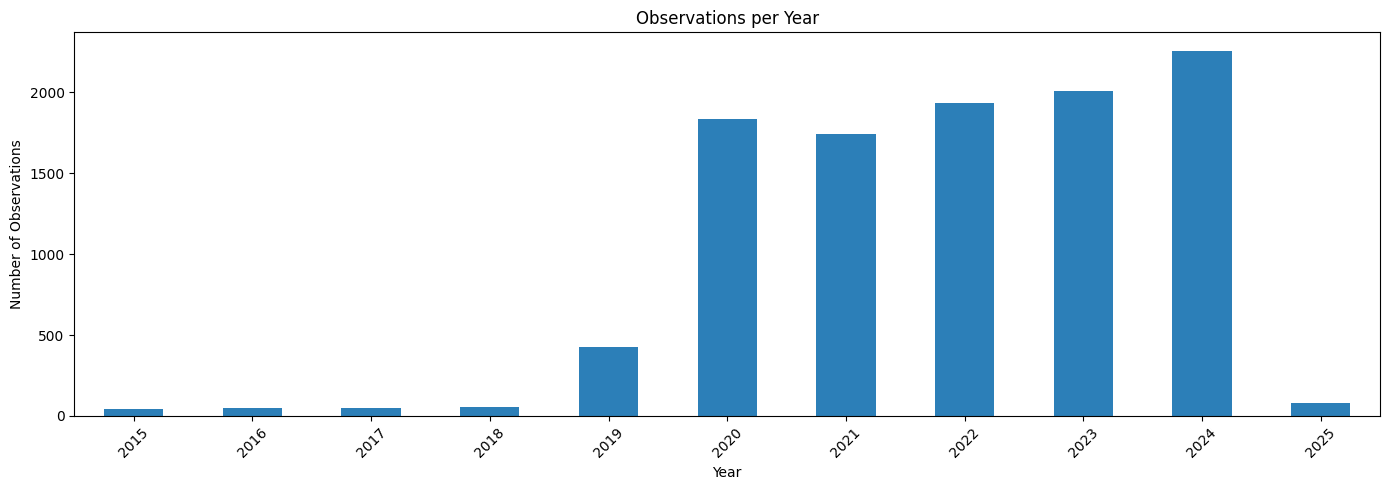

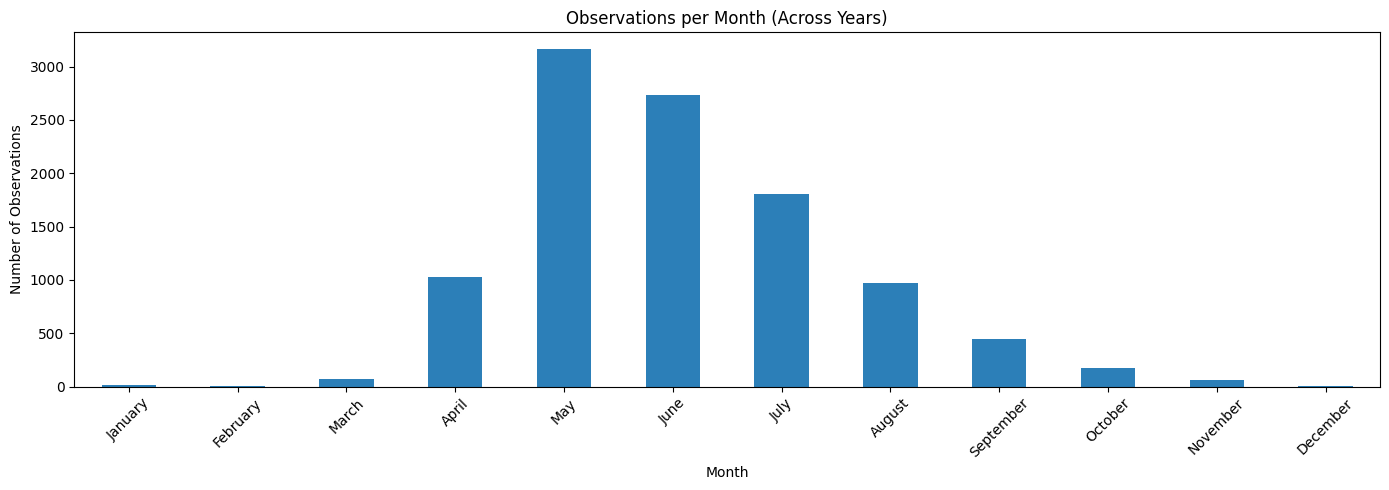

Spatial coverage


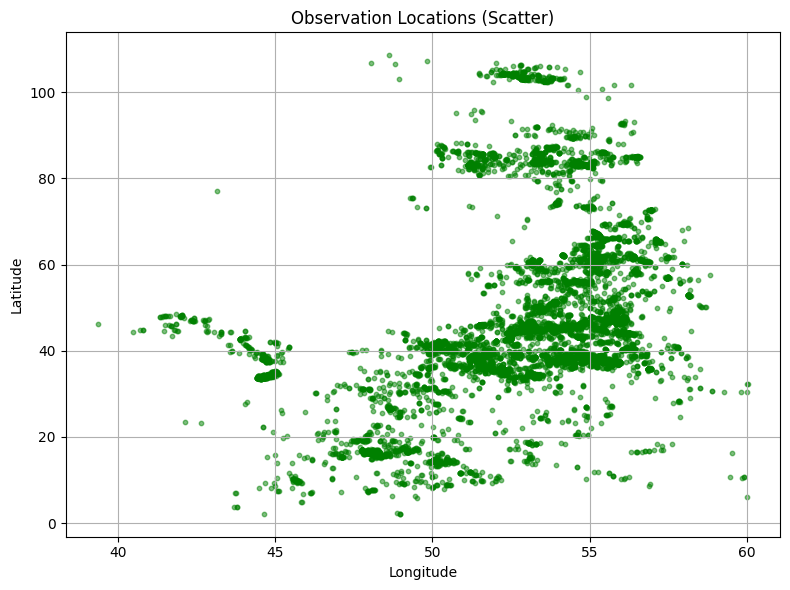

🌍 Saved interactive map to PROVA_fragola_verde/observations_map_PROVA_fragola_verde.html
Phenology over time


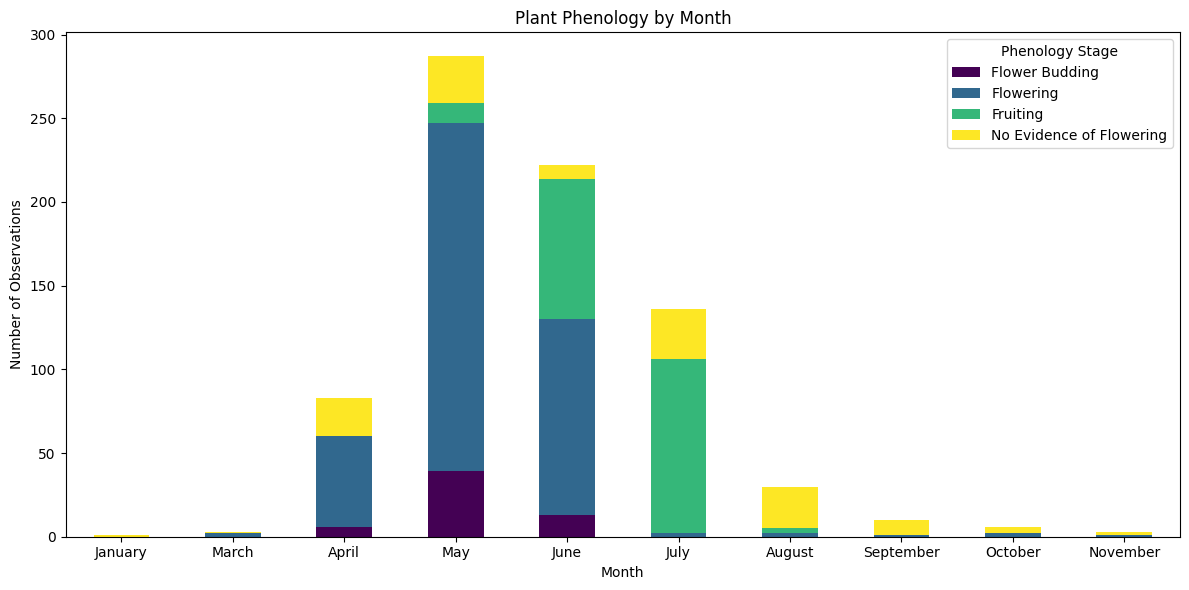

Top species


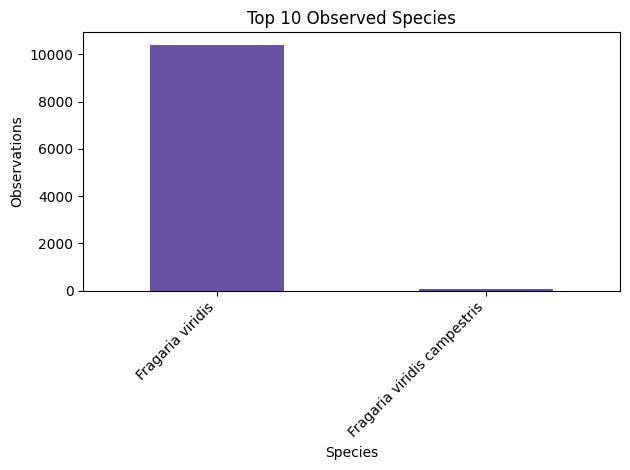

Found 15663 total photo links.


100%|██████████| 15663/15663 [1:07:47<00:00,  3.85it/s]


✅ All images downloaded.


In [24]:
output_file = f"PROVA_fragola_verde/inaturalist_observation_taxon_447812.csv"
df.to_csv(output_file, index=False)
print(f"Saved {len(df)} observations to {output_file}")
repository_name="PROVA_fragola_verde"
analyze_results_download_from_inat(df, repository_name)  
download_photos(repository_name=repository_name)

Found 0 existing observation IDs
Created 122 date ranges for fetching

Fetching range 1/122: 2015-04-30 to 2015-05-29


Fetching 2015-04-30 to 2015-05-29: 1page [00:04,  4.14s/page, records=89, total=89, pages=1/1]


Found 89 observations in this date range
Added 89 new observations
Total observations now: 89 (89 new)

Fetching range 2/122: 2015-05-30 to 2015-06-28


Fetching 2015-05-30 to 2015-06-28: 1page [00:04,  4.54s/page, records=145, total=145, pages=1/1]


Found 145 observations in this date range
Added 145 new observations
Total observations now: 234 (234 new)

Fetching range 3/122: 2015-06-29 to 2015-07-28


Fetching 2015-06-29 to 2015-07-28: 1page [00:05,  5.58s/page, records=154, total=154, pages=1/1]


Found 154 observations in this date range
Added 154 new observations
Total observations now: 388 (388 new)

Fetching range 4/122: 2015-07-29 to 2015-08-27


Fetching 2015-07-29 to 2015-08-27: 1page [00:05,  5.19s/page, records=57, total=57, pages=1/1]


Found 57 observations in this date range
Added 57 new observations
Total observations now: 445 (445 new)

Fetching range 5/122: 2015-08-28 to 2015-09-26


Fetching 2015-08-28 to 2015-09-26: 1page [00:02,  2.66s/page, records=46, total=46, pages=1/1]


Found 46 observations in this date range
Added 46 new observations
Total observations now: 491 (491 new)

Fetching range 6/122: 2015-09-27 to 2015-10-26


Fetching 2015-09-27 to 2015-10-26: 1page [00:03,  3.09s/page, records=37, total=37, pages=1/1]


Found 37 observations in this date range
Added 37 new observations
Total observations now: 528 (528 new)

Fetching range 7/122: 2015-10-27 to 2015-11-25


Fetching 2015-10-27 to 2015-11-25: 1page [00:02,  2.68s/page, records=31, total=31, pages=1/1]


Found 31 observations in this date range
Added 31 new observations
Total observations now: 559 (559 new)

Fetching range 8/122: 2015-11-26 to 2015-12-25


Fetching 2015-11-26 to 2015-12-25: 1page [00:01,  1.80s/page, records=16, total=16, pages=1/1]


Found 16 observations in this date range
Added 16 new observations
Total observations now: 575 (575 new)

Fetching range 9/122: 2015-12-26 to 2016-01-24


Fetching 2015-12-26 to 2016-01-24: 1page [00:01,  1.84s/page, records=6, total=6, pages=1/1]


Found 6 observations in this date range
Added 6 new observations
Total observations now: 581 (581 new)

Fetching range 10/122: 2016-01-25 to 2016-02-23


Fetching 2016-01-25 to 2016-02-23: 1page [00:01,  1.91s/page, records=17, total=17, pages=1/1]


Found 17 observations in this date range
Added 17 new observations
Total observations now: 598 (598 new)

Fetching range 11/122: 2016-02-24 to 2016-03-24


Fetching 2016-02-24 to 2016-03-24: 1page [00:02,  2.76s/page, records=39, total=39, pages=1/1]


Found 39 observations in this date range
Added 39 new observations
Total observations now: 637 (637 new)

Fetching range 12/122: 2016-03-25 to 2016-04-23


Fetching 2016-03-25 to 2016-04-23: 2page [00:08,  4.24s/page, records=212, total=212, pages=2/2]


Found 212 observations in this date range
Added 212 new observations
Total observations now: 849 (849 new)

Fetching range 13/122: 2016-04-24 to 2016-05-23


Fetching 2016-04-24 to 2016-05-23: 2page [00:11,  5.51s/page, records=324, total=324, pages=2/2]


Found 324 observations in this date range
Added 324 new observations
Total observations now: 1173 (1173 new)

Fetching range 14/122: 2016-05-24 to 2016-06-22


Fetching 2016-05-24 to 2016-06-22: 2page [00:11,  5.84s/page, records=319, total=319, pages=2/2]


Found 319 observations in this date range
Added 319 new observations
Total observations now: 1492 (1492 new)

Fetching range 15/122: 2016-06-23 to 2016-07-22


Fetching 2016-06-23 to 2016-07-22: 2page [00:09,  4.71s/page, records=282, total=282, pages=2/2]


Found 282 observations in this date range
Added 282 new observations
Total observations now: 1774 (1774 new)

Fetching range 16/122: 2016-07-23 to 2016-08-21


Fetching 2016-07-23 to 2016-08-21: 2page [00:10,  5.21s/page, records=208, total=208, pages=2/2]


Found 208 observations in this date range
Added 208 new observations
Total observations now: 1982 (1982 new)

Fetching range 17/122: 2016-08-22 to 2016-09-20


Fetching 2016-08-22 to 2016-09-20: 1page [00:05,  5.15s/page, records=126, total=126, pages=1/1]


Found 126 observations in this date range
Added 126 new observations
Total observations now: 2108 (2108 new)

Fetching range 18/122: 2016-09-21 to 2016-10-20


Fetching 2016-09-21 to 2016-10-20: 1page [00:03,  3.44s/page, records=77, total=77, pages=1/1]


Found 77 observations in this date range
Added 77 new observations
Total observations now: 2185 (2185 new)

Fetching range 19/122: 2016-10-21 to 2016-11-19


Fetching 2016-10-21 to 2016-11-19: 1page [00:03,  3.05s/page, records=51, total=51, pages=1/1]


Found 51 observations in this date range
Added 51 new observations
Total observations now: 2236 (2236 new)

Fetching range 20/122: 2016-11-20 to 2016-12-19


Fetching 2016-11-20 to 2016-12-19: 1page [00:02,  2.52s/page, records=34, total=34, pages=1/1]


Found 34 observations in this date range
Added 34 new observations
Total observations now: 2270 (2270 new)

Fetching range 21/122: 2016-12-20 to 2017-01-18


Fetching 2016-12-20 to 2017-01-18: 1page [00:02,  2.51s/page, records=16, total=16, pages=1/1]


Found 16 observations in this date range
Added 16 new observations
Total observations now: 2286 (2286 new)

Fetching range 22/122: 2017-01-19 to 2017-02-17


Fetching 2017-01-19 to 2017-02-17: 1page [00:02,  2.57s/page, records=22, total=22, pages=1/1]


Found 22 observations in this date range
Added 22 new observations
Total observations now: 2308 (2308 new)

Fetching range 23/122: 2017-02-18 to 2017-03-19


Fetching 2017-02-18 to 2017-03-19: 1page [00:03,  3.29s/page, records=58, total=58, pages=1/1]


Found 58 observations in this date range
Added 58 new observations
Total observations now: 2366 (2366 new)

Fetching range 24/122: 2017-03-20 to 2017-04-18


Fetching 2017-03-20 to 2017-04-18: 2page [00:13,  6.89s/page, records=371, total=371, pages=2/2]


Found 371 observations in this date range
Added 371 new observations
Total observations now: 2737 (2737 new)

Fetching range 25/122: 2017-04-19 to 2017-05-18


Fetching 2017-04-19 to 2017-05-18: 2page [00:11,  5.75s/page, records=355, total=355, pages=2/2]


Found 355 observations in this date range
Added 355 new observations
Total observations now: 3092 (3092 new)

Fetching range 26/122: 2017-05-19 to 2017-06-17


Fetching 2017-05-19 to 2017-06-17: 3page [00:18,  6.05s/page, records=563, total=563, pages=3/3]


Found 563 observations in this date range
Added 563 new observations
Total observations now: 3655 (3655 new)

Fetching range 27/122: 2017-06-18 to 2017-07-17


Fetching 2017-06-18 to 2017-07-17: 4page [00:25,  6.26s/page, records=770, total=770, pages=4/4]


Found 770 observations in this date range
Added 770 new observations
Total observations now: 4425 (4425 new)

Fetching range 28/122: 2017-07-18 to 2017-08-16


Fetching 2017-07-18 to 2017-08-16: 3page [00:17,  5.74s/page, records=542, total=542, pages=3/3]


Found 542 observations in this date range
Added 542 new observations
Total observations now: 4967 (4967 new)

Fetching range 29/122: 2017-08-17 to 2017-09-15


Fetching 2017-08-17 to 2017-09-15: 2page [00:12,  6.16s/page, records=390, total=390, pages=2/2]


Found 390 observations in this date range
Added 390 new observations
Total observations now: 5357 (5357 new)

Fetching range 30/122: 2017-09-16 to 2017-10-15


Fetching 2017-09-16 to 2017-10-15: 2page [00:09,  4.82s/page, records=265, total=265, pages=2/2]


Found 265 observations in this date range
Added 265 new observations
Total observations now: 5622 (5622 new)

Fetching range 31/122: 2017-10-16 to 2017-11-14


Fetching 2017-10-16 to 2017-11-14: 1page [00:04,  4.15s/page, records=104, total=104, pages=1/1]


Found 104 observations in this date range
Added 104 new observations
Total observations now: 5726 (5726 new)

Fetching range 32/122: 2017-11-15 to 2017-12-14


Fetching 2017-11-15 to 2017-12-14: 1page [00:03,  3.41s/page, records=50, total=50, pages=1/1]


Found 50 observations in this date range
Added 50 new observations
Total observations now: 5776 (5776 new)

Fetching range 33/122: 2017-12-15 to 2018-01-13


Fetching 2017-12-15 to 2018-01-13: 1page [00:02,  2.62s/page, records=37, total=37, pages=1/1]


Found 37 observations in this date range
Added 37 new observations
Total observations now: 5813 (5813 new)

Fetching range 34/122: 2018-01-14 to 2018-02-12


Fetching 2018-01-14 to 2018-02-12: 1page [00:03,  3.70s/page, records=75, total=75, pages=1/1]


Found 75 observations in this date range
Added 75 new observations
Total observations now: 5888 (5888 new)

Fetching range 35/122: 2018-02-13 to 2018-03-14


Fetching 2018-02-13 to 2018-03-14: 1page [00:04,  4.80s/page, records=134, total=134, pages=1/1]


Found 134 observations in this date range
Added 134 new observations
Total observations now: 6022 (6022 new)

Fetching range 36/122: 2018-03-15 to 2018-04-13


Fetching 2018-03-15 to 2018-04-13: 2page [00:10,  5.48s/page, records=299, total=299, pages=2/2]


Found 299 observations in this date range
Added 299 new observations
Total observations now: 6321 (6321 new)

Fetching range 37/122: 2018-04-14 to 2018-05-13


Fetching 2018-04-14 to 2018-05-13: 6page [00:41,  6.90s/page, records=1168, total=1168, pages=6/6]


Found 1168 observations in this date range
Added 1168 new observations
Total observations now: 7489 (7489 new)

Fetching range 38/122: 2018-05-14 to 2018-06-12


Fetching 2018-05-14 to 2018-06-12: 6page [00:35,  5.90s/page, records=1051, total=1051, pages=6/6]


Found 1051 observations in this date range
Added 1051 new observations
Total observations now: 8540 (8540 new)

Fetching range 39/122: 2018-06-13 to 2018-07-12


Fetching 2018-06-13 to 2018-07-12: 8page [00:56,  7.08s/page, records=1506, total=1506, pages=8/8]


Found 1506 observations in this date range
Added 1506 new observations
Total observations now: 10046 (10046 new)

Fetching range 40/122: 2018-07-13 to 2018-08-11


Fetching 2018-07-13 to 2018-08-11: 6page [00:39,  6.59s/page, records=1116, total=1116, pages=6/6]


Found 1116 observations in this date range
Added 1116 new observations
Total observations now: 11162 (11162 new)

Fetching range 41/122: 2018-08-12 to 2018-09-10


Fetching 2018-08-12 to 2018-09-10: 4page [00:23,  5.92s/page, records=627, total=627, pages=4/4]


Found 627 observations in this date range
Added 627 new observations
Total observations now: 11789 (11789 new)

Fetching range 42/122: 2018-09-11 to 2018-10-10


Fetching 2018-09-11 to 2018-10-10: 3page [00:20,  6.98s/page, records=466, total=466, pages=3/3]


Found 466 observations in this date range
Added 466 new observations
Total observations now: 12255 (12255 new)

Fetching range 43/122: 2018-10-11 to 2018-11-09


Fetching 2018-10-11 to 2018-11-09: 2page [00:11,  5.71s/page, records=274, total=274, pages=2/2]


Found 274 observations in this date range
Added 274 new observations
Total observations now: 12529 (12529 new)

Fetching range 44/122: 2018-11-10 to 2018-12-09


Fetching 2018-11-10 to 2018-12-09: 1page [00:04,  4.59s/page, records=115, total=115, pages=1/1]


Found 115 observations in this date range
Added 115 new observations
Total observations now: 12644 (12644 new)

Fetching range 45/122: 2018-12-10 to 2019-01-08


Fetching 2018-12-10 to 2019-01-08: 1page [00:03,  3.05s/page, records=59, total=59, pages=1/1]


Found 59 observations in this date range
Added 59 new observations
Total observations now: 12703 (12703 new)

Fetching range 46/122: 2019-01-09 to 2019-02-07


Fetching 2019-01-09 to 2019-02-07: 1page [00:03,  3.88s/page, records=69, total=69, pages=1/1]


Found 69 observations in this date range
Added 69 new observations
Total observations now: 12772 (12772 new)

Fetching range 47/122: 2019-02-08 to 2019-03-09


Fetching 2019-02-08 to 2019-03-09: 1page [00:05,  5.39s/page, records=151, total=151, pages=1/1]


Found 151 observations in this date range
Added 151 new observations
Total observations now: 12923 (12923 new)

Fetching range 48/122: 2019-03-10 to 2019-04-08


Fetching 2019-03-10 to 2019-04-08: 3page [00:15,  5.05s/page, records=401, total=401, pages=3/3]


Found 401 observations in this date range
Added 401 new observations
Total observations now: 13324 (13324 new)

Fetching range 49/122: 2019-04-09 to 2019-05-08


Fetching 2019-04-09 to 2019-05-08: 9page [01:00,  6.70s/page, records=1603, total=1603, pages=9/9]


Found 1603 observations in this date range
Added 1603 new observations
Total observations now: 14927 (14927 new)

Fetching range 50/122: 2019-05-09 to 2019-06-07


Fetching 2019-05-09 to 2019-06-07: 9page [00:55,  6.19s/page, records=1775, total=1775, pages=9/9]


Found 1775 observations in this date range
Added 1775 new observations
Total observations now: 16702 (16702 new)

Fetching range 51/122: 2019-06-08 to 2019-07-07


Fetching 2019-06-08 to 2019-07-07: 14page [01:26,  6.19s/page, records=2744, total=2744, pages=14/14]


Found 2744 observations in this date range
Added 2744 new observations
Total observations now: 19446 (19446 new)

Fetching range 52/122: 2019-07-08 to 2019-08-06


Fetching 2019-07-08 to 2019-08-06: 14page [01:28,  6.29s/page, records=2631, total=2631, pages=14/14]


Found 2631 observations in this date range
Added 2631 new observations
Total observations now: 22077 (22077 new)

Fetching range 53/122: 2019-08-07 to 2019-09-05


Fetching 2019-08-07 to 2019-09-05: 8page [00:47,  6.00s/page, records=1452, total=1452, pages=8/8]


Found 1452 observations in this date range
Added 1452 new observations
Total observations now: 23529 (23529 new)

Fetching range 54/122: 2019-09-06 to 2019-10-05


Fetching 2019-09-06 to 2019-10-05: 5page [00:28,  5.67s/page, records=870, total=870, pages=5/5]


Found 870 observations in this date range
Added 870 new observations
Total observations now: 24399 (24399 new)

Fetching range 55/122: 2019-10-06 to 2019-11-04


Fetching 2019-10-06 to 2019-11-04: 3page [00:16,  5.52s/page, records=442, total=442, pages=3/3]


Found 442 observations in this date range
Added 442 new observations
Total observations now: 24841 (24841 new)

Fetching range 56/122: 2019-11-05 to 2019-12-04


Fetching 2019-11-05 to 2019-12-04: 1page [00:05,  5.03s/page, records=175, total=175, pages=1/1]


Found 175 observations in this date range
Added 175 new observations
Total observations now: 25016 (25016 new)

Fetching range 57/122: 2019-12-05 to 2020-01-03


Fetching 2019-12-05 to 2020-01-03: 1page [00:04,  4.41s/page, records=117, total=117, pages=1/1]


Found 117 observations in this date range
Added 117 new observations
Total observations now: 25133 (25133 new)

Fetching range 58/122: 2020-01-04 to 2020-02-02


Fetching 2020-01-04 to 2020-02-02: 1page [00:04,  4.54s/page, records=126, total=126, pages=1/1]


Found 126 observations in this date range
Added 126 new observations
Total observations now: 25259 (25259 new)

Fetching range 59/122: 2020-02-03 to 2020-03-03


Fetching 2020-02-03 to 2020-03-03: 2page [00:11,  5.58s/page, records=298, total=298, pages=2/2]


Found 298 observations in this date range
Added 298 new observations
Total observations now: 25557 (25557 new)

Fetching range 60/122: 2020-03-04 to 2020-04-02


Fetching 2020-03-04 to 2020-04-02: 3page [00:18,  6.29s/page, records=519, total=519, pages=3/3]


Found 519 observations in this date range
Added 519 new observations
Total observations now: 26076 (26076 new)

Fetching range 61/122: 2020-04-03 to 2020-05-02


Fetching 2020-04-03 to 2020-05-02: 8page [00:51,  6.45s/page, records=1591, total=1591, pages=8/8]


Found 1591 observations in this date range
Added 1591 new observations
Total observations now: 27667 (27667 new)

Fetching range 62/122: 2020-05-03 to 2020-06-01


Fetching 2020-05-03 to 2020-06-01: 10page [01:02,  6.24s/page, records=2000, total=2197, pages=10/11]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 4 seconds...


Fetching 2020-05-03 to 2020-06-01: 11page [01:16,  7.00s/page, records=2197, total=2197, pages=11/11]


Found 2197 observations in this date range
Added 2197 new observations
Total observations now: 29864 (29864 new)

Fetching range 63/122: 2020-06-02 to 2020-07-01


Fetching 2020-06-02 to 2020-07-01: 21page [02:09,  6.19s/page, records=4169, total=4169, pages=21/21]


Found 4169 observations in this date range
Added 4169 new observations
Total observations now: 34033 (34033 new)

Fetching range 64/122: 2020-07-02 to 2020-07-31


Fetching 2020-07-02 to 2020-07-31: 18page [01:56,  6.47s/page, records=3529, total=3529, pages=18/18]


Found 3529 observations in this date range
Added 3529 new observations
Total observations now: 37562 (37562 new)

Fetching range 65/122: 2020-08-01 to 2020-08-30


Fetching 2020-08-01 to 2020-08-30: 10page [01:01,  6.19s/page, records=1950, total=1950, pages=10/10]


Found 1950 observations in this date range
Added 1950 new observations
Total observations now: 39512 (39512 new)

Fetching range 66/122: 2020-08-31 to 2020-09-29


Fetching 2020-08-31 to 2020-09-29: 7page [00:41,  5.95s/page, records=1297, total=1297, pages=7/7]


Found 1297 observations in this date range
Added 1297 new observations
Total observations now: 40809 (40809 new)

Fetching range 67/122: 2020-09-30 to 2020-10-29


Fetching 2020-09-30 to 2020-10-29: 4page [00:26,  6.74s/page, records=786, total=786, pages=4/4]


Found 786 observations in this date range
Added 786 new observations
Total observations now: 41595 (41595 new)

Fetching range 68/122: 2020-10-30 to 2020-11-28


Fetching 2020-10-30 to 2020-11-28: 2page [00:13,  6.57s/page, records=351, total=351, pages=2/2]


Found 351 observations in this date range
Added 351 new observations
Total observations now: 41946 (41946 new)

Fetching range 69/122: 2020-11-29 to 2020-12-28


Fetching 2020-11-29 to 2020-12-28: 1page [00:05,  5.21s/page, records=153, total=153, pages=1/1]


Found 153 observations in this date range
Added 153 new observations
Total observations now: 42099 (42099 new)

Fetching range 70/122: 2020-12-29 to 2021-01-27


Fetching 2020-12-29 to 2021-01-27: 1page [00:05,  5.46s/page, records=181, total=181, pages=1/1]


Found 181 observations in this date range
Added 181 new observations
Total observations now: 42280 (42280 new)

Fetching range 71/122: 2021-01-28 to 2021-02-26


Fetching 2021-01-28 to 2021-02-26: 2page [00:08,  4.45s/page, records=227, total=227, pages=2/2]


Found 227 observations in this date range
Added 227 new observations
Total observations now: 42507 (42507 new)

Fetching range 72/122: 2021-02-27 to 2021-03-28


Fetching 2021-02-27 to 2021-03-28: 3page [00:19,  6.56s/page, records=561, total=561, pages=3/3]


Found 561 observations in this date range
Added 561 new observations
Total observations now: 43068 (43068 new)

Fetching range 73/122: 2021-03-29 to 2021-04-27


Fetching 2021-03-29 to 2021-04-27: 8page [00:49,  6.19s/page, records=1424, total=1424, pages=8/8]


Found 1424 observations in this date range
Added 1424 new observations
Total observations now: 44492 (44492 new)

Fetching range 74/122: 2021-04-28 to 2021-05-27


Fetching 2021-04-28 to 2021-05-27: 16page [01:46,  6.67s/page, records=3096, total=3096, pages=16/16]


Found 3096 observations in this date range
Added 3096 new observations
Total observations now: 47588 (47588 new)

Fetching range 75/122: 2021-05-28 to 2021-06-26


Fetching 2021-05-28 to 2021-06-26: 22page [02:19,  6.33s/page, records=4313, total=4313, pages=22/22]


Found 4313 observations in this date range
Added 4313 new observations
Total observations now: 51901 (51901 new)

Fetching range 76/122: 2021-06-27 to 2021-07-26


Fetching 2021-06-27 to 2021-07-26: 21page [02:16,  6.49s/page, records=4031, total=4031, pages=21/21]


Found 4031 observations in this date range
Added 4031 new observations
Total observations now: 55932 (55932 new)

Fetching range 77/122: 2021-07-27 to 2021-08-25


Fetching 2021-07-27 to 2021-08-25: 13page [01:19,  6.13s/page, records=2453, total=2453, pages=13/13]


Found 2453 observations in this date range
Added 2453 new observations
Total observations now: 58385 (58385 new)

Fetching range 78/122: 2021-08-26 to 2021-09-24


Fetching 2021-08-26 to 2021-09-24: 7page [00:46,  6.65s/page, records=1260, total=1260, pages=7/7]


Found 1260 observations in this date range
Added 1260 new observations
Total observations now: 59645 (59645 new)

Fetching range 79/122: 2021-09-25 to 2021-10-24


Fetching 2021-09-25 to 2021-10-24: 5page [00:35,  7.03s/page, records=929, total=929, pages=5/5]


Found 929 observations in this date range
Added 929 new observations
Total observations now: 60574 (60574 new)

Fetching range 80/122: 2021-10-25 to 2021-11-23


Fetching 2021-10-25 to 2021-11-23: 3page [00:19,  6.58s/page, records=529, total=529, pages=3/3]


Found 529 observations in this date range
Added 529 new observations
Total observations now: 61103 (61103 new)

Fetching range 81/122: 2021-11-24 to 2021-12-23


Fetching 2021-11-24 to 2021-12-23: 2page [00:09,  4.64s/page, records=241, total=241, pages=2/2]


Found 241 observations in this date range
Added 241 new observations
Total observations now: 61344 (61344 new)

Fetching range 82/122: 2021-12-24 to 2022-01-22


Fetching 2021-12-24 to 2022-01-22: 2page [00:08,  4.33s/page, records=210, total=210, pages=2/2]


Found 210 observations in this date range
Added 210 new observations
Total observations now: 61554 (61554 new)

Fetching range 83/122: 2022-01-23 to 2022-02-21


Fetching 2022-01-23 to 2022-02-21: 2page [00:11,  5.64s/page, records=328, total=328, pages=2/2]


Found 328 observations in this date range
Added 328 new observations
Total observations now: 61882 (61882 new)

Fetching range 84/122: 2022-02-22 to 2022-03-23


Fetching 2022-02-22 to 2022-03-23: 3page [00:16,  5.63s/page, records=487, total=487, pages=3/3]


Found 487 observations in this date range
Added 487 new observations
Total observations now: 62369 (62369 new)

Fetching range 85/122: 2022-03-24 to 2022-04-22


Fetching 2022-03-24 to 2022-04-22: 5page [00:30,  6.17s/page, records=992, total=992, pages=5/5]


Found 992 observations in this date range
Added 992 new observations
Total observations now: 63361 (63361 new)

Fetching range 86/122: 2022-04-23 to 2022-05-22


Fetching 2022-04-23 to 2022-05-22: 13page [01:20,  6.16s/page, records=2429, total=2429, pages=13/13]


Found 2429 observations in this date range
Added 2429 new observations
Total observations now: 65790 (65790 new)

Fetching range 87/122: 2022-05-23 to 2022-06-21


Fetching 2022-05-23 to 2022-06-21: 19page [02:03,  6.49s/page, records=3800, total=3800, pages=19/19]


Found 3800 observations in this date range
Added 3800 new observations
Total observations now: 69590 (69590 new)

Fetching range 88/122: 2022-06-22 to 2022-07-21


Fetching 2022-06-22 to 2022-07-21: 24page [02:34,  6.45s/page, records=4675, total=4675, pages=24/24]


Found 4675 observations in this date range
Added 4675 new observations
Total observations now: 74265 (74265 new)

Fetching range 89/122: 2022-07-22 to 2022-08-20


Fetching 2022-07-22 to 2022-08-20: 15page [01:35,  6.34s/page, records=2885, total=2885, pages=15/15]


Found 2885 observations in this date range
Added 2885 new observations
Total observations now: 77150 (77150 new)

Fetching range 90/122: 2022-08-21 to 2022-09-19


Fetching 2022-08-21 to 2022-09-19: 8page [00:46,  5.83s/page, records=1432, total=1432, pages=8/8]


Found 1432 observations in this date range
Added 1432 new observations
Total observations now: 78582 (78582 new)

Fetching range 91/122: 2022-09-20 to 2022-10-19


Fetching 2022-09-20 to 2022-10-19: 6page [00:34,  5.82s/page, records=1020, total=1020, pages=6/6]


Found 1020 observations in this date range
Added 1020 new observations
Total observations now: 79602 (79602 new)

Fetching range 92/122: 2022-10-20 to 2022-11-18


Fetching 2022-10-20 to 2022-11-18: 3page [00:18,  6.01s/page, records=551, total=551, pages=3/3]


Found 551 observations in this date range
Added 551 new observations
Total observations now: 80153 (80153 new)

Fetching range 93/122: 2022-11-19 to 2022-12-18


Fetching 2022-11-19 to 2022-12-18: 2page [00:09,  4.60s/page, records=212, total=212, pages=2/2]


Found 212 observations in this date range
Added 212 new observations
Total observations now: 80365 (80365 new)

Fetching range 94/122: 2022-12-19 to 2023-01-17


Fetching 2022-12-19 to 2023-01-17: 1page [00:04,  4.24s/page, records=129, total=129, pages=1/1]


Found 129 observations in this date range
Added 129 new observations
Total observations now: 80494 (80494 new)

Fetching range 95/122: 2023-01-18 to 2023-02-16


Fetching 2023-01-18 to 2023-02-16: 2page [00:09,  4.51s/page, records=216, total=216, pages=2/2]


Found 216 observations in this date range
Added 216 new observations
Total observations now: 80710 (80710 new)

Fetching range 96/122: 2023-02-17 to 2023-03-18


Fetching 2023-02-17 to 2023-03-18: 2page [00:14,  7.13s/page, records=353, total=353, pages=2/2]


Found 353 observations in this date range
Added 353 new observations
Total observations now: 81063 (81063 new)

Fetching range 97/122: 2023-03-19 to 2023-04-17


Fetching 2023-03-19 to 2023-04-17: 5page [00:32,  6.55s/page, records=815, total=815, pages=5/5]


Found 815 observations in this date range
Added 815 new observations
Total observations now: 81878 (81878 new)

Fetching range 98/122: 2023-04-18 to 2023-05-17


Fetching 2023-04-18 to 2023-05-17: 13page [01:26,  6.68s/page, records=2418, total=2418, pages=13/13]


Found 2418 observations in this date range
Added 2418 new observations
Total observations now: 84296 (84296 new)

Fetching range 99/122: 2023-05-18 to 2023-06-16


Fetching 2023-05-18 to 2023-06-16: 19page [02:15,  7.12s/page, records=3800, total=3800, pages=19/19]


Found 3800 observations in this date range
Added 3800 new observations
Total observations now: 88096 (88096 new)

Fetching range 100/122: 2023-06-17 to 2023-07-16


Fetching 2023-06-17 to 2023-07-16: 26page [02:52,  6.63s/page, records=5131, total=5131, pages=26/26]


Found 5131 observations in this date range
Added 5131 new observations
Total observations now: 93227 (93227 new)

Fetching range 101/122: 2023-07-17 to 2023-08-15


Fetching 2023-07-17 to 2023-08-15: 18page [01:51,  6.20s/page, records=3407, total=3407, pages=18/18]


Found 3407 observations in this date range
Added 3407 new observations
Total observations now: 96634 (96634 new)

Fetching range 102/122: 2023-08-16 to 2023-09-14


Fetching 2023-08-16 to 2023-09-14: 9page [00:59,  6.57s/page, records=1771, total=1771, pages=9/9]


Found 1771 observations in this date range
Added 1771 new observations
Total observations now: 98405 (98405 new)

Fetching range 103/122: 2023-09-15 to 2023-10-14


Fetching 2023-09-15 to 2023-10-14: 6page [00:43,  7.29s/page, records=1155, total=1155, pages=6/6]


Found 1155 observations in this date range
Added 1155 new observations
Total observations now: 99560 (99560 new)

Fetching range 104/122: 2023-10-15 to 2023-11-13


Fetching 2023-10-15 to 2023-11-13: 4page [00:26,  6.56s/page, records=635, total=635, pages=4/4]


Found 635 observations in this date range
Added 635 new observations
Total observations now: 100195 (100195 new)

Fetching range 105/122: 2023-11-14 to 2023-12-13


Fetching 2023-11-14 to 2023-12-13: 2page [00:13,  6.58s/page, records=367, total=367, pages=2/2]


Found 367 observations in this date range
Added 367 new observations
Total observations now: 100562 (100562 new)

Fetching range 106/122: 2023-12-14 to 2024-01-12


Fetching 2023-12-14 to 2024-01-12: 2page [00:09,  4.83s/page, records=231, total=231, pages=2/2]


Found 231 observations in this date range
Added 231 new observations
Total observations now: 100793 (100793 new)

Fetching range 107/122: 2024-01-13 to 2024-02-11


Fetching 2024-01-13 to 2024-02-11: 1page [00:05,  5.91s/page, records=191, total=191, pages=1/1]


Found 191 observations in this date range
Added 191 new observations
Total observations now: 100984 (100984 new)

Fetching range 108/122: 2024-02-12 to 2024-03-12


Fetching 2024-02-12 to 2024-03-12: 2page [00:11,  5.69s/page, records=357, total=357, pages=2/2]


Found 357 observations in this date range
Added 357 new observations
Total observations now: 101341 (101341 new)

Fetching range 109/122: 2024-03-13 to 2024-04-11


Fetching 2024-03-13 to 2024-04-11: 5page [00:28,  5.63s/page, records=834, total=834, pages=5/5]


Found 834 observations in this date range
Added 834 new observations
Total observations now: 102175 (102175 new)

Fetching range 110/122: 2024-04-12 to 2024-05-11


Fetching 2024-04-12 to 2024-05-11: 14page [01:31,  6.56s/page, records=2606, total=2606, pages=14/14]


Found 2606 observations in this date range
Added 2606 new observations
Total observations now: 104781 (104781 new)

Fetching range 111/122: 2024-05-12 to 2024-06-10


Fetching 2024-05-12 to 2024-06-10: 19page [02:08,  6.78s/page, records=3671, total=3671, pages=19/19]


Found 3671 observations in this date range
Added 3671 new observations
Total observations now: 108452 (108452 new)

Fetching range 112/122: 2024-06-11 to 2024-07-10


Fetching 2024-06-11 to 2024-07-10: 26page [02:47,  6.44s/page, records=5175, total=5175, pages=26/26]


Found 5175 observations in this date range
Added 5175 new observations
Total observations now: 113627 (113627 new)

Fetching range 113/122: 2024-07-11 to 2024-08-09


Fetching 2024-07-11 to 2024-08-09: 20page [02:05,  6.28s/page, records=3802, total=3802, pages=20/20]


Found 3802 observations in this date range
Added 3802 new observations
Total observations now: 117429 (117429 new)

Fetching range 114/122: 2024-08-10 to 2024-09-08


Fetching 2024-08-10 to 2024-09-08: 11page [01:08,  6.21s/page, records=2044, total=2044, pages=11/11]


Found 2044 observations in this date range
Added 2044 new observations
Total observations now: 119473 (119473 new)

Fetching range 115/122: 2024-09-09 to 2024-10-08


Fetching 2024-09-09 to 2024-10-08: 8page [00:50,  6.34s/page, records=1552, total=1552, pages=8/8]


Found 1552 observations in this date range
Added 1552 new observations
Total observations now: 121025 (121025 new)

Fetching range 116/122: 2024-10-09 to 2024-11-07


Fetching 2024-10-09 to 2024-11-07: 5page [00:27,  5.56s/page, records=834, total=834, pages=5/5]


Found 834 observations in this date range
Added 834 new observations
Total observations now: 121859 (121859 new)

Fetching range 117/122: 2024-11-08 to 2024-12-07


Fetching 2024-11-08 to 2024-12-07: 2page [00:11,  5.89s/page, records=366, total=366, pages=2/2]


Found 366 observations in this date range
Added 366 new observations
Total observations now: 122225 (122225 new)

Fetching range 118/122: 2024-12-08 to 2025-01-06


Fetching 2024-12-08 to 2025-01-06: 2page [00:10,  5.16s/page, records=270, total=270, pages=2/2]


Found 270 observations in this date range
Added 270 new observations
Total observations now: 122495 (122495 new)

Fetching range 119/122: 2025-01-07 to 2025-02-05


Fetching 2025-01-07 to 2025-02-05: 2page [00:09,  4.90s/page, records=221, total=221, pages=2/2]


Found 221 observations in this date range
Added 221 new observations
Total observations now: 122716 (122716 new)

Fetching range 120/122: 2025-02-06 to 2025-03-07


Fetching 2025-02-06 to 2025-03-07: 2page [00:11,  5.76s/page, records=305, total=305, pages=2/2]


Found 305 observations in this date range
Added 305 new observations
Total observations now: 123021 (123021 new)

Fetching range 121/122: 2025-03-08 to 2025-04-06


Fetching 2025-03-08 to 2025-04-06: 3page [00:17,  5.86s/page, records=569, total=569, pages=3/3]


Found 569 observations in this date range
Added 569 new observations
Total observations now: 123590 (123590 new)

Fetching range 122/122: 2025-04-07 to 2025-04-27


Fetching 2025-04-07 to 2025-04-27: 6page [00:31,  5.29s/page, records=1032, total=1032, pages=6/6]


Found 1032 observations in this date range
Added 1032 new observations
Total observations now: 124622 (124622 new)

Completed fetching all observations. Total: 124622
Saved 124622 observations to complete_achillea_millefoglie_n_a/inaturalist_observation_taxon_52821_term_id_12.csv

Most Common Annotations (overall):
  - Plant Phenology: nan → 112482 times
  - Plant Phenology: Flowering → 8753 times
  - Plant Phenology: No Evidence of Flowering → 1603 times
  - Plant Phenology: Flower Budding → 1407 times
  - Plant Phenology: Fruiting → 377 times

Top Species with Most Annotated Observations:
  - Achillea millefolium: 123943 annotations
  - Achillea millefolium borealis: 515 annotations
  - Achillea millefolium lanulosa: 109 annotations
  - Achillea millefolium millefolium: 25 annotations
  - Achillea millefolium californica: 13 annotations
  - Achillea millefolium alpicola: 11 annotations
  - Achillea millefolium arenicola: 3 annotations
  - Achillea millefolium nigrescens: 2 annotation

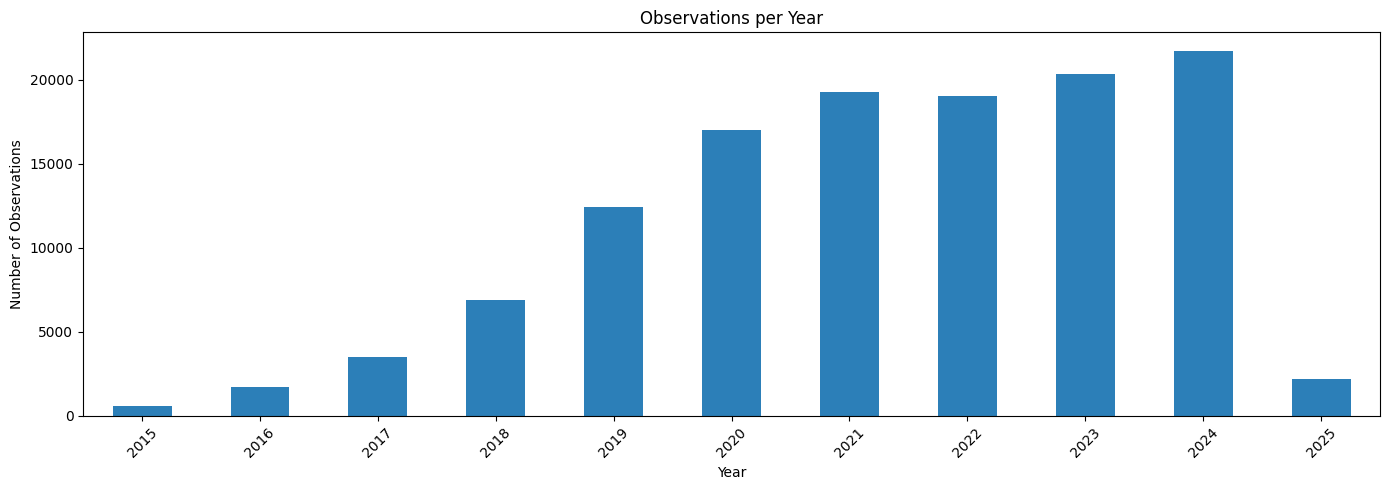

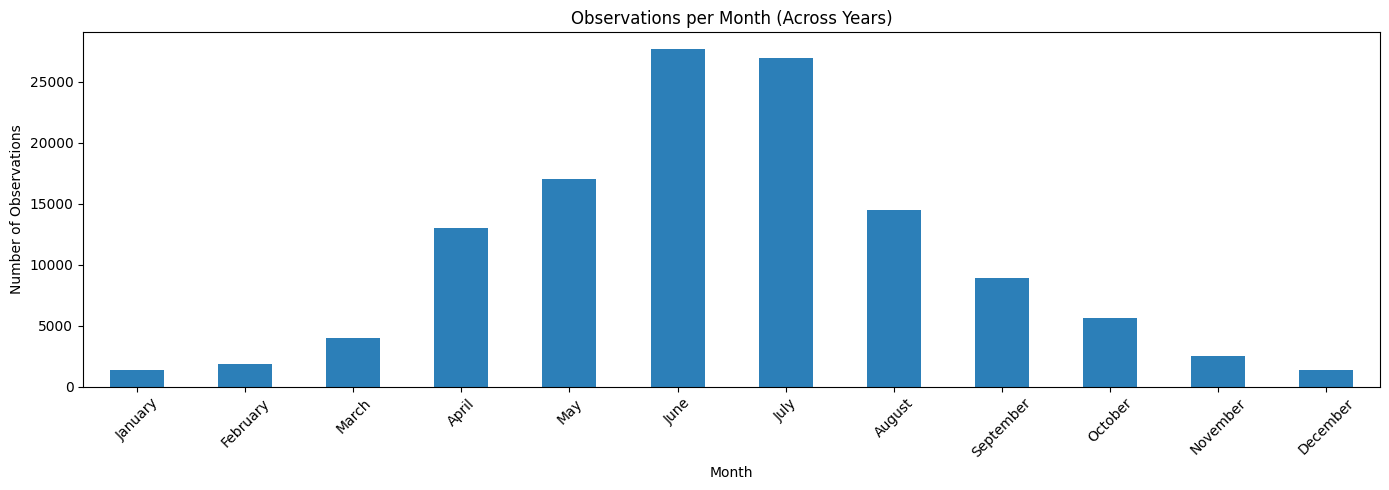

Spatial coverage


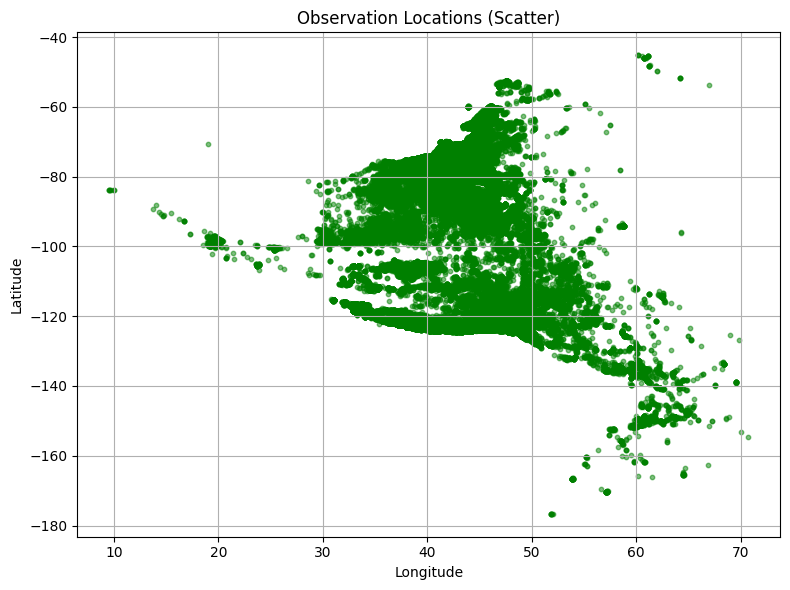

🌍 Saved interactive map to complete_achillea_millefoglie_n_a/observations_map_complete_achillea_millefoglie_n_a.html
Phenology over time


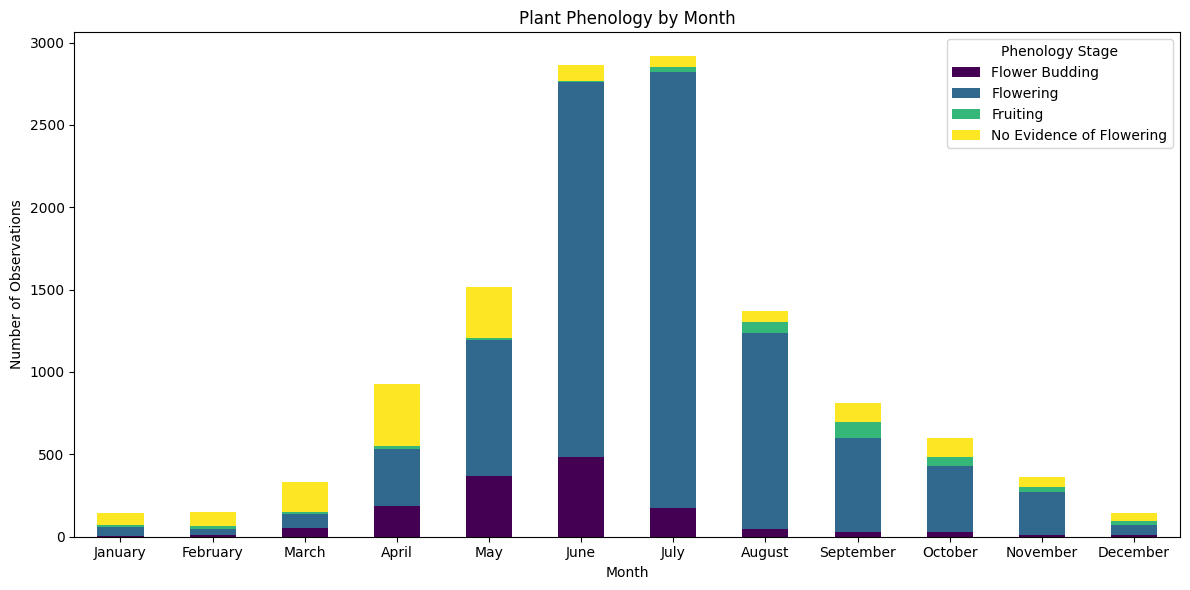

Top species


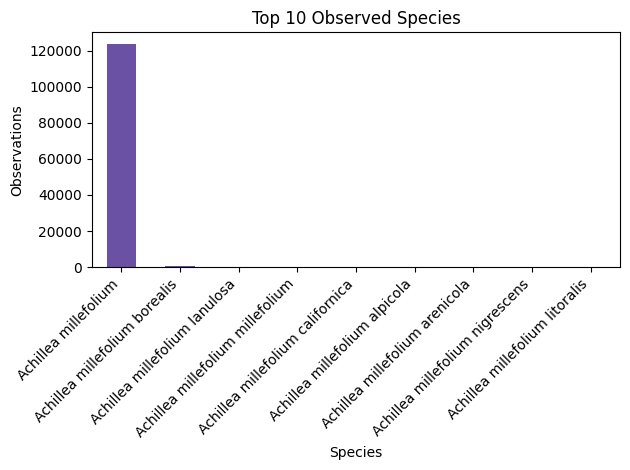

Found 190993 total photo links.


 71%|███████   | 135791/190993 [9:50:22<4:00:00,  3.83it/s] 


KeyboardInterrupt: 

In [25]:
place_id=9853 #North America (incl. ocean)
term_id=12 #Plant phenology

#Dowload observations of Achillea Millefoglie
taxon_id_am = 52821
repository_name_am = "complete_achillea_millefoglie_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_am,repository_name=repository_name_am,term_id=term_id,place_id=place_id)

To do: complete dowload photo and execute next cells (to dwnload metadata and photos of the 2 other species)

In [ ]:
#Dowload observations of Trifolium Pratense
taxon_id_tp = 51875
repository_name_tp = "complete_trifolium_pratense_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_tp,repository_name=repository_name_tp,term_id=term_id,place_id=place_id, with_annotations=False)

In [ ]:
#Dowload observations of Dactylis Glomerata
taxon_id_dg = 52720
repository_name_dg = "complete_dactylis_glomerata_n_a"
fetch_and_analyze_results(taxon_id=taxon_id_dg,repository_name=repository_name_dg,term_id=term_id,place_id=place_id, with_annotations=False)

Check if there are missing photos

In [ ]:
import os
import glob
import json
import requests
import concurrent.futures
from tqdm import tqdm

def check_and_download_missing_photos(folder_name, max_workers=20):

    photo_folder = os.path.join(folder_name, 'inat_photos')
    os.makedirs(photo_folder, exist_ok=True)
    
    print("Caching existing photos...")
    existing_photos = set()
    for fname in os.listdir(photo_folder):
        obs_id = fname.split('_')[0]
        if obs_id.isdigit():
            existing_photos.add(int(obs_id))
    
    download_tasks = []
    total_observations = 0
    
    json_files = sorted(glob.glob(os.path.join(folder_name, 'observations/observations_*.json')))
    for json_file in tqdm(json_files, desc="Processing JSON files"):
        try:
            with open(json_file, 'r') as f:
                observations = json.load(f)
            
            for obs in observations:
                total_observations += 1
                obs_id = obs.get('id')
                
                if obs_id in existing_photos:
                    continue
                    
                photos = obs.get('photos', [])
                if photos:
                    for i, photo in enumerate(photos):
                        url = photo.get('url')
                        if url:
                            url = url.replace("square", "original")
                            ext = url.split('.')[-1].split('?')[0]
                            filename = f"{obs_id}_{i}.{ext}"
                            filepath = os.path.join(photo_folder, filename)
                            download_tasks.append((url, filepath, obs_id))
        
        except json.JSONDecodeError:
            print(f"⚠️ Skipping invalid JSON file: {json_file}")
            continue
    
    if download_tasks:
        print(f"Found {len(download_tasks)} photos to download out of {total_observations} observations")
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            list(tqdm(
                executor.map(download_photo, download_tasks),
                total=len(download_tasks),
                desc="Downloading photos"
            ))
    else:
        print("No missing photos to download")

def download_photo(task):
    url, filepath, obs_id = task
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(filepath, 'wb') as out_file:
                out_file.write(response.content)
            return True
        else:
            return False
    except Exception as e:
        return False

In [3]:
check_and_download_missing_photos("complete_achillea_millefoglie_n_a")

Caching existing photos...


Processing JSON files: 100%|██████████| 14/14 [02:52<00:00, 12.36s/it]


Found 25797 photos to download out of 124622 observations


In [3]:
check_and_download_missing_photos("complete_dactylis_glomerata_n_a")

Caching existing photos...


Processing JSON files: 100%|██████████| 3/3 [00:35<00:00, 11.92s/it]


Found 49 photos to download out of 22397 observations


In [6]:
check_and_download_missing_photos("complete_trifolium_pratense_n_a")

Caching existing photos...


Processing JSON files: 100%|██████████| 9/9 [02:50<00:00, 18.95s/it]


Found 25 photos to download out of 79500 observations
